In [1]:
from datetime import timezone
from datetime import datetime
import numpy as np
import talib
import alpaca_trade_api as tradeapi
import pandas as pd
import time as delay
import os
from dateutil import parser
import datetime as dt
from alpaca_trade_api.polygon import REST
import glob
import talib as ta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Activation, RepeatVector
from tensorflow.keras.layers import MaxPooling2D, Input, LSTM, GRU, ConvLSTM2D, BatchNormalization, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
plt.style.use('default')

Two methods for generating tickers:
Polygon Api is preferable, but can take awhile and can fail.  Either method selects a sufficient number of stocks.
The focus is on mid range stocks as less frequently traded stocks may see more of a pattern.  In other words they may be further from market efficiency meaning patterns may become more apparent.

In [25]:
#backup ticker generation for when polygon api fails
nasdaq = pd.read_csv(r'C:\Users\Adam Parente\Documents\Python Projects\candlestick chart modeling\stock_ticker\nasdaq.csv')
nyse = pd.read_csv(r'C:\Users\Adam Parente\Documents\Python Projects\candlestick chart modeling\stock_ticker\nyse.csv')
stock_info = pd.concat([nasdaq,nyse])
stock_info=stock_info.drop(columns=['Unnamed: 8','Summary Quote'])
stock_info=stock_info.dropna(subset=['MarketCap'])
stock_info['MarketCap']=stock_info['MarketCap'].str.replace('$','')
stock_info['market_cap_unit']=np.nan
stock_info['market_cap_unit']=np.where(stock_info['MarketCap'].str.contains('M'),1000000,stock_info['market_cap_unit'])
stock_info['market_cap_unit']=np.where(stock_info['MarketCap'].str.contains('B'),1000000000,stock_info['market_cap_unit'])
stock_info['MarketCap']=stock_info['MarketCap'].str.replace('B','')
stock_info['MarketCap']=stock_info['MarketCap'].str.replace('M','')
stock_info['MarketCap']=stock_info['MarketCap'].astype(float)
stock_info['MarketCap']=stock_info['MarketCap']*stock_info['market_cap_unit']
tickers = list(stock_info.sort_values(by='MarketCap',ascending=False)[0:1001]['Symbol'])
tickers.append('SPY')

In [133]:
# setup api setup
api = tradeapi.REST(<key>, <secret key>,'https://api.alpaca.markets',api_version='v2')
account = api.get_account()
account.status

'ACTIVE'

In [134]:
#collect tickers from polygon
temp = api.polygon.all_tickers()
tickers=[]
for x in range(len(temp)):
    tickers.append(temp[x].ticker)

In [135]:
#collect current market cap data for tickers.  Make dictionary for valid ones
market_cap_dic = {}
bad_ticks = []
for tick in tickers:
    try:
        market_cap_dic[tick]=api.polygon.company(tick).marketcap
    except:
        bad_ticks.append(bad_ticks)

In [136]:
#generate dataframe for convenience.
ticker_df=pd.DataFrame.from_dict(market_cap_dic,orient='index',columns=['market_cap']).reset_index().rename({'index':'ticker'},axis=1)
ticker_df=ticker_df[ticker_df['market_cap']>1]

In [137]:
ticker_df['market_cap'].describe()

count    6.068000e+03
mean     6.924297e+09
std      3.285236e+10
min      6.300000e+01
25%      1.195597e+08
50%      5.518669e+08
75%      2.856962e+09
max      9.083166e+11
Name: market_cap, dtype: float64

In [138]:
#select mid range stocks
mid_range_df = ticker_df[(ticker_df['market_cap']>ticker_df['market_cap'].quantile(.25)) & (ticker_df['market_cap']<ticker_df['market_cap'].quantile(.75))]

In [140]:
mid_range_df

ticker    market_cap
2       HPI  5.409659e+08
4      CLNE  4.781615e+08
6      ATRS  5.356403e+08
7       NBN  1.693016e+08
8      FDRR  3.974175e+08
...     ...           ...
6395   SLCA  1.181272e+09
6396    DEX  1.223269e+08
6398    NMY  2.698643e+08
6401    PJP  5.248320e+08
6403   RFFC  1.552776e+08

[3034 rows x 2 columns]

In [141]:
# Randomly selects stocks for actual analysis.
stock_count=50
np.random.seed(1)
ticker_subset=np.random.choice(mid_range_df['ticker'], size=stock_count,replace=False)

In [142]:
ticker_subset

array(['AMKR', 'ETM', 'PRTA', 'FTSL', 'RCM', 'APPN', 'PHT', 'PIO', 'LIND',
       'BPT', 'KSA', 'JBSS', 'CCNE', 'KPTI', 'NWBI', 'DEX', 'CASI',
       'CIVB', 'CMCT', 'GPRE', 'ECHO', 'QYLD', 'PALL', 'LOWC', 'MHN',
       'TPVG', 'DWX', 'LTC', 'FDRR', 'FSZ', 'MVV', 'EOLS', 'GMRE', 'IYH',
       'GCO', 'KF', 'TNA', 'AMRC', 'UTMD', 'CXSE', 'LQDH', 'ESPR', 'SSRM',
       'QES', 'HMN', 'EVI', 'RFDI', 'JKF', 'IPAC', 'LZB'], dtype=object)

In [2]:
#Generate folder space
path = os.getcwd()
raw_folder = "\\stock_downloads"
processed_folder= "\\stock_processed"
if not os.path.isdir(path+raw_folder):
    os.mkdir(path+raw_folder)
else:
    print(raw_folder,'already exists')
if not os.path.isdir(path+processed_folder):
    os.mkdir(path+processed_folder)
else:
    print(processed_folder,'already exists')

\stock_downloads already exists
\stock_processed already exists


In [144]:
#Clear folders before making new files
print('Warning: Are you sure you want to empty download folder?  To proceed type "Yes"')
warning = input()
if warning == 'Yes':
    files = glob.glob(path+raw_folder+'\\*.csv')
    for f in files:
        os.remove(f)
else:
    print("Avoided Deletion")

Yes


In [145]:
print('Warning: Are you sure you want to empty processed folder?  To proceed type "Yes"')
warning = input()
if warning == 'Yes':
    files = glob.glob(path+processed_folder+'\\*.csv')
    for f in files:
        os.remove(f)
else:
    print("Avoided Deletion")

Yes


In [146]:
#generate data from polygon api.  Segment and append to have flexibility in getting data larger than api call limit
def generate_csv(tick,bar,bar_num,start,end,period):
    parsed_start = parser.parse(start)
    parsed_end = parser.parse(end)
    start_label=datetime.strftime(parsed_start,format='%Y-%m-%d')
    end_label=datetime.strftime(parsed_end,format='%Y-%m-%d')
    
    morning=datetime.strptime('9:30:00','%H:%M:%S').time()
    afternoon=datetime.strptime('16:00:00','%H:%M:%S').time()
    
    period = dt.timedelta(days=period)
    local_end = parsed_start -dt.timedelta(days=1)
    
    main_df = pd.DataFrame()
    
    while (local_end<parsed_end):
        local_start=local_end+dt.timedelta(days=1)
        local_end = local_start+ period
        if local_end>parsed_end:
            local_end=parsed_end
        local_start_str= datetime.strftime(local_start,format='%Y-%m-%dT%H:%M:%S')
        local_end_str= datetime.strftime(local_end,format='%Y-%m-%dT%H:%M:%S')
        #returned_data=api.get_barset(tick,bar, start=local_start_str, end=local_end_str).df
        returned_data=api.polygon.historic_agg_v2(tick, bar_num, bar, _from=local_start_str, to=local_end_str).df
        if main_df.empty:
            main_df=returned_data
        else:
            main_df=main_df.append(returned_data,verify_integrity=True)
        delay.sleep(.1)
    if bar=='minute':
        main_df=main_df.reset_index()
        main_df['time']=main_df['timestamp'].dt.time
        main_df=main_df[(main_df['time']>=morning) & (main_df['time']<=afternoon)]
        main_df=main_df.drop(columns=['time'])
        main_df=main_df.set_index('timestamp')
    main_df.to_csv(os.getcwd()+ raw_folder +'//'+tick+bar+start_label+'_'+end_label+'.csv')

In [147]:
start_date = "2016-01-01T00:00:00.000Z"
end_date = "2020-01-01T00:00:00.000Z"
failed_tickers=[]
for tick in ticker_subset:
    try:
        generate_csv(tick,'minute',30,start_date,end_date,14)
    except:
        failed_tickers.append(tick)

Check for relative gaps in data:

In [148]:
reference_location=glob.glob(path+raw_folder+"\\*.csv")[0]
print(reference_location)
reference_data=pd.read_csv(reference_location)
reference_data['timestamp']=pd.to_datetime(reference_data['timestamp'])
reference_data=reference_data.set_index('timestamp')

file_list=glob.glob(path+raw_folder+"\\*.csv")[1:]
file_list=pd.Series(data=file_list)
new_file_list = file_list.str.replace(raw_folder[1:],processed_folder[1:])

print(file_list.values)

C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_downloads\AMKRminute2016-01-01_2020-01-01.csv
['C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_downloads\\AMRCminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_downloads\\APPNminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_downloads\\BPTminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_downloads\\CASIminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_downloads\\CCNEminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_downloads\\CIVBminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_downloads\\CMCTminute2016-01-01_2020-01-01.csv'
 'C:\\Users

In [149]:
print(new_file_list.values)

['C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\AMRCminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\APPNminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\BPTminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\CASIminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\CCNEminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\CIVBminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\CMCTminute2016-01-01_2020-01-01.csv'
 'C:\\Users\\Adam Parente\\Documents\\Python Projects\\stock capstone\\stock_processed\\CXSEminute2016-01-01_2020-01-01.csv'
 

In [150]:
#Ensures reference has every time period that every other stock has
for file in range(len(file_list.values)):
    temp_data = pd.read_csv(file_list.values[file])
    temp_data['timestamp']=pd.to_datetime(temp_data['timestamp'])
    temp_data=temp_data.set_index('timestamp')
    original_temp_columns=temp_data.columns
    temp_data=reference_data.join(temp_data,lsuffix='_reference',rsuffix='_other',how='outer')
    new_ref_columns=temp_data.columns[temp_data.columns.str.contains('reference')]
    temp_columns=temp_data.columns[temp_data.columns.str.contains('other')]
    other_revert_columns=dict(zip(temp_columns,reference_data.columns))
    ref_revert_columns=dict(zip(new_ref_columns,reference_data.columns))
    reference_data=temp_data[new_ref_columns]
    reference_data=reference_data.rename(ref_revert_columns,axis=1)
    temp_data=temp_data[temp_columns]
    temp_data=temp_data.rename(other_revert_columns,axis=1)
    temp_data.to_csv(new_file_list.values[file])

In [151]:
#Rerun through files to ensure that every stock has every time period now that the reference has all time periods
#Pad any gaps that arise
for file in new_file_list:
    temp_data = pd.read_csv(file)
    temp_data['timestamp']=pd.to_datetime(temp_data['timestamp'])
    temp_data=temp_data.set_index('timestamp')
    original_temp_columns=temp_data.columns
    temp_data=reference_data.join(temp_data,lsuffix='_reference',rsuffix='_other',how='outer')
    new_ref_columns=temp_data.columns[temp_data.columns.str.contains('reference')]
    temp_columns=temp_data.columns[temp_data.columns.str.contains('other')]
    other_revert_columns=dict(zip(temp_columns,reference_data.columns))
    ref_revert_columns=dict(zip(new_ref_columns,reference_data.columns))
    reference_data=temp_data[new_ref_columns]
    reference_data=reference_data.rename(ref_revert_columns,axis=1)
    temp_data=temp_data[temp_columns]
    temp_data=temp_data.rename(other_revert_columns,axis=1)
    temp_data=temp_data.reset_index()
    for col in temp_data.columns[1:]:
        temp_data[col]=temp_data[col].interpolate(method='pad')
    temp_data=temp_data.set_index('timestamp')
    temp_data.to_csv(file)
reference_data=reference_data.reset_index()
for col in reference_data.columns[1:]:
    reference_data[col]=reference_data[col].interpolate(method='pad')
reference_data=reference_data.set_index('timestamp')
new_ref_location=reference_location.replace(raw_folder[1:],processed_folder[1:])
reference_data.to_csv(new_ref_location)

In [3]:
#High level function for feature generation
def multitick_generator(file_list,window,ema_strat=False):
    main_df = pd.DataFrame()
    for file_name in file_list:
        print(file_name)
        try:
            tick_df = generate_data(file_name,window,ema_strat)
            if main_df.empty:
                main_df=tick_df
            else:
                main_df=main_df.append(tick_df)
            delay.sleep(.5)
        except:
            print('error',tick)
    return main_df

In [4]:
#sub function to generate and aggregate talib candlestick patterns
def add_patterns(data):
    adj_open=data['open']
    adj_high=data['high']
    adj_low=data['low']
    adj_close=data['close']

    data['CDL2CROWS'] = ta.CDL2CROWS(adj_open,adj_high,adj_low,adj_close)
    data['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(adj_open,adj_high,adj_low,adj_close)
    data['CDLSEPARATINGLINES'] = ta.CDLSEPARATINGLINES(adj_open,adj_high,adj_low,adj_close)
    data['CDL3INSIDE'] = ta.CDL3INSIDE(adj_open,adj_high,adj_low,adj_close)
    data['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(adj_open,adj_high,adj_low,adj_close)
    data['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(adj_open,adj_high,adj_low,adj_close)
    data['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(adj_open,adj_high,adj_low,adj_close)
    data['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(adj_open,adj_high,adj_low,adj_close)
    data['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(adj_open,adj_high,adj_low,adj_close)
    data['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(adj_open,adj_high,adj_low,adj_close)
    data['CDLBELTHOLD'] = ta.CDLBELTHOLD(adj_open,adj_high,adj_low,adj_close)
    data['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(adj_open,adj_high,adj_low,adj_close)
    data['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(adj_open,adj_high,adj_low,adj_close)
    data['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(adj_open,adj_high,adj_low,adj_close)
    data['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(adj_open,adj_high,adj_low,adj_close)
    data['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(adj_open,adj_high,adj_low,adj_close)
    data['CDLDOJI'] = ta.CDLDOJI(adj_open,adj_high,adj_low,adj_close)
    data['CDLDOJISTAR'] = ta.CDLDOJISTAR(adj_open,adj_high,adj_low,adj_close)
    data['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(adj_open,adj_high,adj_low,adj_close)
    data['CDLENGULFING'] = ta.CDLENGULFING(adj_open,adj_high,adj_low,adj_close)
    data['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(adj_open,adj_high,adj_low,adj_close)
    data['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(adj_open,adj_high,adj_low,adj_close)
    data['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(adj_open,adj_high,adj_low,adj_close)
    data['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(adj_open,adj_high,adj_low,adj_close)
    data['CDLHAMMER'] = ta.CDLHAMMER(adj_open,adj_high,adj_low,adj_close)
    data['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(adj_open,adj_high,adj_low,adj_close)
    data['CDLHARAMI'] = ta.CDLHARAMI(adj_open,adj_high,adj_low,adj_close)
    data['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(adj_open,adj_high,adj_low,adj_close)
    data['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(adj_open,adj_high,adj_low,adj_close)
    data['CDLHIKKAKE'] = ta.CDLHIKKAKE(adj_open,adj_high,adj_low,adj_close)
    data['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(adj_open,adj_high,adj_low,adj_close)
    data['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(adj_open,adj_high,adj_low,adj_close)
    data['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(adj_open,adj_high,adj_low,adj_close)
    data['CDLINNECK'] = ta.CDLINNECK(adj_open,adj_high,adj_low,adj_close)
    data['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(adj_open,adj_high,adj_low,adj_close)
    data['CDLKICKING'] = ta.CDLKICKING(adj_open,adj_high,adj_low,adj_close)
    data['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(adj_open,adj_high,adj_low,adj_close)
    data['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(adj_open,adj_high,adj_low,adj_close)
    data['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(adj_open,adj_high,adj_low,adj_close)
    data['CDLLONGLINE'] = ta.CDLLONGLINE(adj_open,adj_high,adj_low,adj_close)
    data['CDLMARUBOZU'] = ta.CDLMARUBOZU(adj_open,adj_high,adj_low,adj_close)
    data['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(adj_open,adj_high,adj_low,adj_close)
    data['CDLMATHOLD'] = ta.CDLMATHOLD(adj_open,adj_high,adj_low,adj_close)
    data['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(adj_open,adj_high,adj_low,adj_close)
    data['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(adj_open,adj_high,adj_low,adj_close)
    data['CDLONNECK'] = ta.CDLONNECK(adj_open,adj_high,adj_low,adj_close)
    data['CDLPIERCING'] = ta.CDLPIERCING(adj_open,adj_high,adj_low,adj_close)
    data['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(adj_open,adj_high,adj_low,adj_close)
    data['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(adj_open,adj_high,adj_low,adj_close)
    data['CDLSEPARATINGLINES'] = ta.CDLSEPARATINGLINES(adj_open,adj_high,adj_low,adj_close)
    data['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(adj_open,adj_high,adj_low,adj_close)
    data['CDLSHORTLINE'] = ta.CDLSHORTLINE(adj_open,adj_high,adj_low,adj_close)
    data['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(adj_open,adj_high,adj_low,adj_close)
    data['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(adj_open,adj_high,adj_low,adj_close)
    data['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(adj_open,adj_high,adj_low,adj_close)
    data['CDLTAKURI'] = ta.CDLTAKURI(adj_open,adj_high,adj_low,adj_close)
    data['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(adj_open,adj_high,adj_low,adj_close)
    data['CDLTHRUSTING'] = ta.CDLTHRUSTING(adj_open,adj_high,adj_low,adj_close)
    data['CDLTRISTAR'] = ta.CDLTRISTAR(adj_open,adj_high,adj_low,adj_close)
    data['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(adj_open,adj_high,adj_low,adj_close)
    data['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(adj_open,adj_high,adj_low,adj_close)
    data['CDLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(adj_open,adj_high,adj_low,adj_close)

    patterns = ['CDL2CROWS',
       'CDL3BLACKCROWS', 'CDLSEPARATINGLINES', 'CDL3INSIDE', 'CDL3LINESTRIKE',
       'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS',
       'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY',
       'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK',
       'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI',
       'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR',
       'CDLGAPSIDESIDEWHITE', 'CDLGRAVESTONEDOJI', 'CDLHAMMER',
       'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE',
       'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS',
       'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH',
       'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU',
       'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR',
       'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS',
       'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP',
       'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP',
       'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS',
       'CDLXSIDEGAP3METHODS']
    data['pat_agg'] = data[patterns].sum(axis=1)/100
    data['pat_agg_bin']= np.where(data['pat_agg']>0,1,0)
    data['pat_agg_bin'] = np.where(data['pat_agg']<0,-1,data['pat_agg_bin'])
    data['pat_agg_ma']=ta.MA(data['pat_agg'],6)
    data['pat_agg_bin_ma']=ta.MA(data['pat_agg_bin'],6)
    data=data.drop(columns=patterns)
    return data

In [103]:
#feature generation function.  Includes several tradition stock metrics such as fibonnaci retracement, moving averages, RMI and MACD
#Features are approximately standardized.  While % diff is general stationary, there can still be big price swings outside the training boundary.
def generate_data(file_name,window,ema_strat=False):
    temp =re.split('minute',file_name)
    temp2 = re.split(processed_folder[1:],temp[0])
    tick=temp2[-1][1:]
    
    data=pd.read_csv(file_name)
    data['timestamp']=pd.to_datetime(data['timestamp'])
    data=data.set_index('timestamp')
    
    
    data=add_patterns(data)
    
    
    data['rolling_max']=data['high'].shift(1).rolling(30,).max()
    data['rolling_min']=data['low'].shift(1).rolling(30,).min()

    data['diff']=data['rolling_max']-data['rolling_min']
    data['level1'] = data['rolling_max'] - 0.236 * data['diff']
    data['level2'] = data['rolling_max'] - 0.382 * data['diff']
    data['level3'] = data['rolling_max'] - 0.618 * data['diff']
    data['level1_bin']=data['close']>data['level1']
    data['level2_bin']=data['close']>data['level2'] 
    data['level3_bin']=data['close']>data['level3'] 
    data['max_bin']=data['close']>data['rolling_max']
    data['min_bin']=data['close']<data['rolling_min'] 
    
    
    
    data['natr_20']=ta.NATR(data['high'],data['low'],data['close'],timeperiod=20)
    
    data['trange']=ta.TRANGE(data['high'],data['low'],data['close'])
    data['trange_diff']=data['trange'].diff(periods=1)
    data['trange_diff_bin']=np.where(data['trange_diff']>(data['trange_diff'].mean()),1,0)
    data['trange_diff_bin_ma']=ta.MA(data['trange_diff_bin'],12)

    data['MACD_prop'],data['MACD_signal'],data['MACD_divergence'] = ta.MACD(data['close'])
    data['MACD_div_binary']=np.where(data['MACD_divergence']>0,1,0)
    data['MACD_div_diff']=data['MACD_divergence'].diff(periods=1)
    data['MACD_div_diff_bin']=data['MACD_div_diff']>data['MACD_div_diff'].mean()

    _,_,data['MACD_divergence_short']=ta.MACD(data['close'],fastperiod=4,slowperiod=8,signalperiod=3)
    data['MACD_div_binary_short']=np.where(data['MACD_divergence_short']>0,1,0)
    data['MACD_div_diff_short']=data['MACD_divergence_short'].diff(periods=1)
    data['MACD_div_diff_short_bin']=data['MACD_div_diff_short']>data['MACD_div_diff_short'].mean()
    data['MACD_div_diff_short_bin_ma']=ta.MA(data['MACD_div_diff_short_bin'],5)

    _,_,data['MACD_divergence_long']=ta.MACD(data['close'],fastperiod=80,slowperiod=150,signalperiod=70)
    data['MACD_div_binary_long']=np.where(data['MACD_divergence_long']>0,1,0)
    data['MACD_div_diff_long']=data['MACD_divergence_long'].diff(periods=1)
    data['MACD_div_diff_long_bin']=data['MACD_div_diff_long']>data['MACD_div_diff_long'].mean()
    
    data['MACD_3_bin']=data['MACD_div_diff_long_bin']+data['MACD_div_diff_short_bin']+data['MACD_div_diff_bin']
    data['MACD_3_bin_ma']=ta.EMA(data['MACD_3_bin'],5)
    
    data['rsi']=ta.RSI(data['close'], timeperiod=5)
    data['rsi_indicator']=np.where(data['rsi']>70,1,0)
    data['rsi_indicator']=np.where(data['rsi']<30,-1,data['rsi_indicator'])
    data['rsi_indicator_ma']=ta.MA(data['rsi_indicator'],5)
    data['ema_short']=ta.EMA(data['close'],5)
    data['ema_med']=ta.EMA(data['close'],30)
    data['ema_long']=ta.EMA(data['close'],100)
    data['emalong_diff']=data['ema_long'].diff(periods=1)
    data['ema_diff']=data['ema_short']-data['ema_med']
    data['ema_short_is_above']=np.where(data['ema_diff']>0,1,0)
    data['ema_signal']=data['ema_short_is_above'].diff(periods=1)
    data['ema_signal_ma']=ta.MA(data['ema_signal'],5)
    data['ema_long_binary']=data['emalong_diff']>0
    
    data['predict_ahead_close_%_diff']=data['close'].pct_change(window)
    data['predict_ahead_close_%_diff_bin']=data['predict_ahead_close_%_diff']>0
    
    data['close_open_diff%']=(data['close']-data['open'])/data['open']
    data['close_open_diff%_bin']=data['close_open_diff%']>0
    data['close_open_diff%_bin_ma']=ta.MA(data['close_open_diff%_bin'],5)
    
    if ema_strat==True:
        sub_df = data[data['ema_signal']!=0]
        sub_df['sell_price']=np.nan
        sub_df['sell_price']=np.where(sub_df['ema_signal']==-1,sub_df['close'],sub_df['sell_price'])
        sub_df['sell_price']=sub_df['sell_price'].shift(-1)
        sub_df['profit_%']=(sub_df['sell_price']-sub_df['close'])/sub_df['close']
        sub_df['profit_bin']=sub_df['profit_%']>0
        sub_df=sub_df['profit_bin'][sub_df['ema_signal']==1.0]
        data=data.join(sub_df,how='left')
        data=data.drop(columns=['predict_ahead_close_%_diff_bin'])
    
    
    for x in ['open','high','low','close']:
        data[x+'_%_diff'] = data[x].pct_change()
        data[x+'_%_diff_ema']=ta.EMA(data[x+'_%_diff'],5)
        data=data.drop(columns=[x,x+'_%_diff_diff'],errors='ignore')


    data['close_%_diff_bin']=data['close_%_diff']>0
    
    data['tick']=tick
    
    data=data.drop(columns=['volume','MACD_div_diff_long','MACD_div_diff','rolling_max','rolling_min', 'diff', 
                            'level1', 'level2', 'level3','predict_ahead_close_%_diff',
                        'MACD_div_diff_short','trange_diff','MACD_divergence','MACD_prop','MACD_signal','ema_short_is_above','ema_diff',
                        'emalong_diff','ema_long','ema_short','ema_med','natr_20','trange','trange_diff','trange_diff_bin'
                        'volume','MACD_divergence_short','MACD_divergence_long'],errors='ignore')
        
    if ema_strat==True:

        data=data.dropna(subset=data.columns.drop('profit_bin'))
    else:    
        data=data.drop(columns=['ema_signal'],errors='ignore')
        data=data.dropna()
    return data

In [11]:
#how many days to use for predictions
history=30
#how far out to predict
#set to 0 for 1 time period ahead
window=5
#predicted variable
key_variables=['predict_ahead_close_%_diff_bin']

In [12]:
file_list=glob.glob(path+processed_folder+"\\*.csv")

data=multitick_generator(file_list,window)

C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\AMKRminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\AMRCminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\APPNminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\BPTminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CASIminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CCNEminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CIVBminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CMCTminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CX

In [13]:
#tickers should be similar unless they did not exist for the entire period
data['tick'].value_counts()

MVV     14032
LIND    14032
DEX     14032
LOWC    14032
GPRE    14032
KPTI    14032
CMCT    14032
AMRC    14032
FTSL    14032
NWBI    14032
HMN     14032
CIVB    14032
MHN     14032
KSA     14032
ECHO    14032
CCNE    14032
UTMD    14032
ESPR    14032
TNA     14032
IYH     14032
JBSS    14032
LZB     14032
DWX     14032
AMKR    14032
FSZ     14032
KF      14032
PHT     14032
PRTA    14032
PALL    14032
LTC     14032
PIO     14032
JKF     14032
TPVG    14032
CASI    14032
IPAC    14032
BPT     14032
EVI     14032
ETM     14032
QYLD    14032
GCO     14032
LQDH    14029
CXSE    13996
RFDI    13057
GMRE    12316
FDRR    11560
RCM      9828
APPN     9125
SSRM     8461
EOLS     6644
QES      6631
Name: tick, dtype: int64

In [14]:
bad_ticks=data['tick'].value_counts()[data['tick'].value_counts()<data['tick'].value_counts().max()*.6].index

In [15]:
bad_ticks

Index(['EOLS', 'QES'], dtype='object')

In [16]:
data=data[~data['tick'].isin(bad_ticks)]

In [17]:
data.columns

Index(['pat_agg', 'pat_agg_bin', 'pat_agg_ma', 'pat_agg_bin_ma', 'level1_bin',
       'level2_bin', 'level3_bin', 'max_bin', 'min_bin', 'trange_diff_bin',
       'trange_diff_bin_ma', 'MACD_div_binary', 'MACD_div_diff_bin',
       'MACD_div_binary_short', 'MACD_div_diff_short_bin',
       'MACD_div_diff_short_bin_ma', 'MACD_div_binary_long',
       'MACD_div_diff_long_bin', 'MACD_3_bin', 'MACD_3_bin_ma', 'rsi',
       'rsi_indicator', 'rsi_indicator_ma', 'ema_signal_ma', 'ema_long_binary',
       'predict_ahead_close_%_diff_bin', 'close_open_diff%',
       'close_open_diff%_bin', 'close_open_diff%_bin_ma', 'open_%_diff',
       'open_%_diff_ema', 'high_%_diff', 'high_%_diff_ema', 'low_%_diff',
       'low_%_diff_ema', 'close_%_diff', 'close_%_diff_ema',
       'close_%_diff_bin', 'tick'],
      dtype='object')

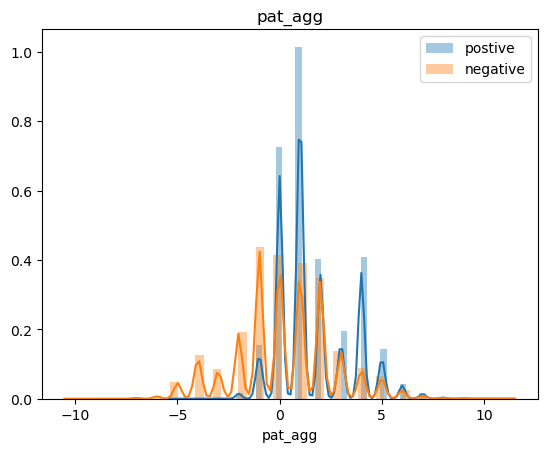

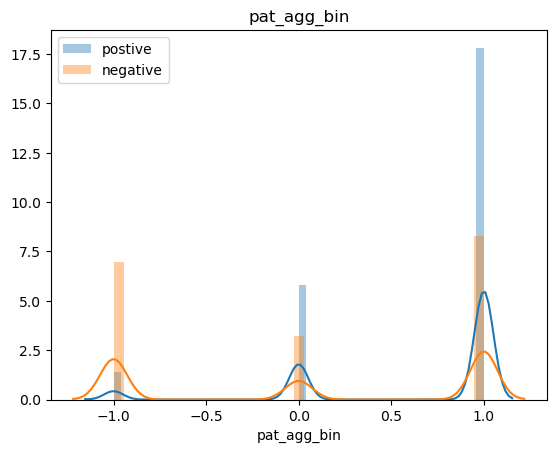

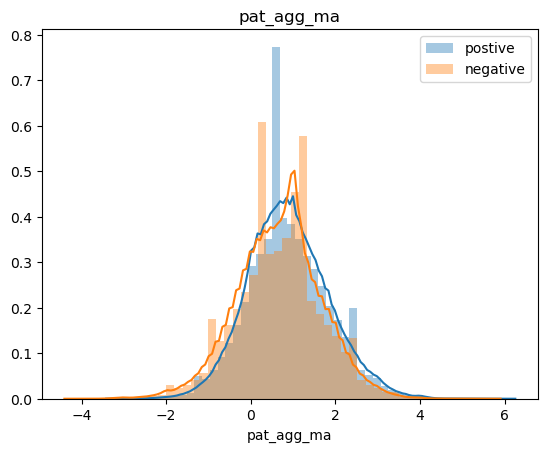

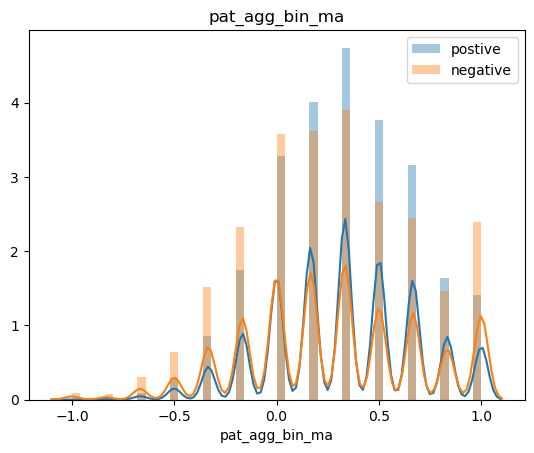

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


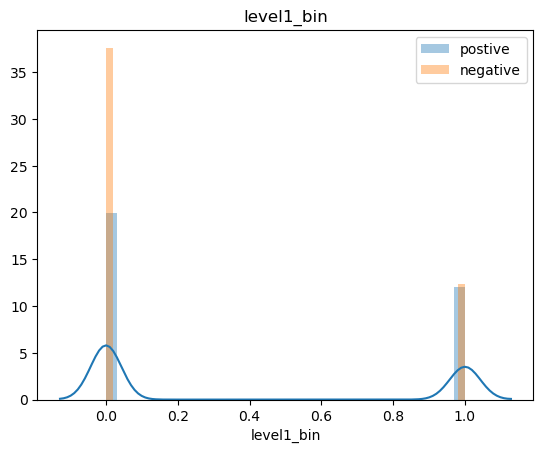

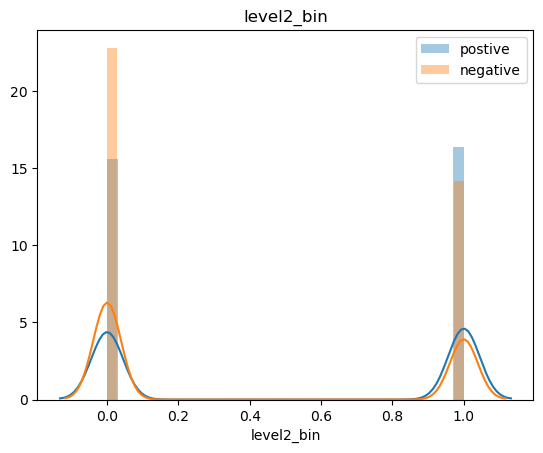

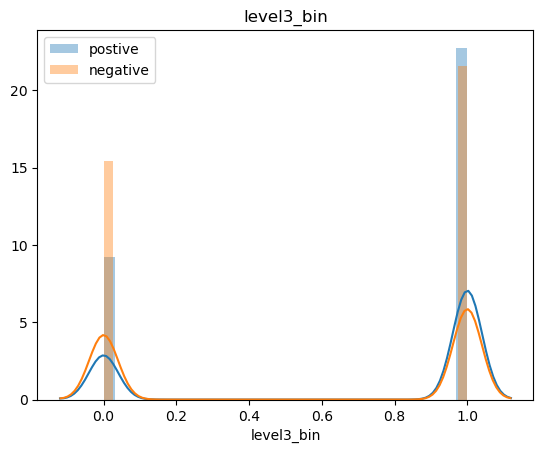

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


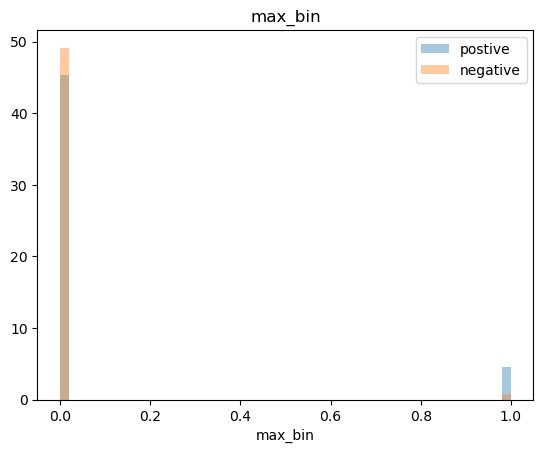

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


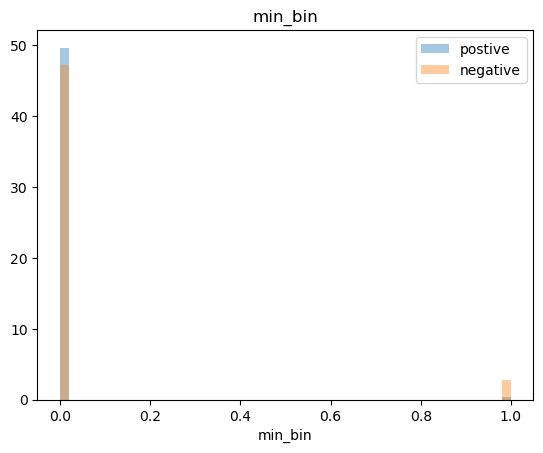

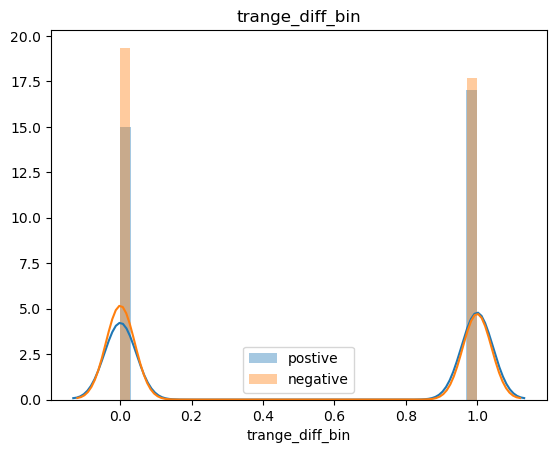

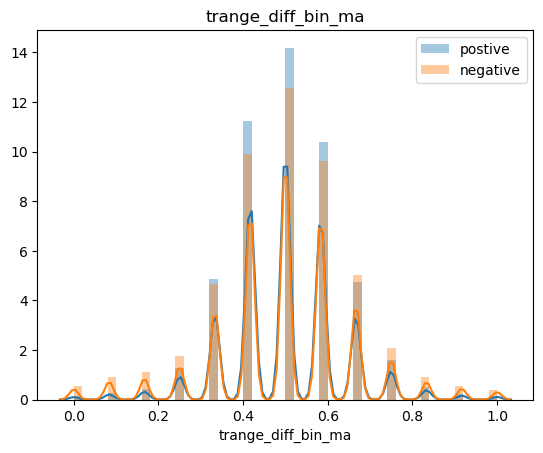

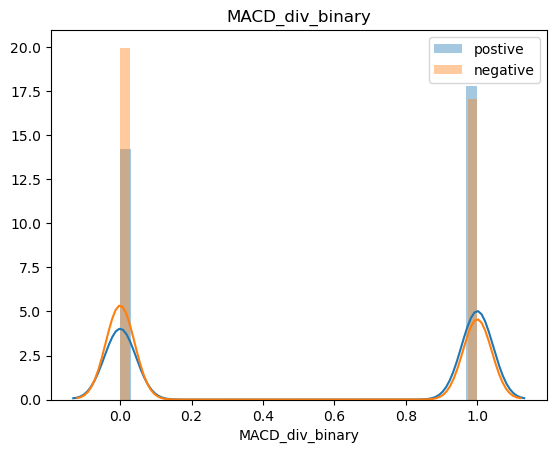

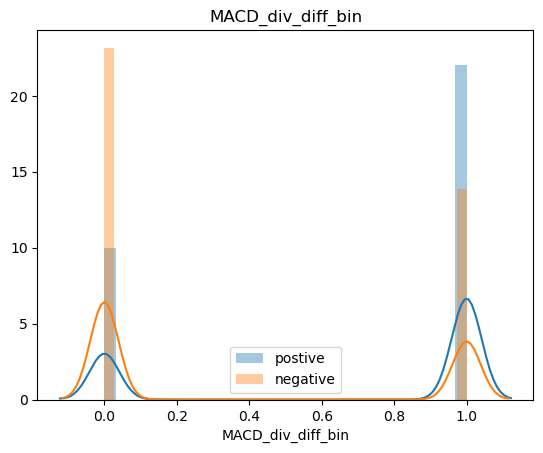

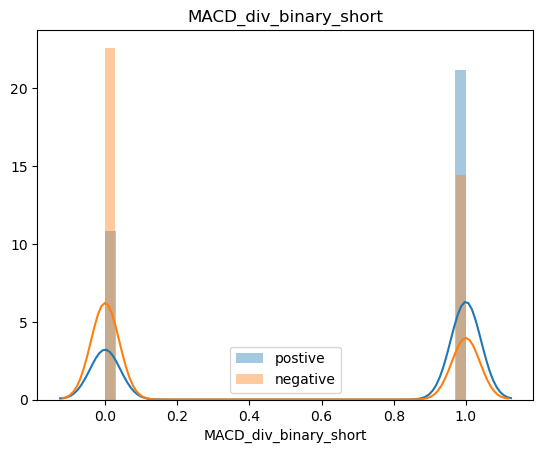

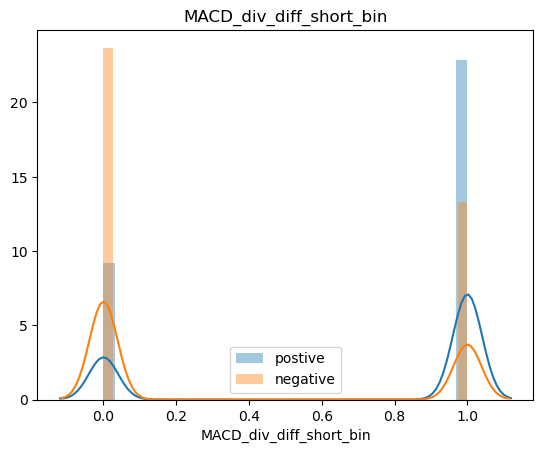

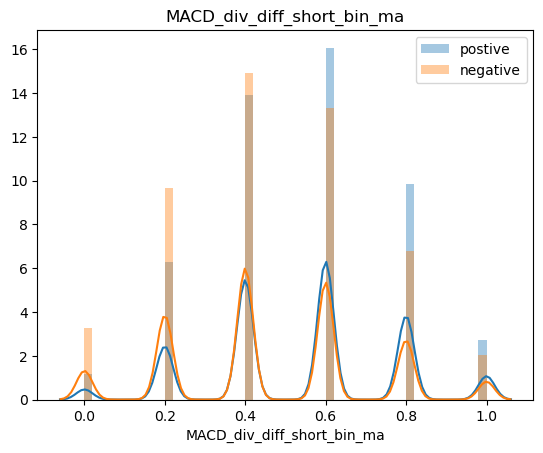

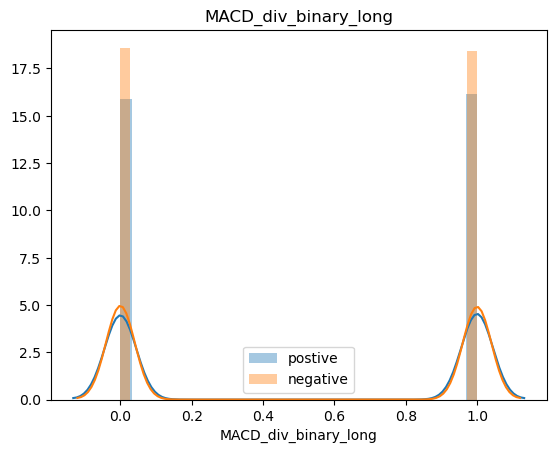

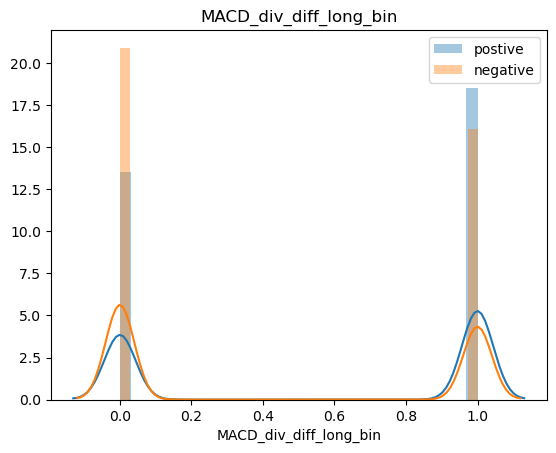

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


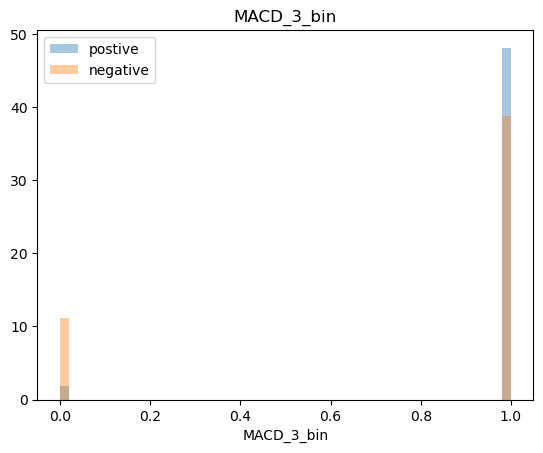

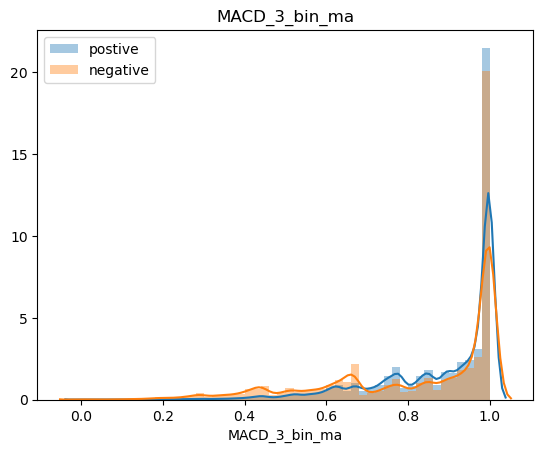

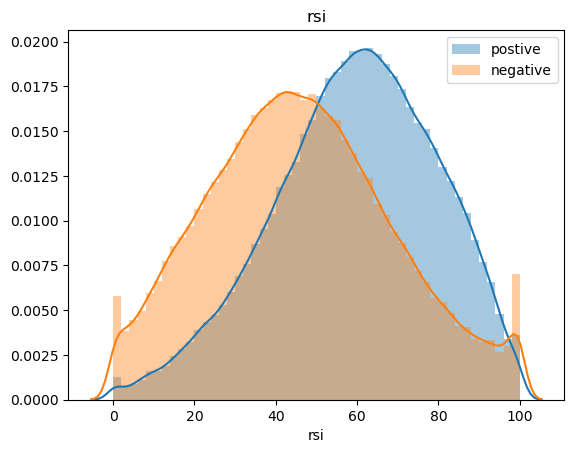

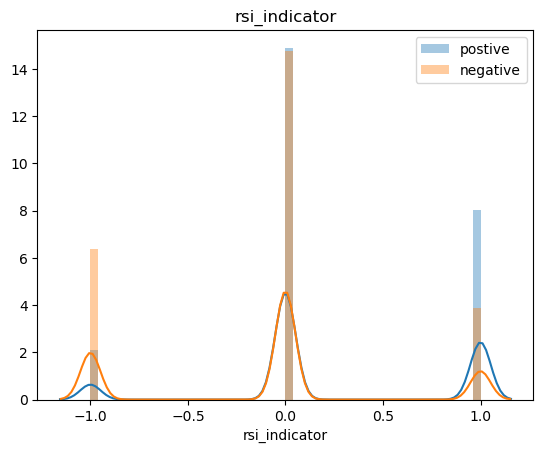

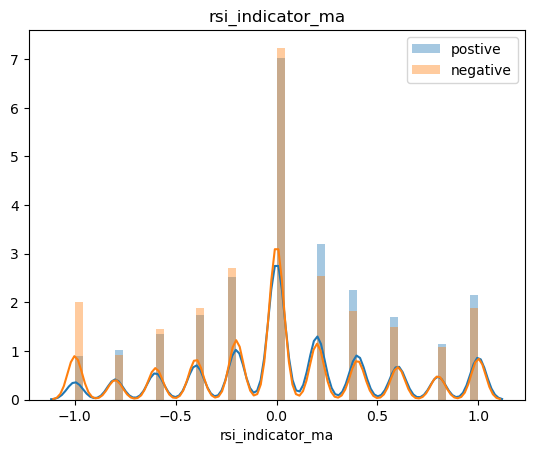

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


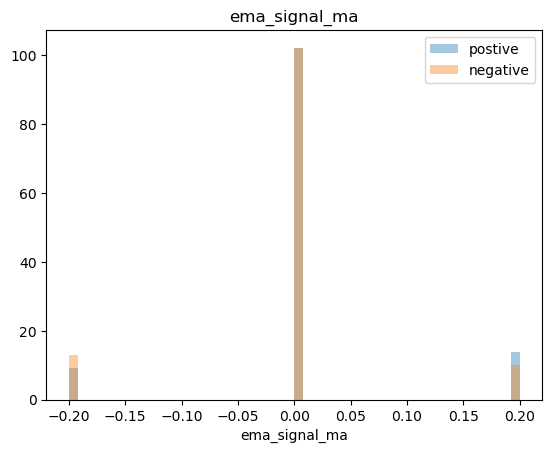

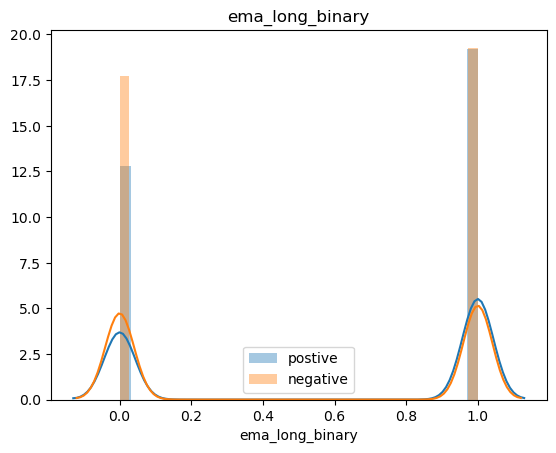

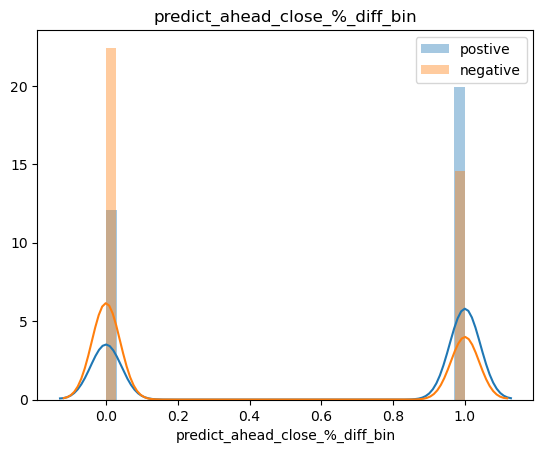

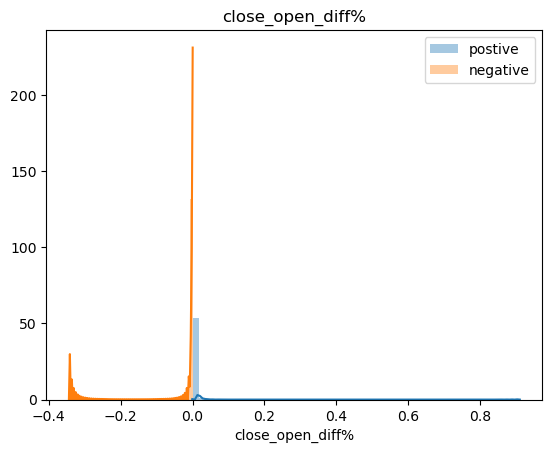

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


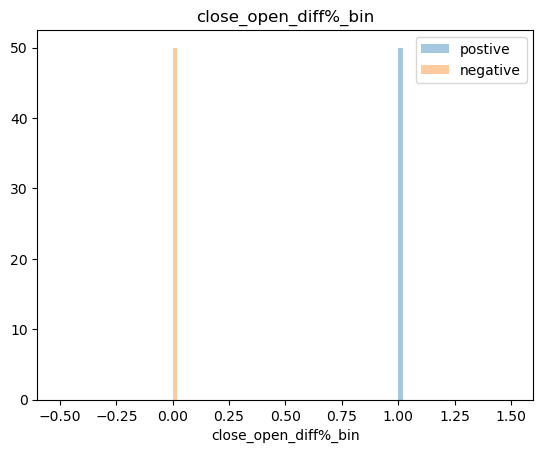

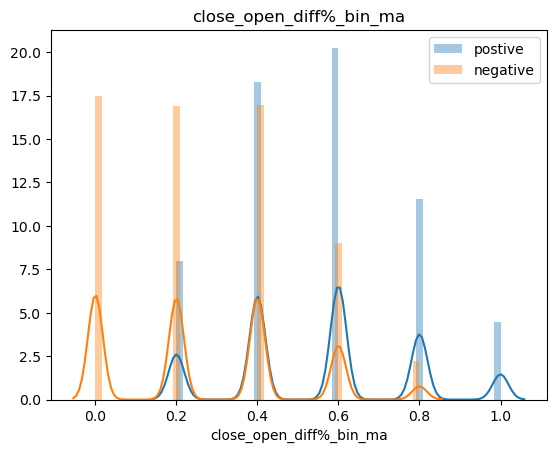

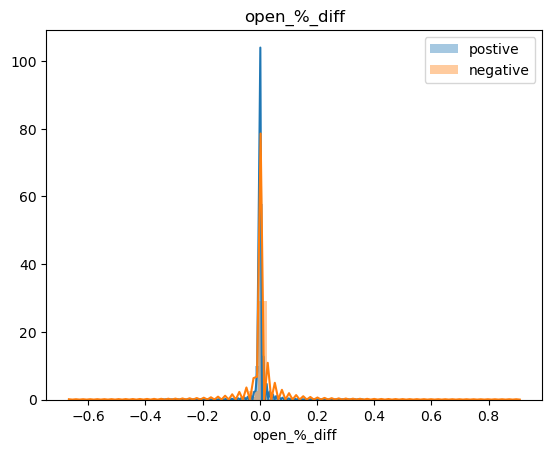

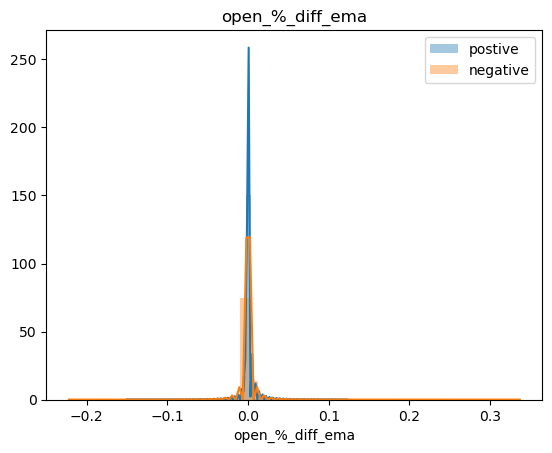

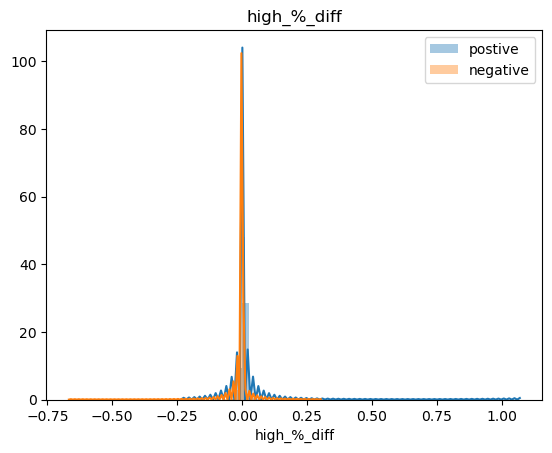

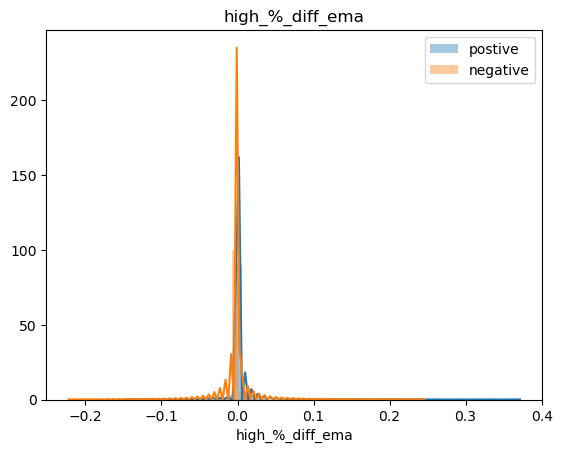

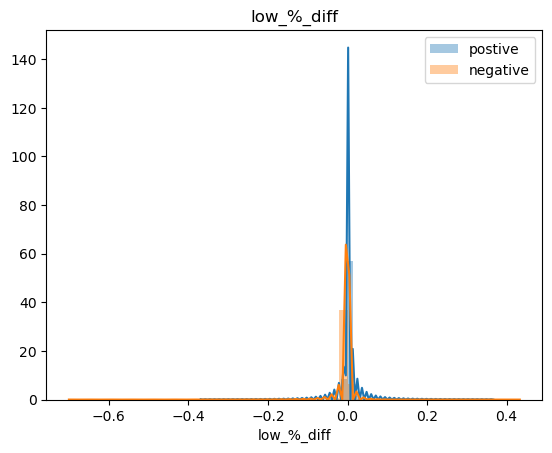

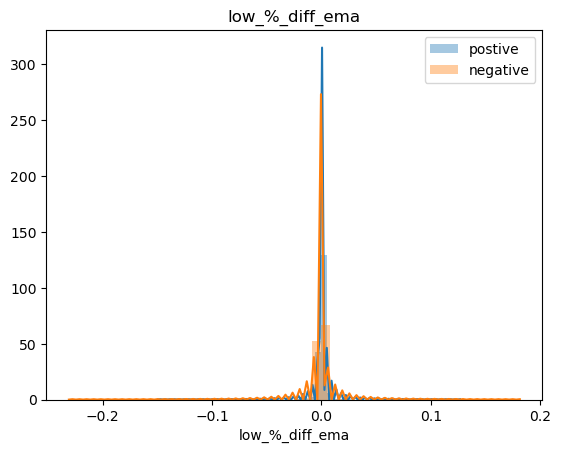

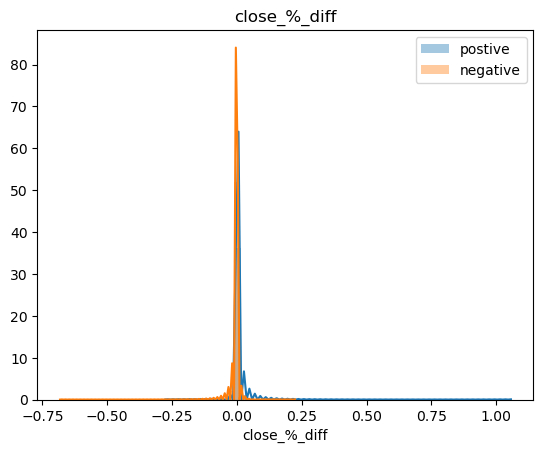

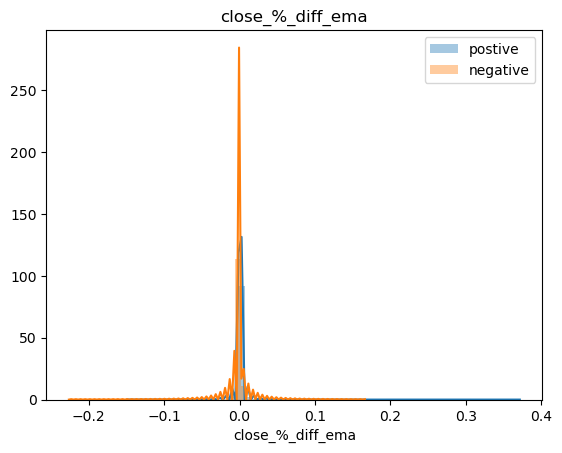

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


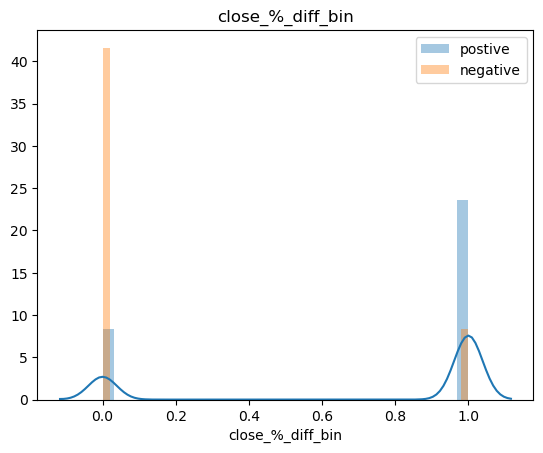

In [18]:
for x in data.columns[:-1]:
    sns.distplot(data[x][data['close_open_diff%_bin']==1],label='postive')
    sns.distplot(data[x][data['close_open_diff%_bin']==0],label='negative')
    plt.legend()
    plt.title(x)
    plt.show()

The graphs do show clear patterns between several features with whether that time period went up or down, but that pattern disappears when applied to following time period.

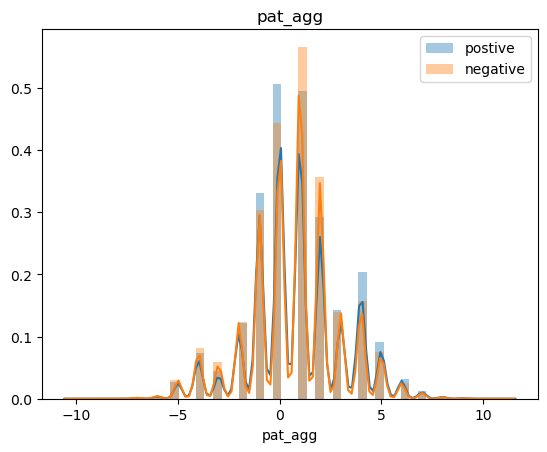

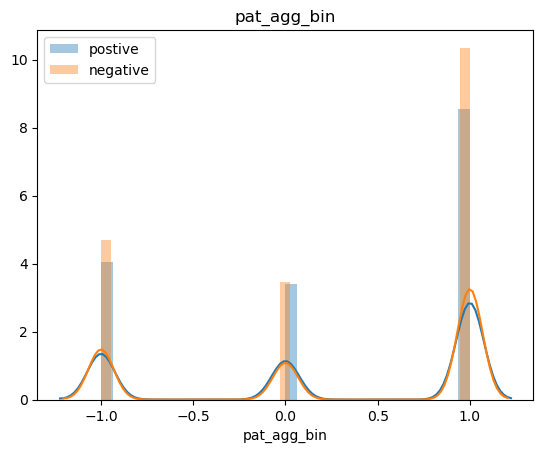

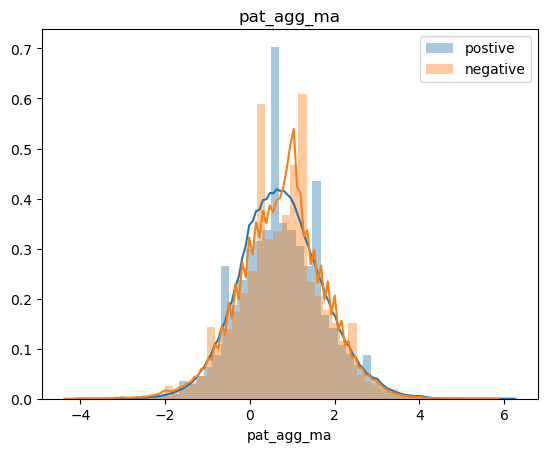

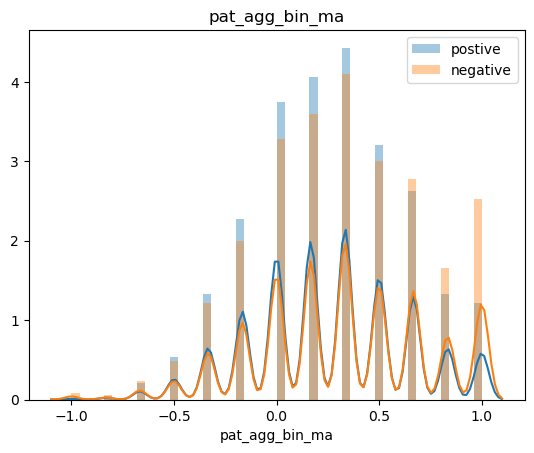

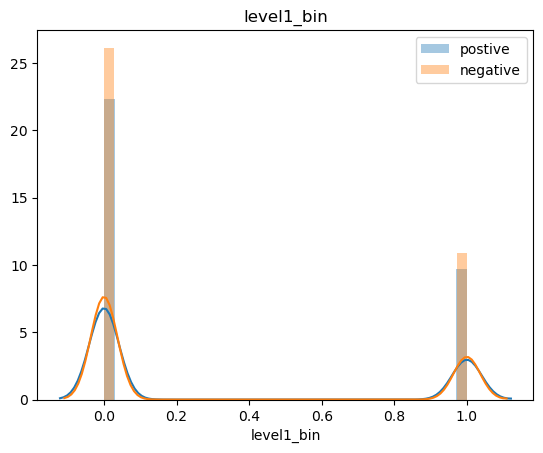

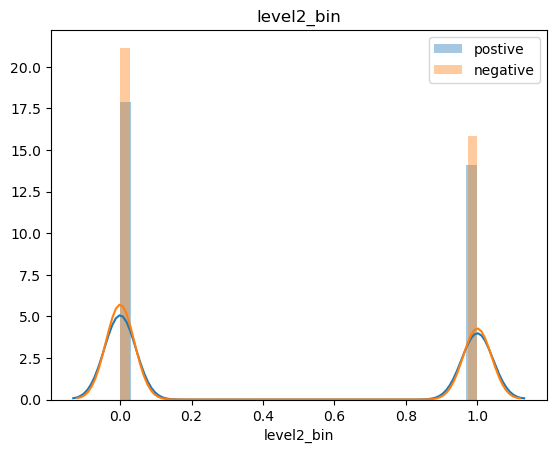

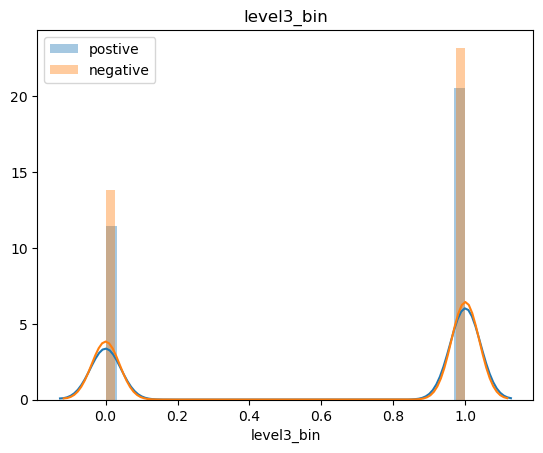

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


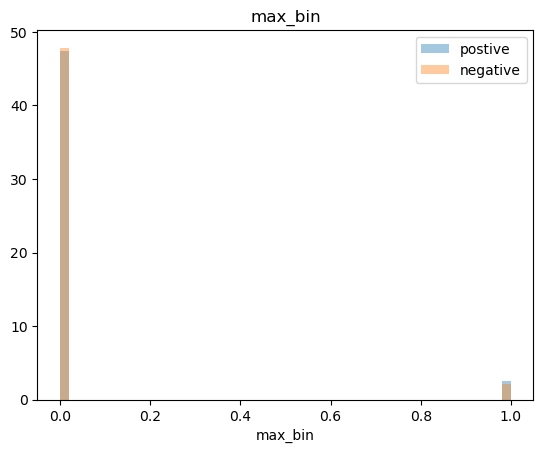

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


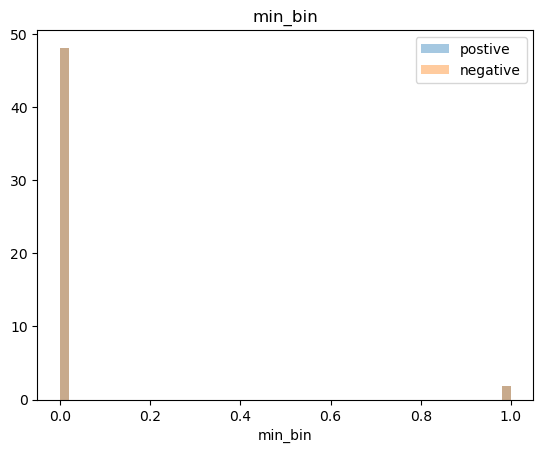

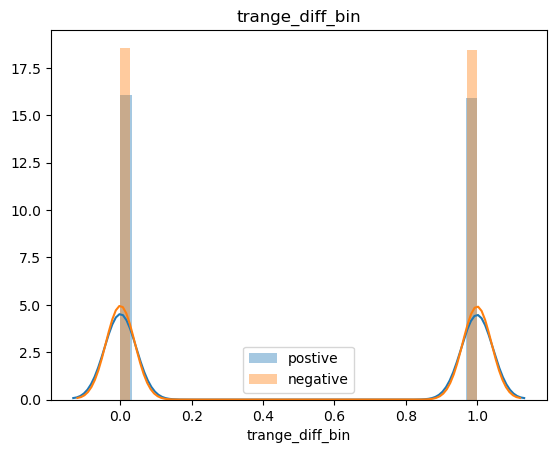

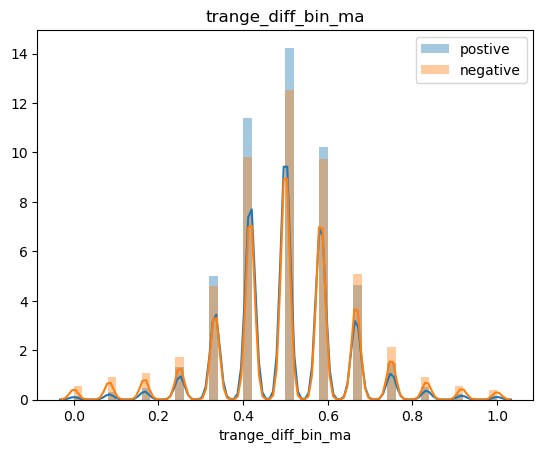

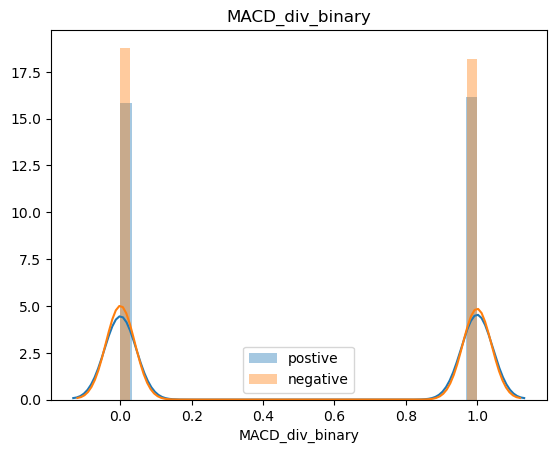

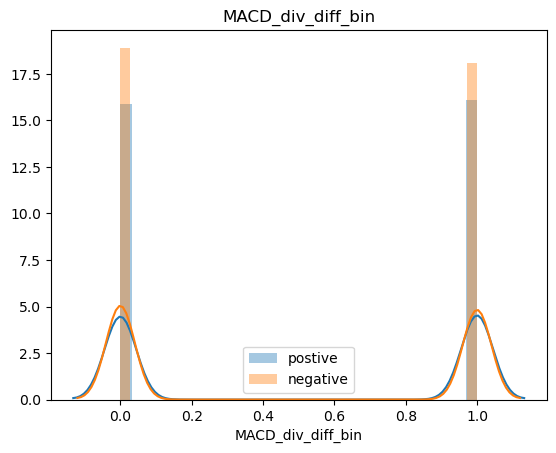

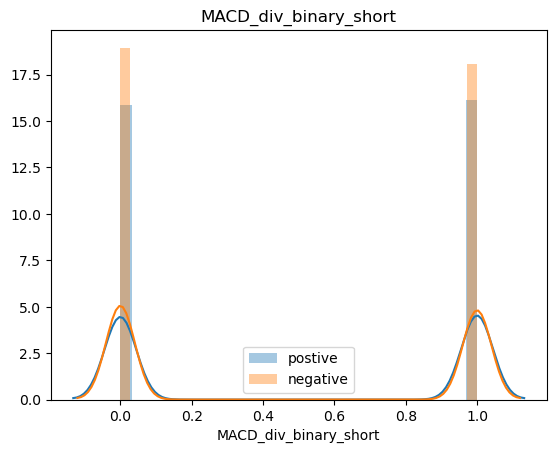

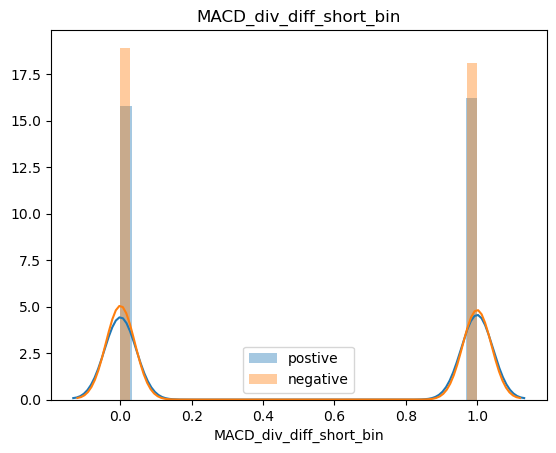

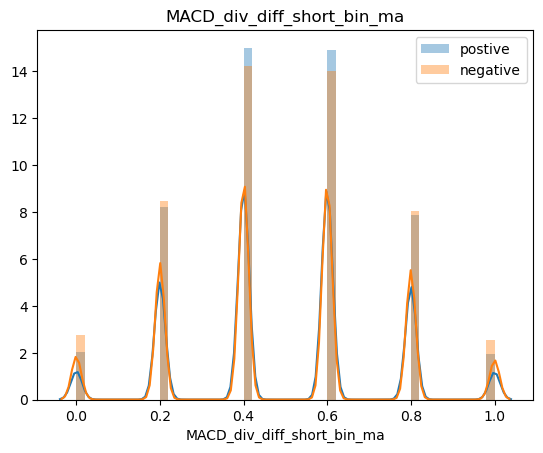

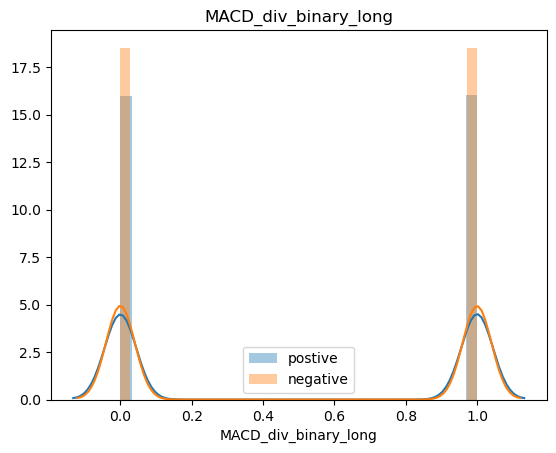

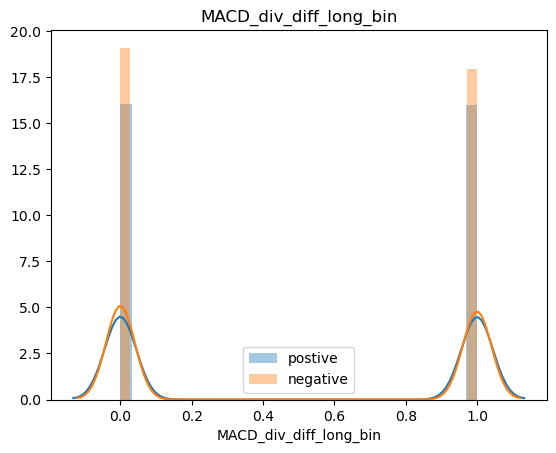

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


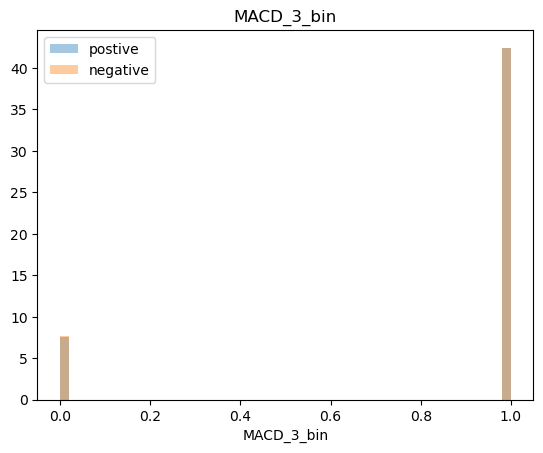

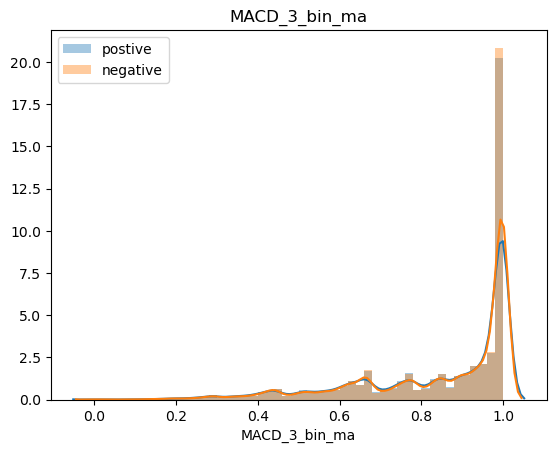

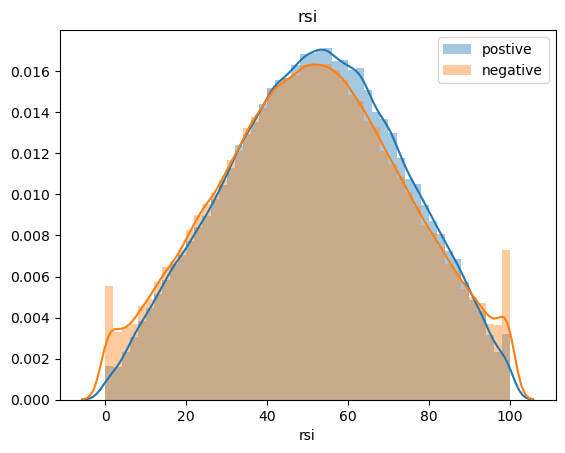

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


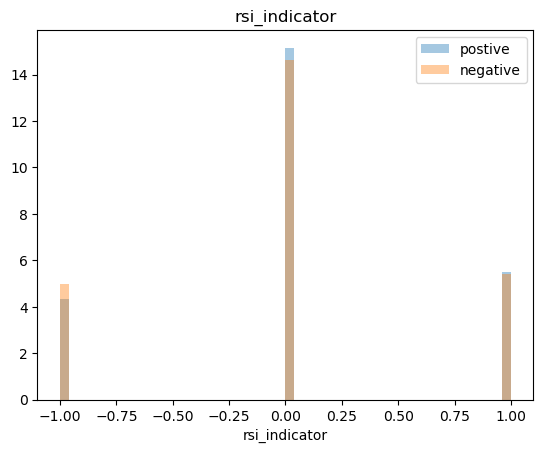

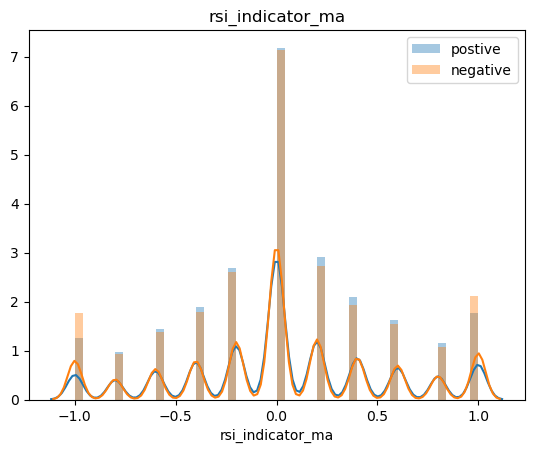

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


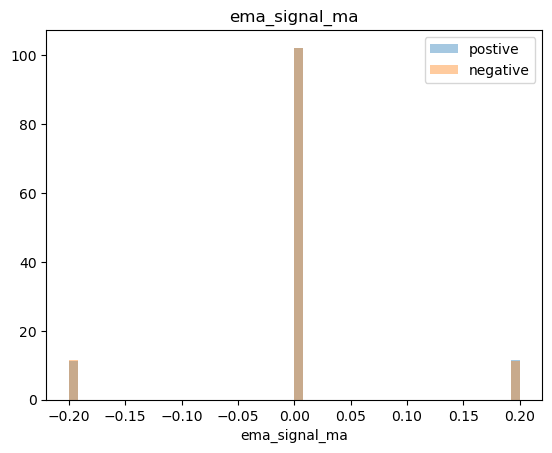

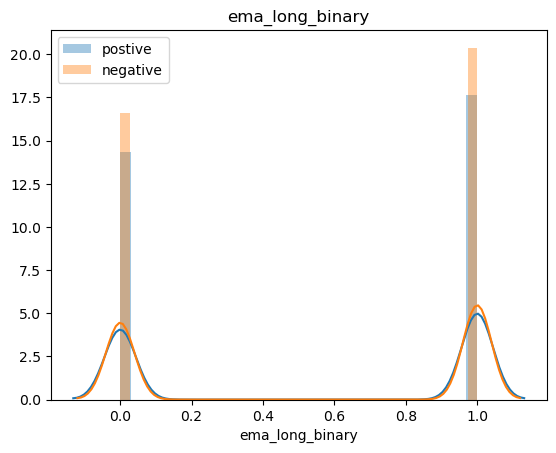

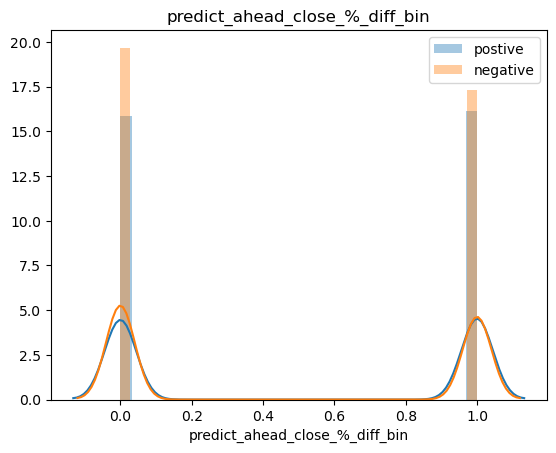

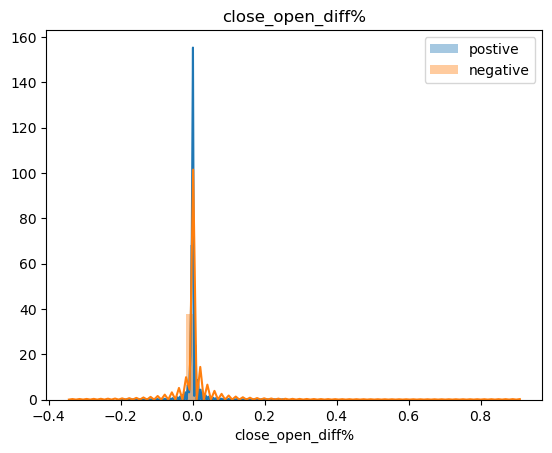

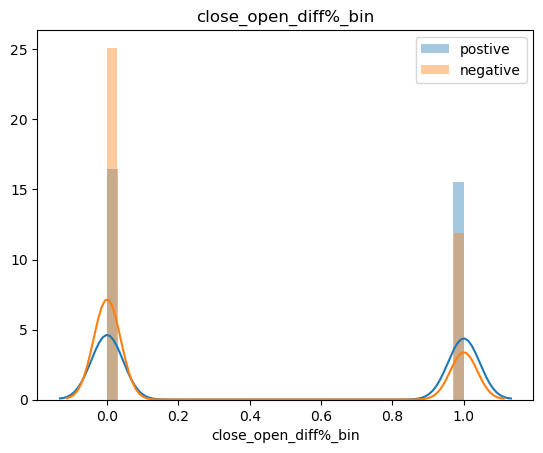

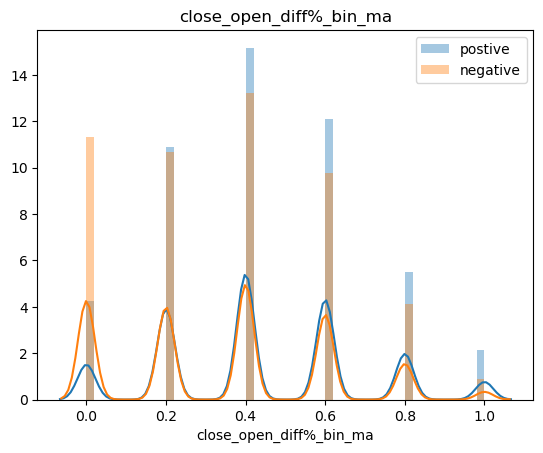

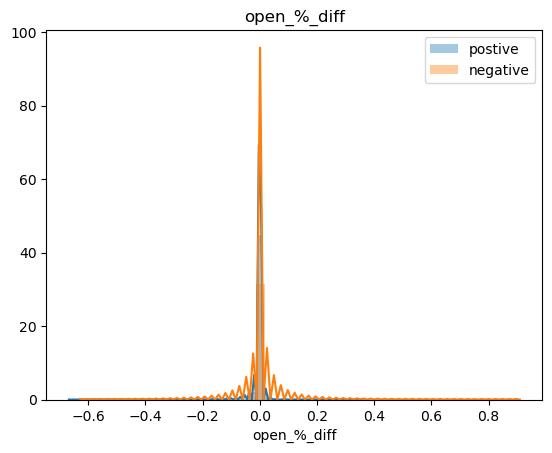

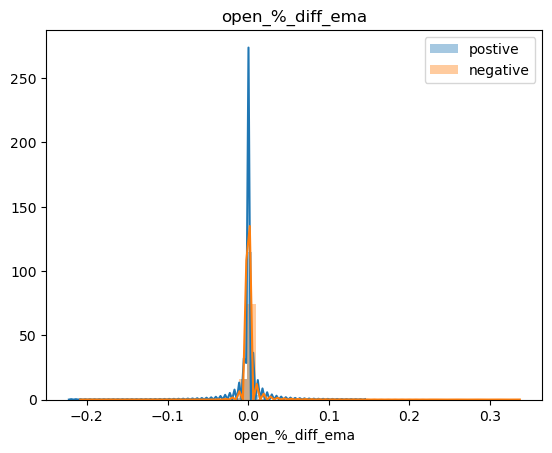

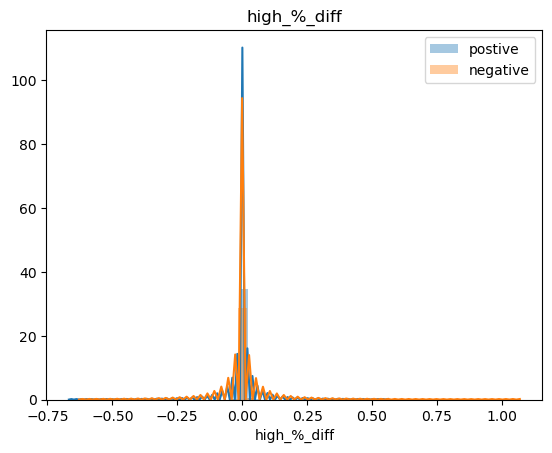

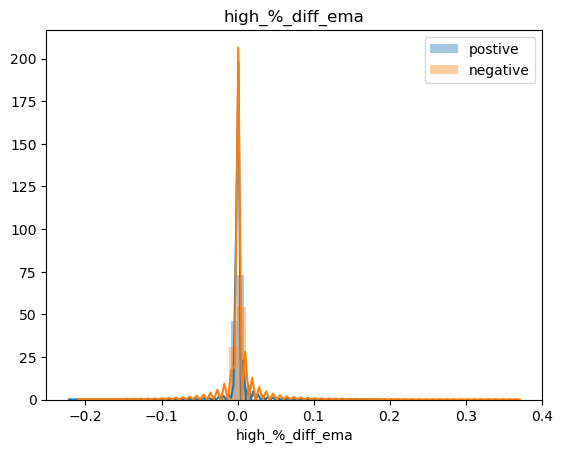

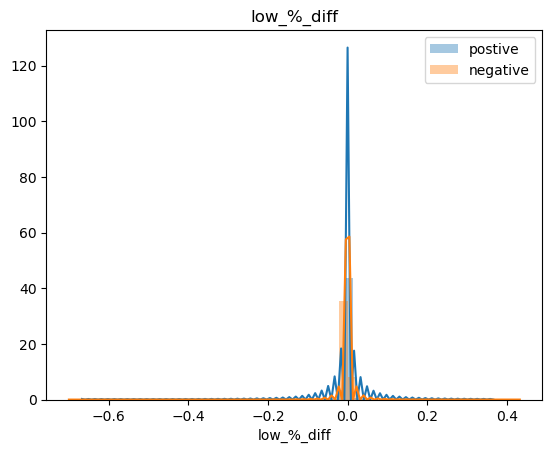

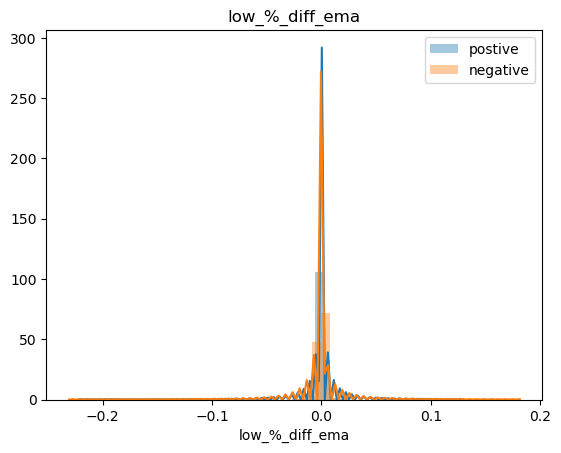

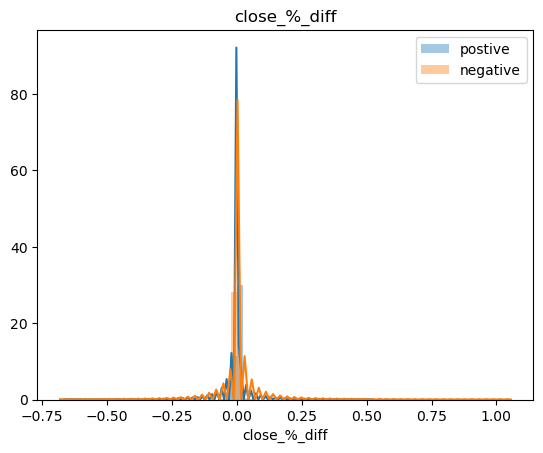

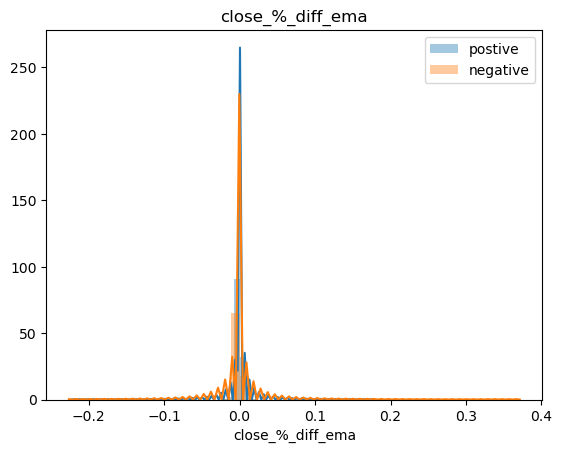

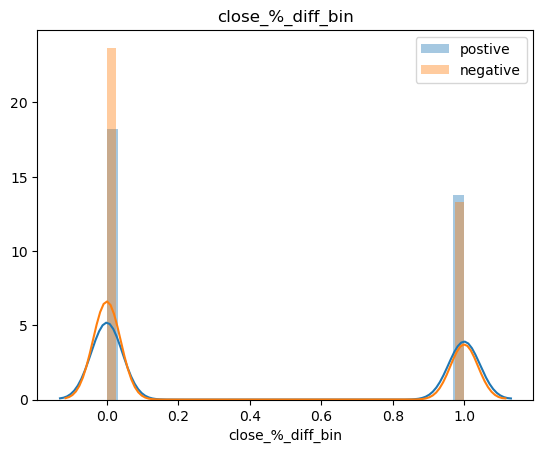

In [19]:
for x in data.columns[:-1]:
    sns.distplot(data[x][data['close_open_diff%_bin'].shift(-1)==1],label='postive')
    sns.distplot(data[x][data['close_open_diff%_bin'].shift(-1)==0],label='negative')
    plt.legend()
    plt.title(x)
    plt.show()

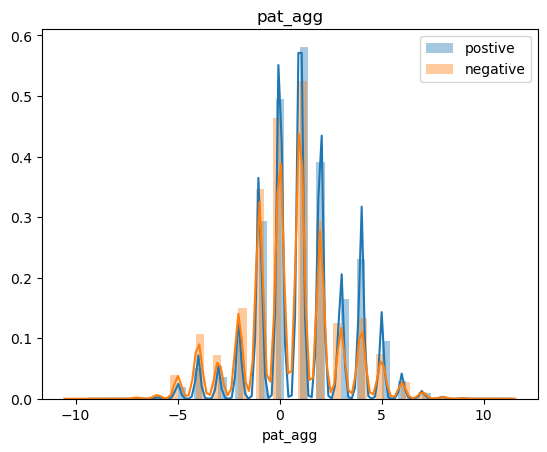

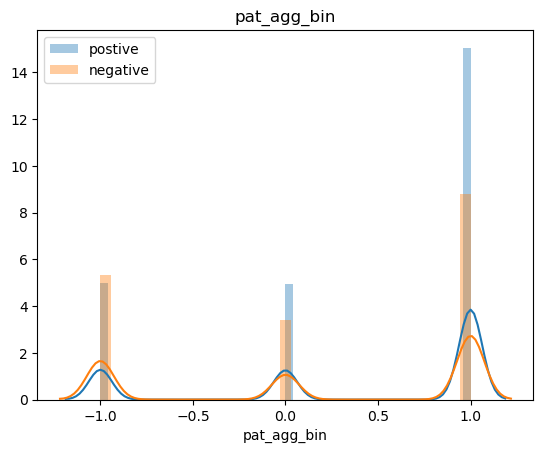

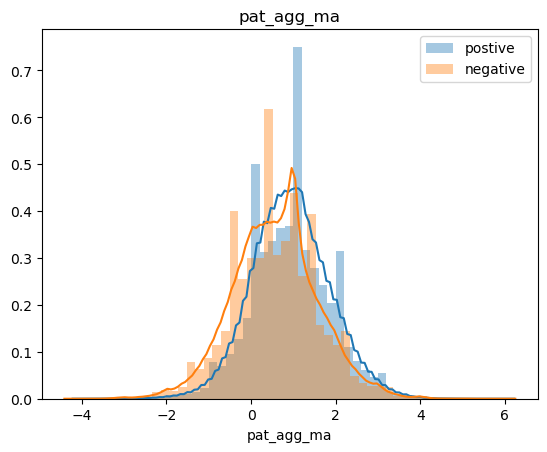

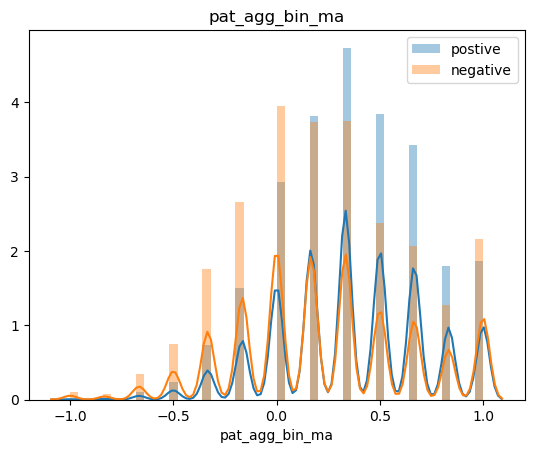

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


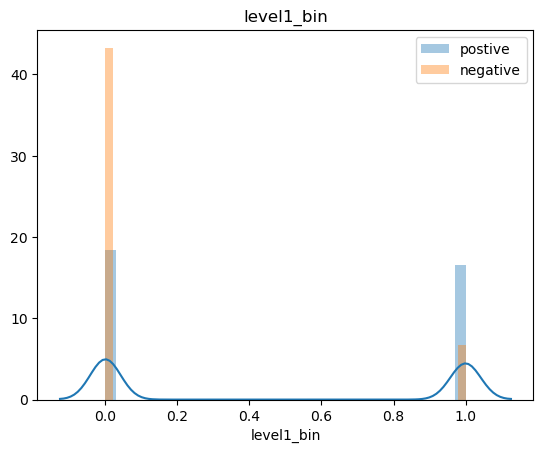

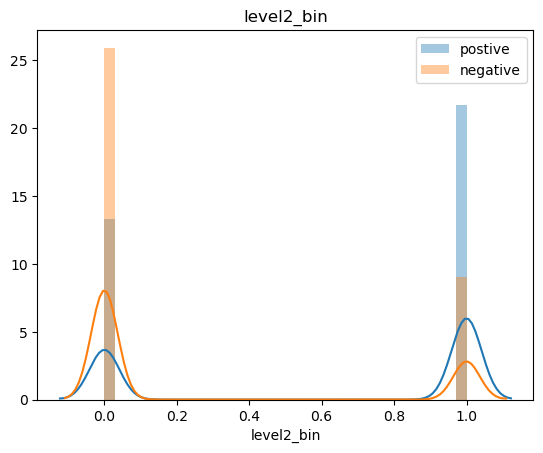

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


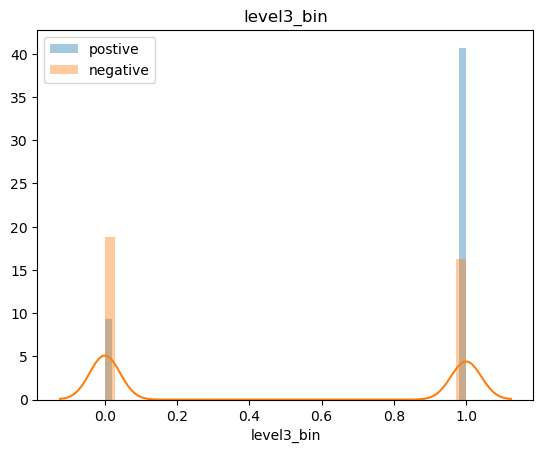

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


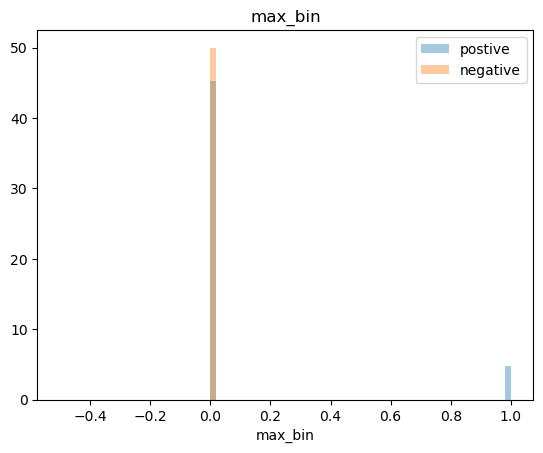

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


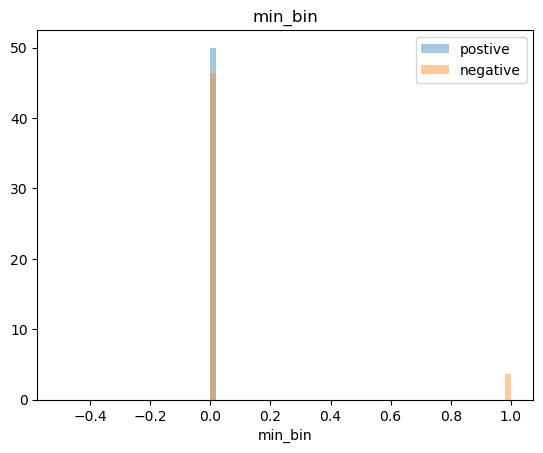

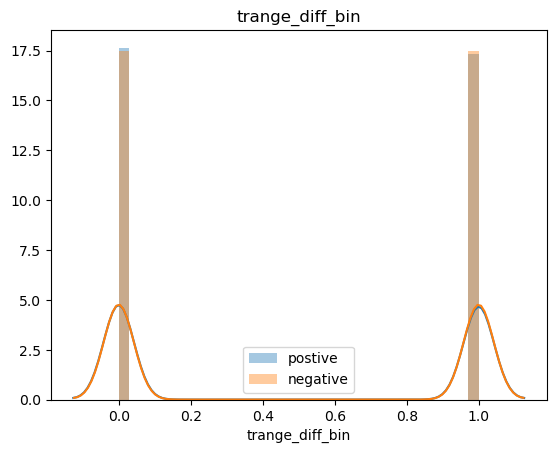

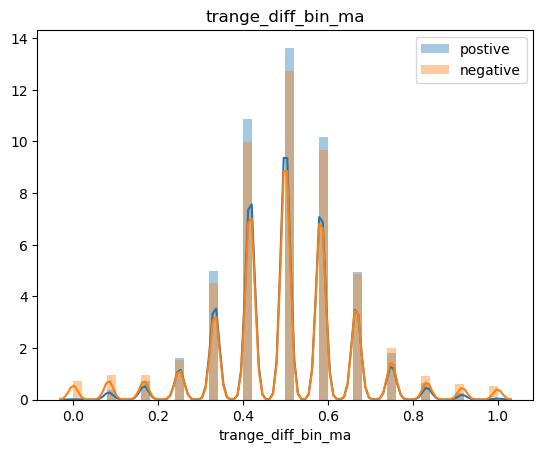

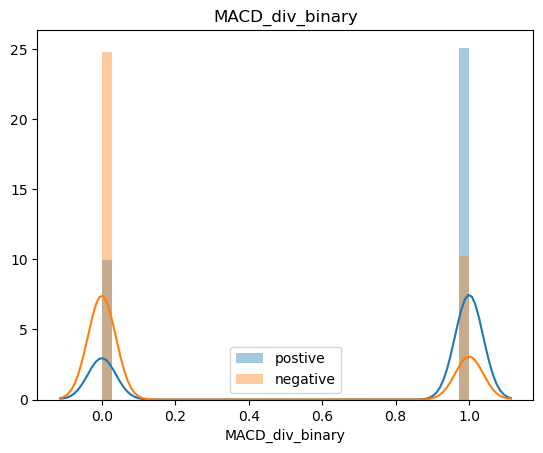

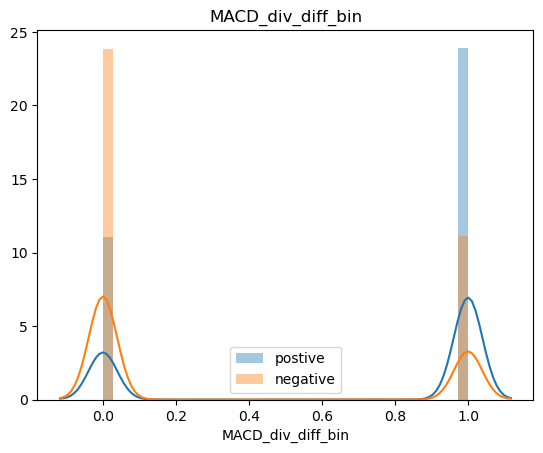

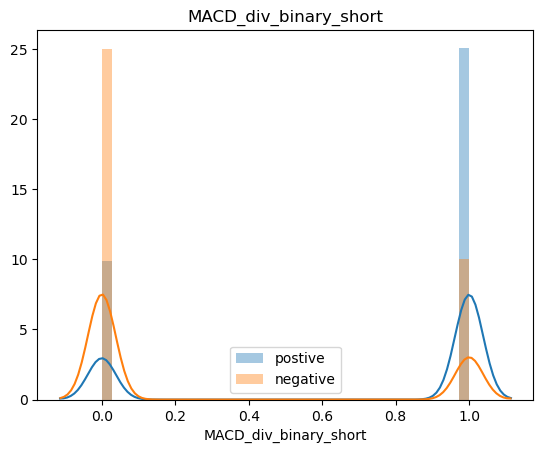

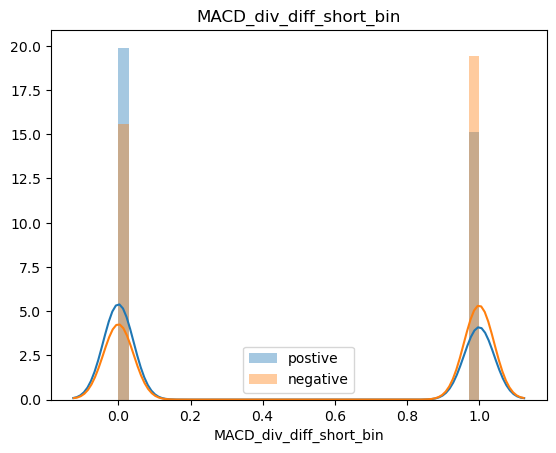

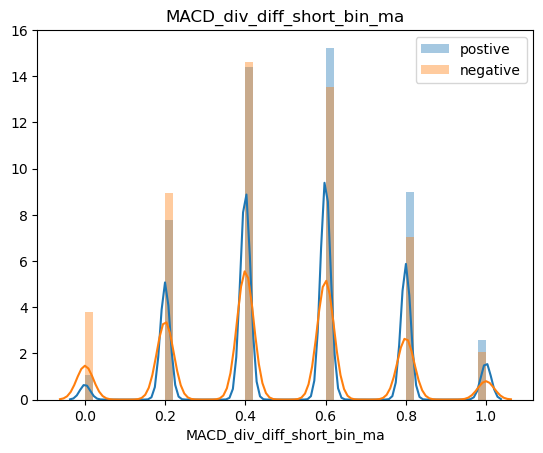

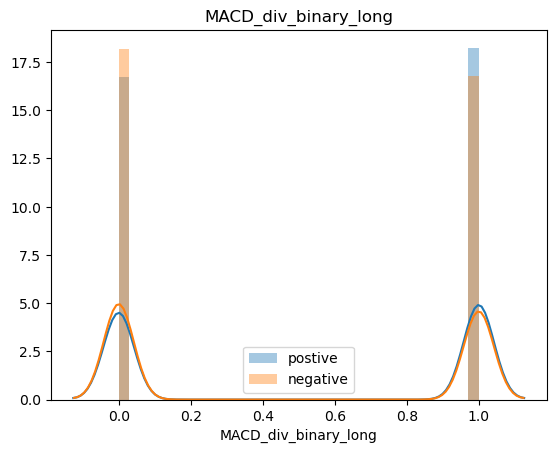

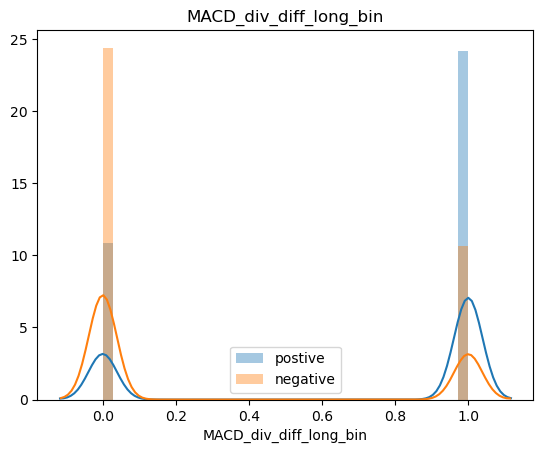

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


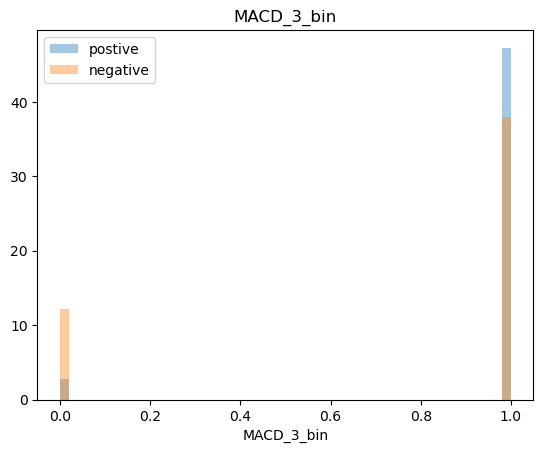

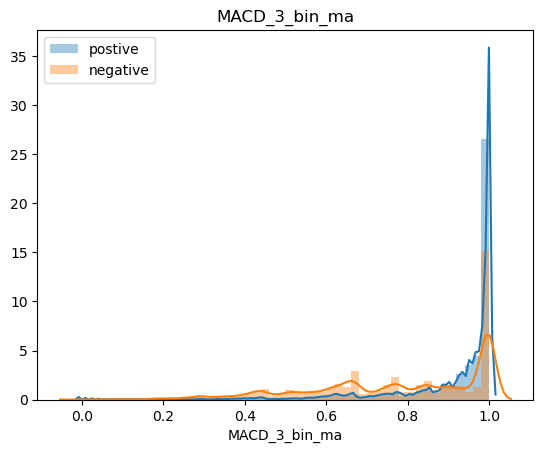

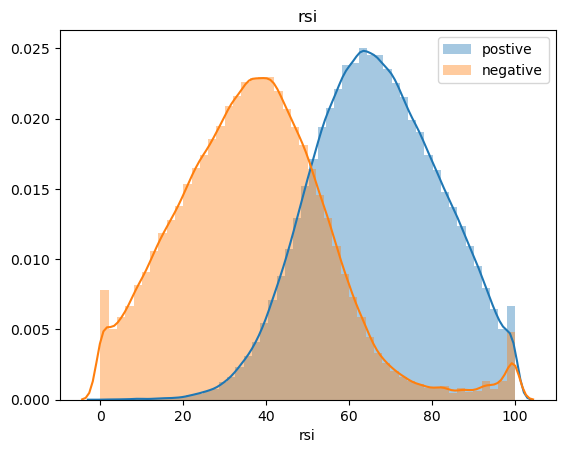

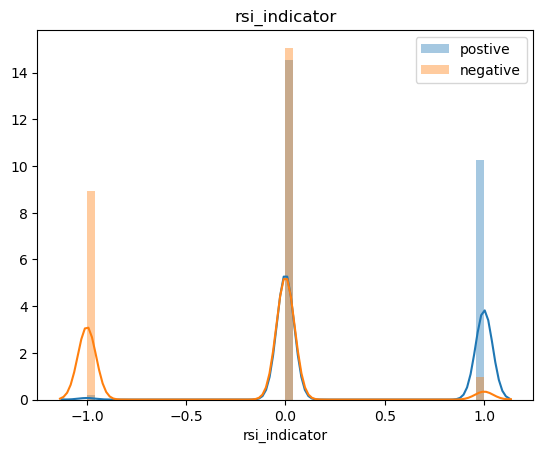

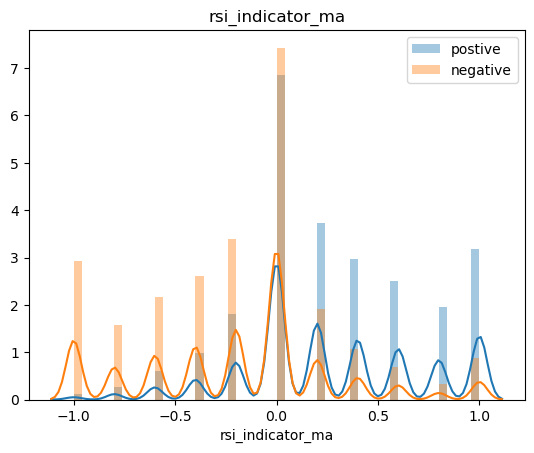

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


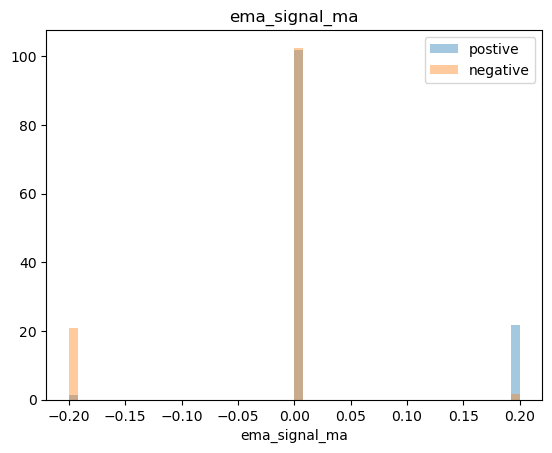

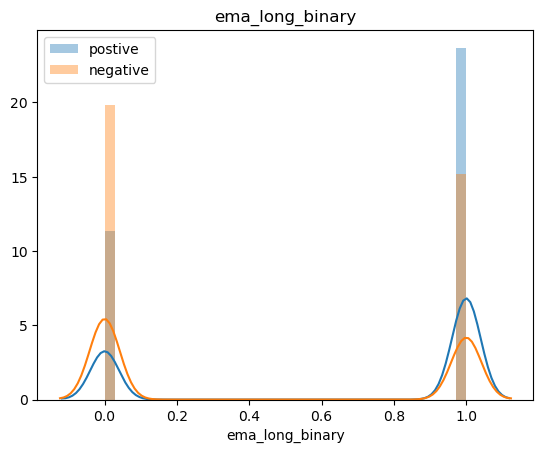

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


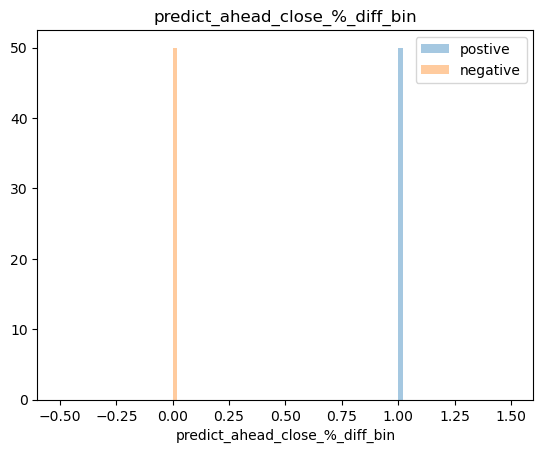

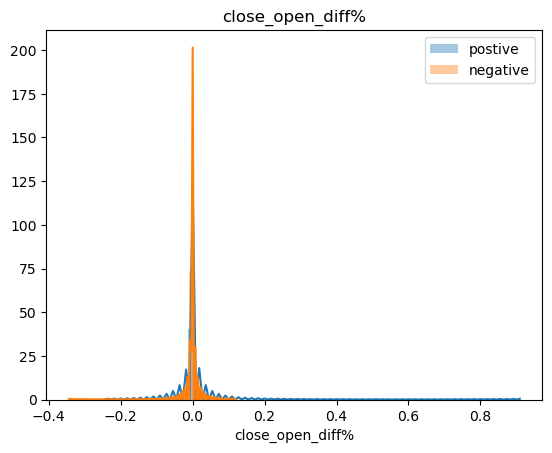

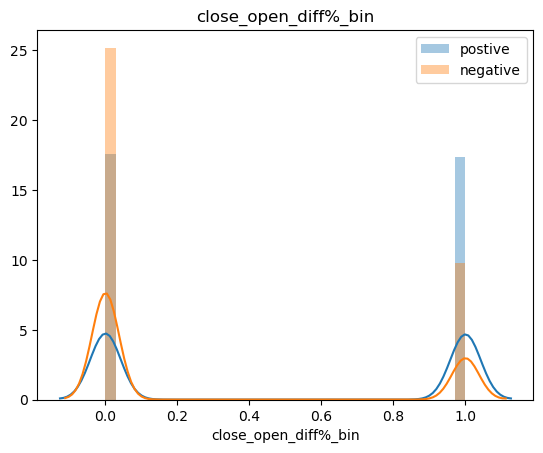

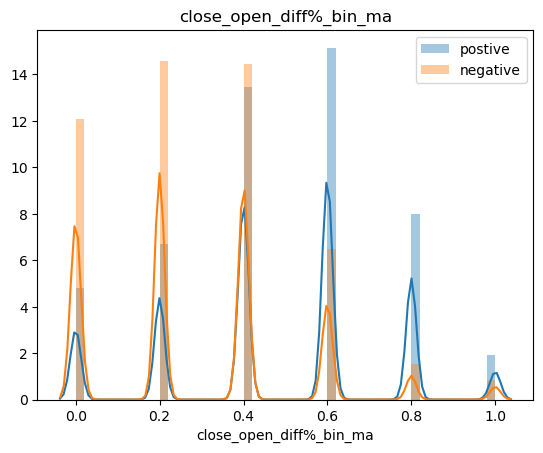

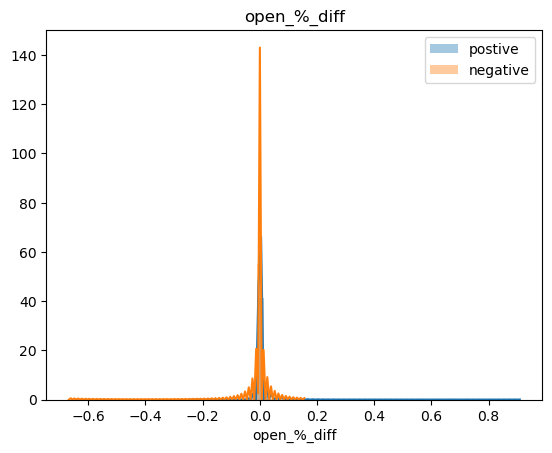

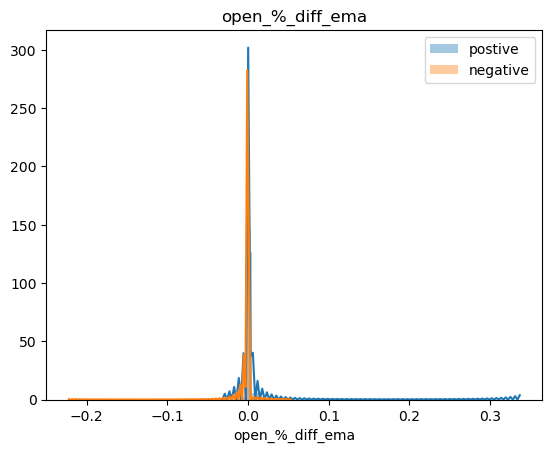

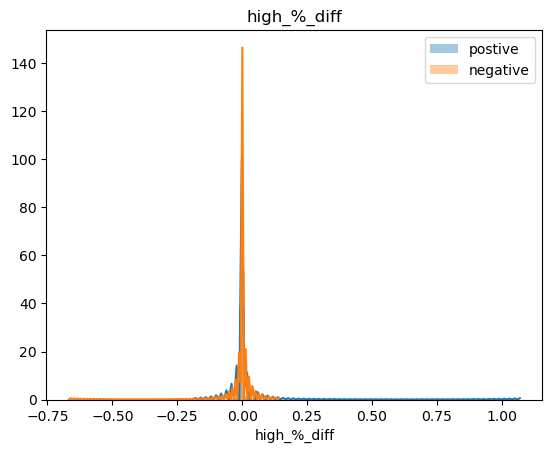

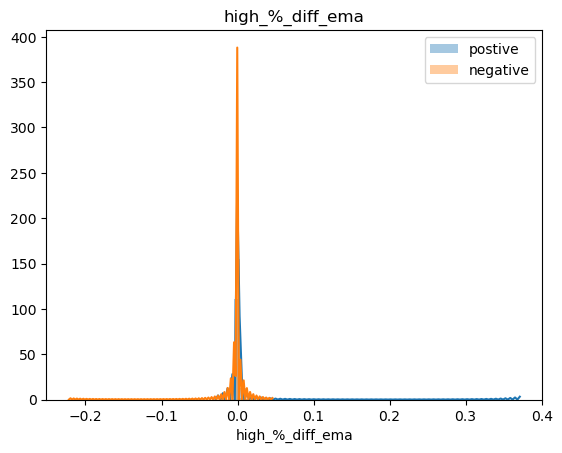

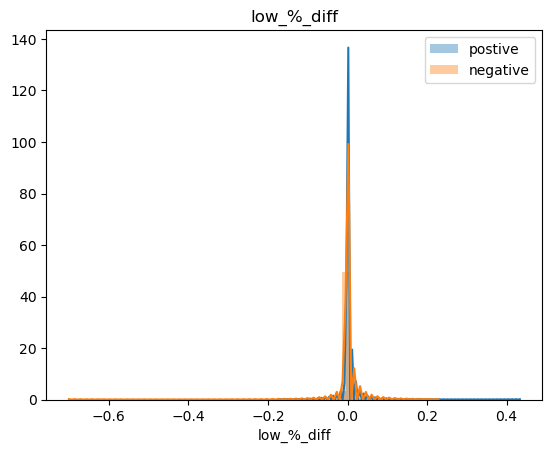

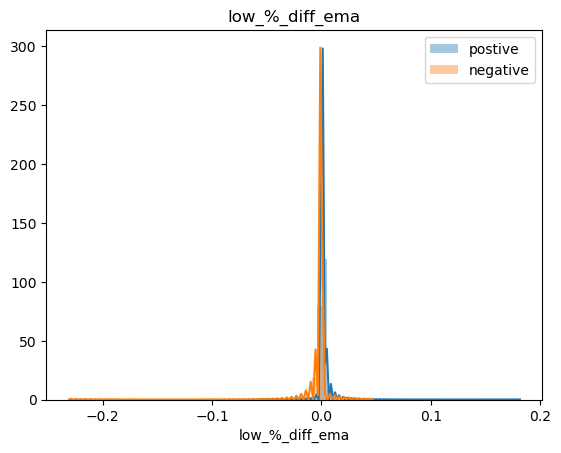

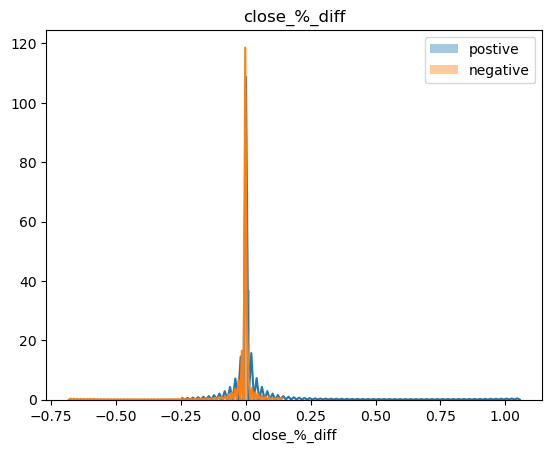

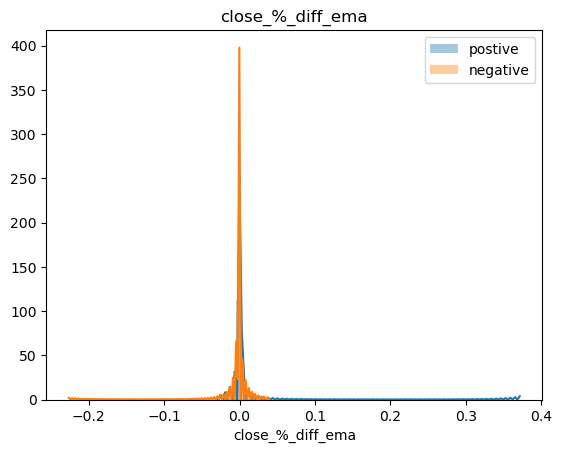

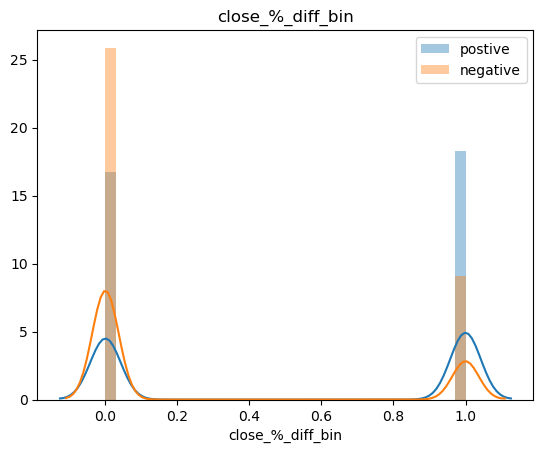

In [20]:
for x in data.columns[:-1]:
    sns.distplot(data[x][data['predict_ahead_close_%_diff_bin']==1],label='postive')
    sns.distplot(data[x][data['predict_ahead_close_%_diff_bin']==0],label='negative')
    plt.legend()
    plt.title(x)
    plt.show()

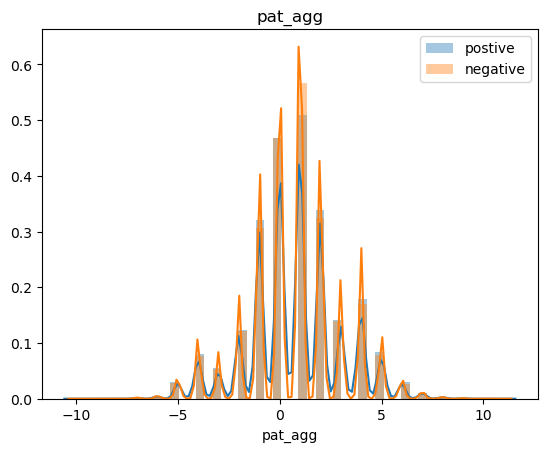

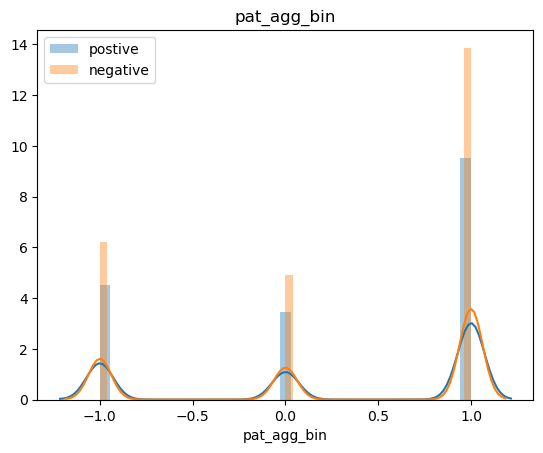

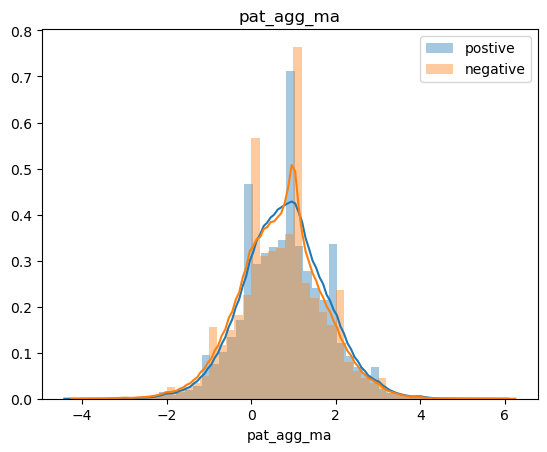

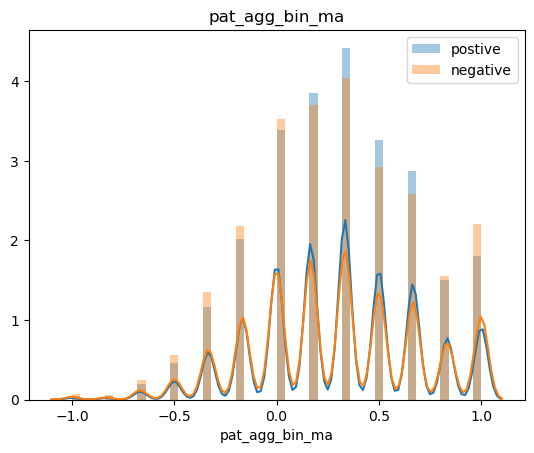

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


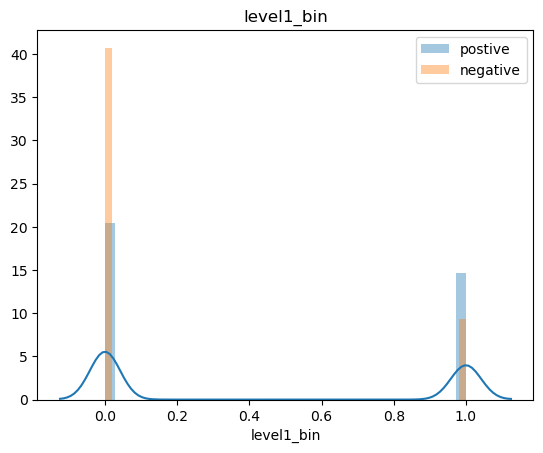

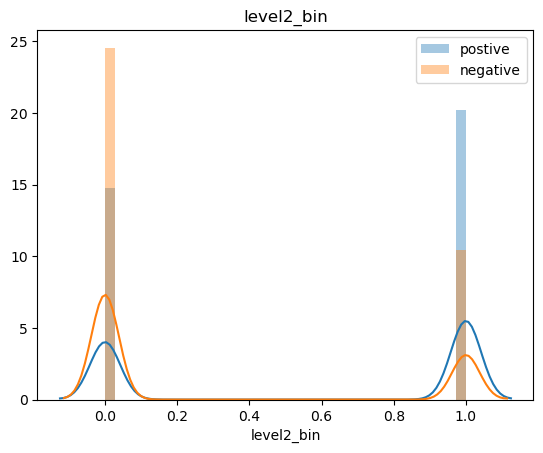

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


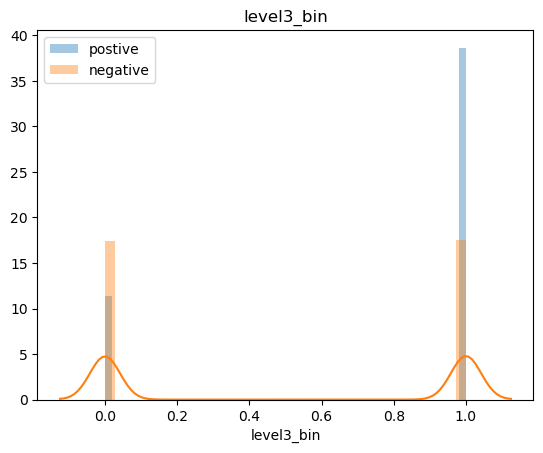

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


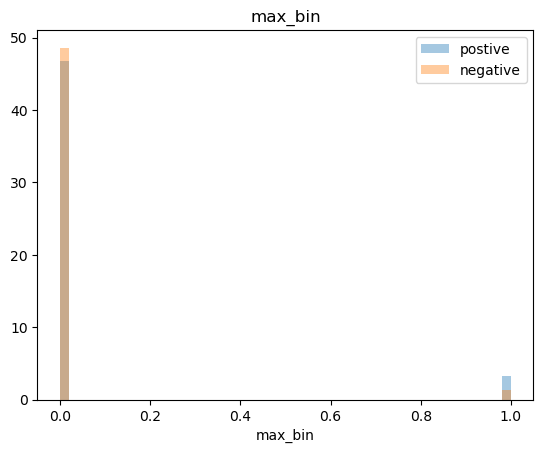

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


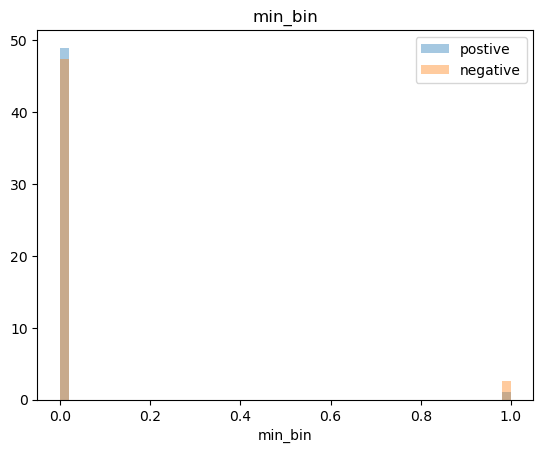

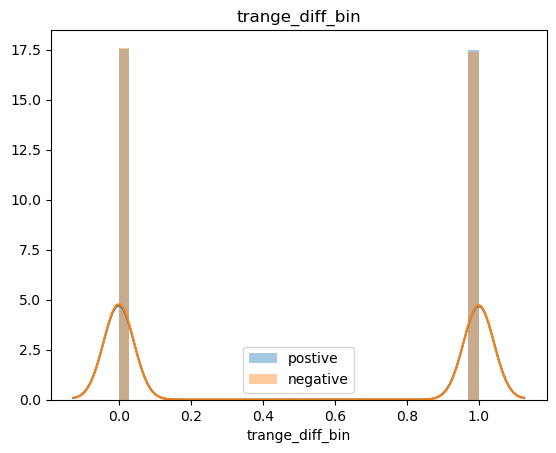

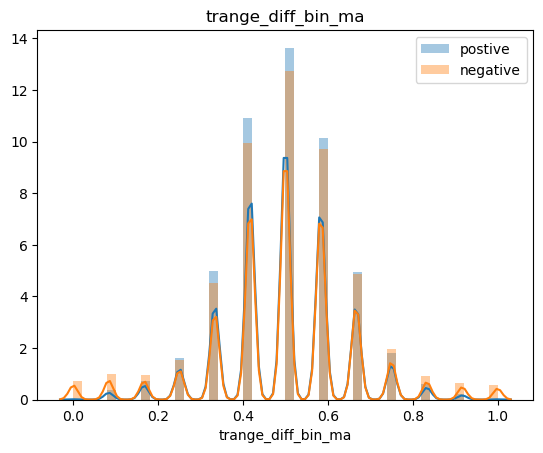

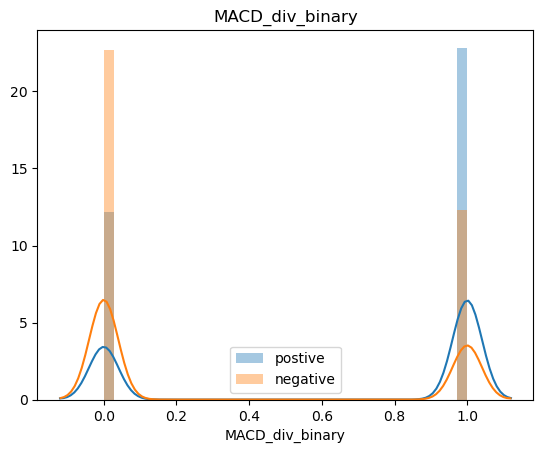

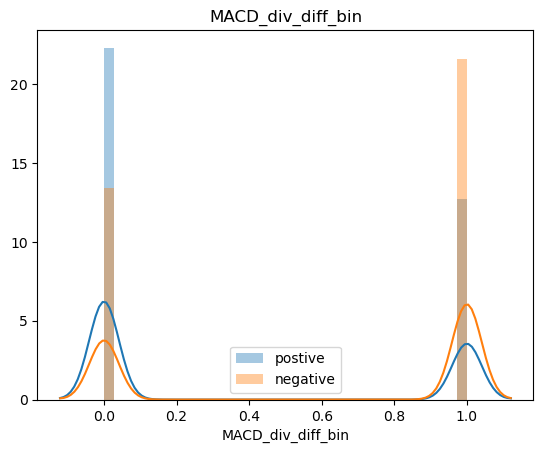

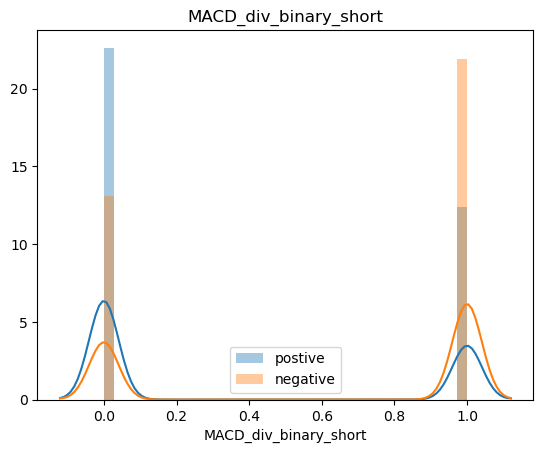

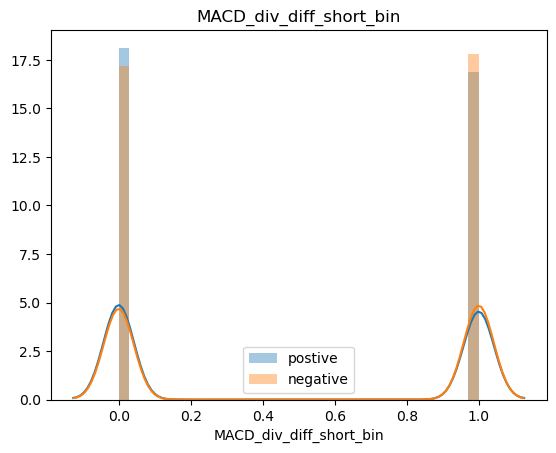

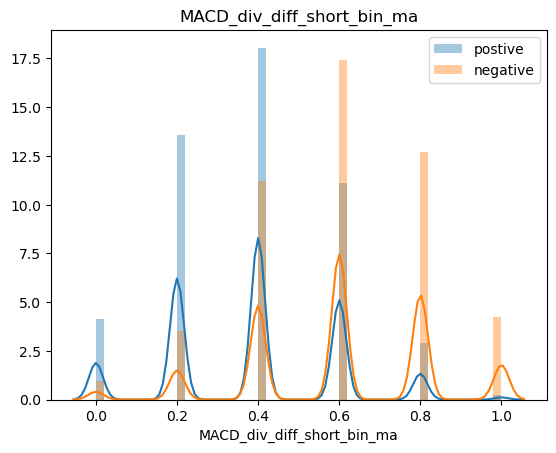

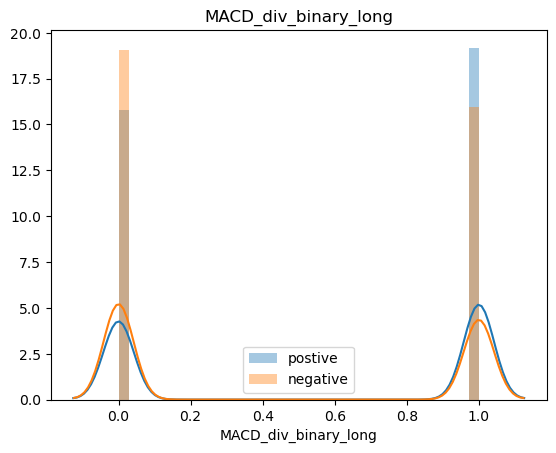

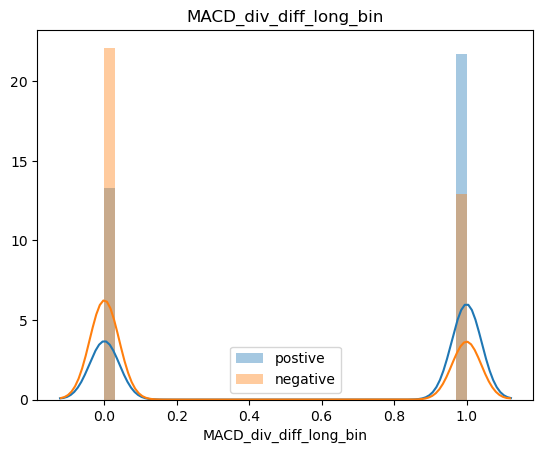

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


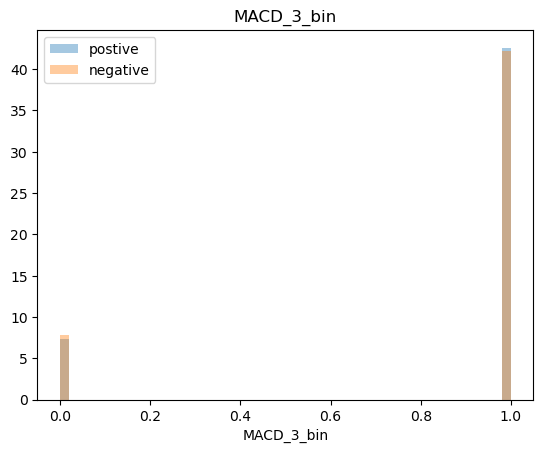

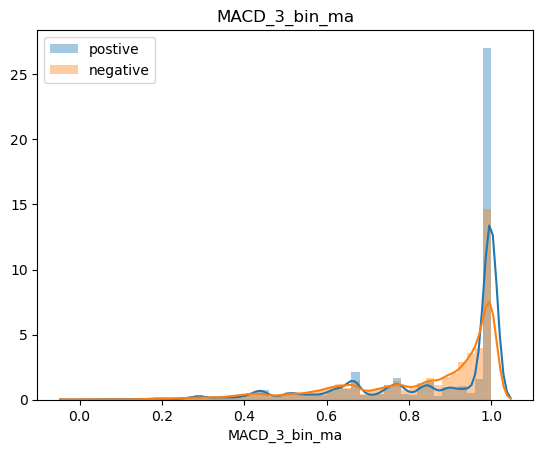

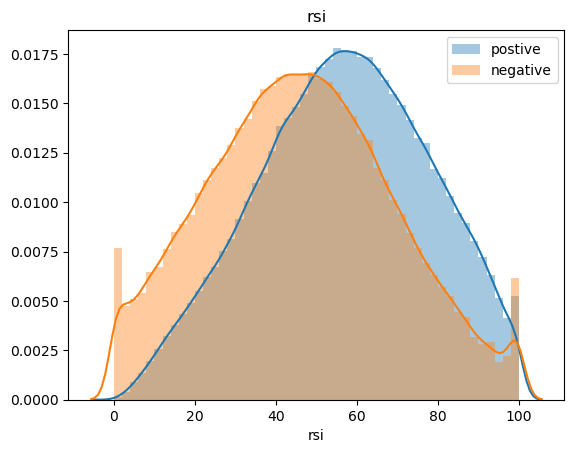

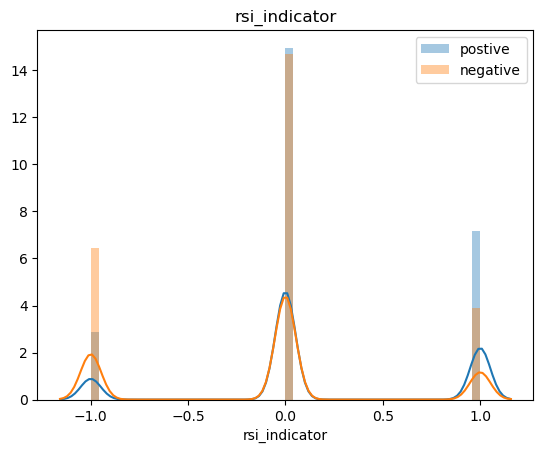

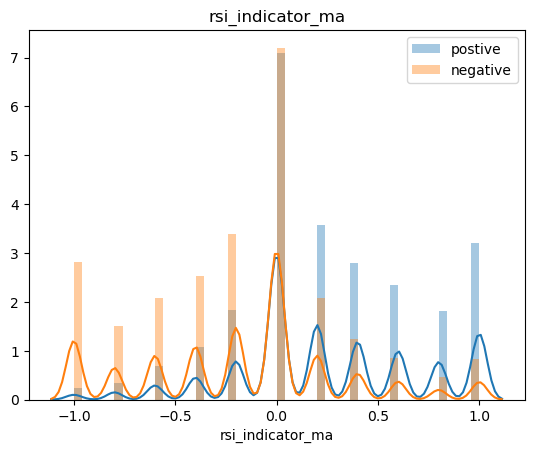

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


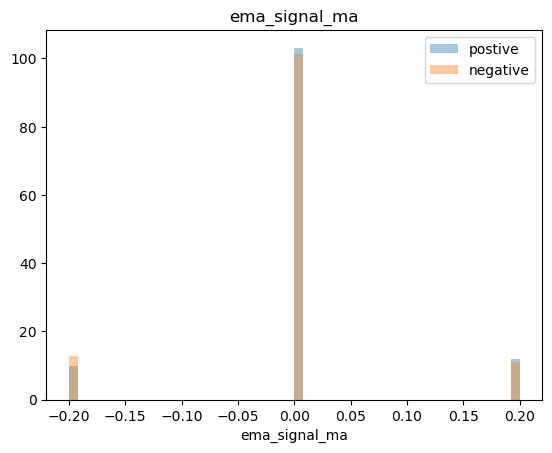

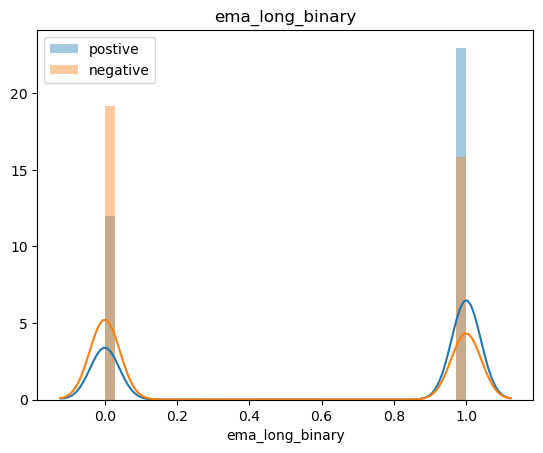

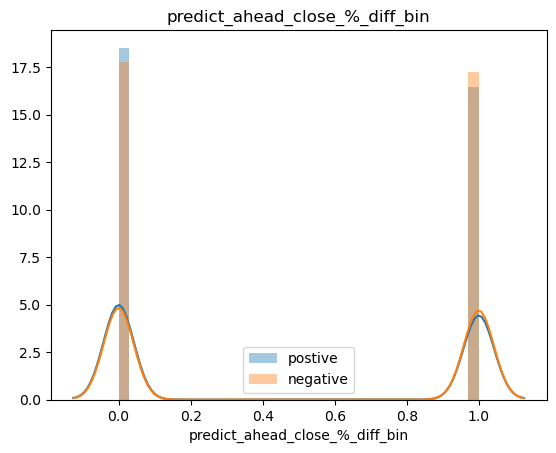

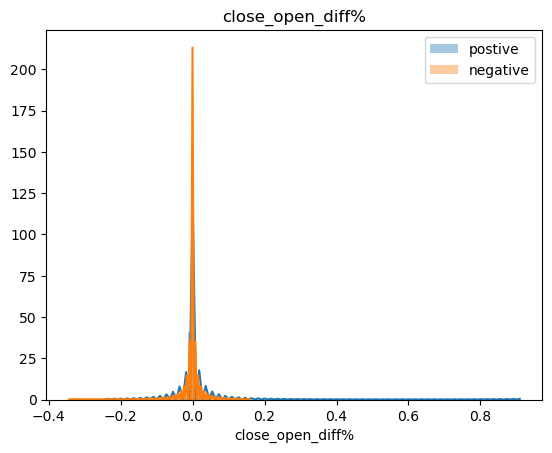

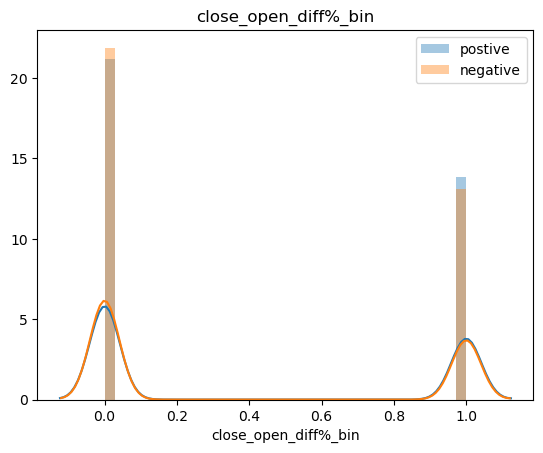

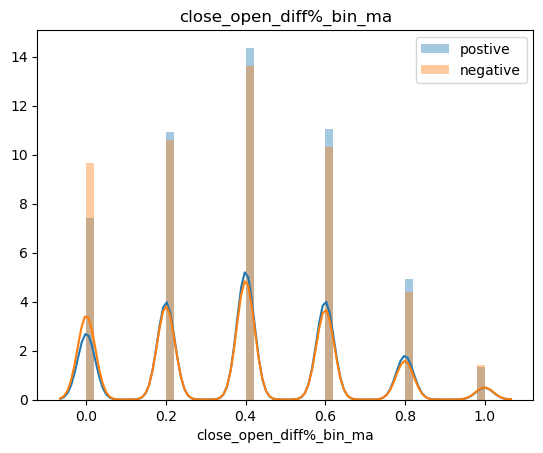

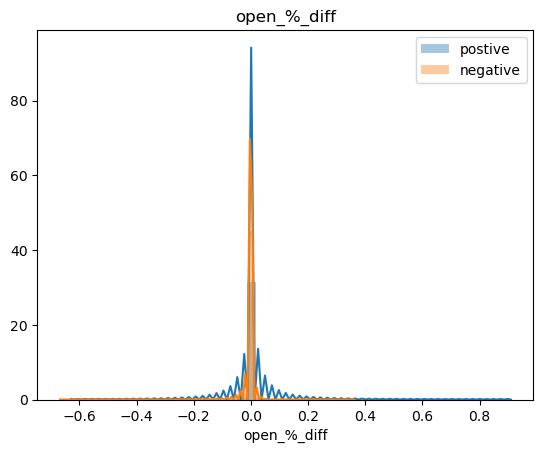

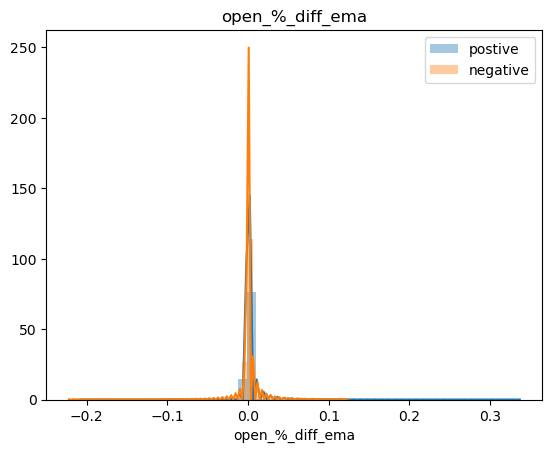

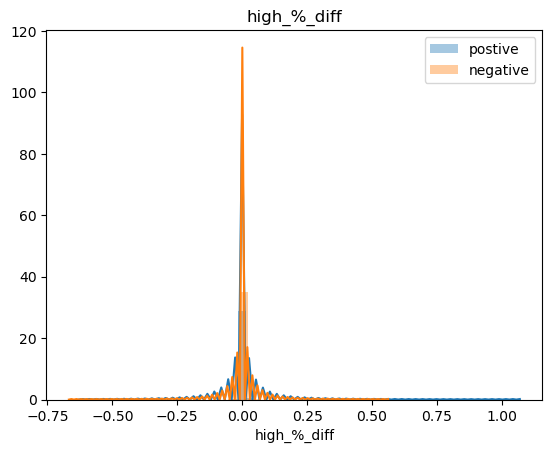

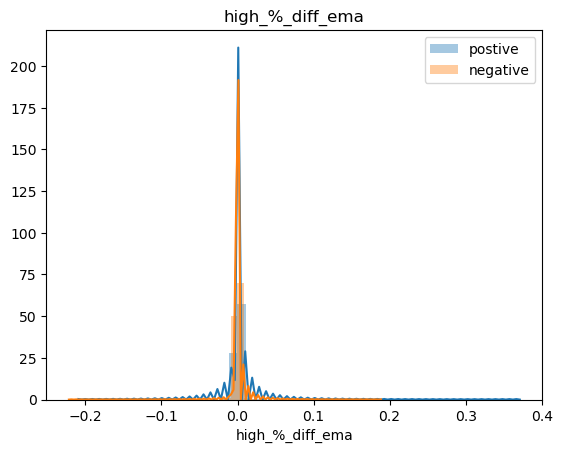

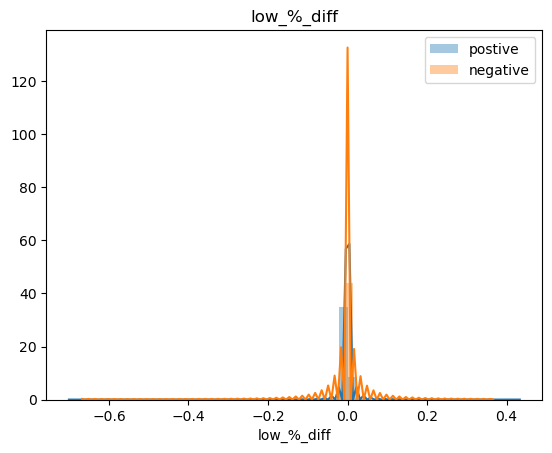

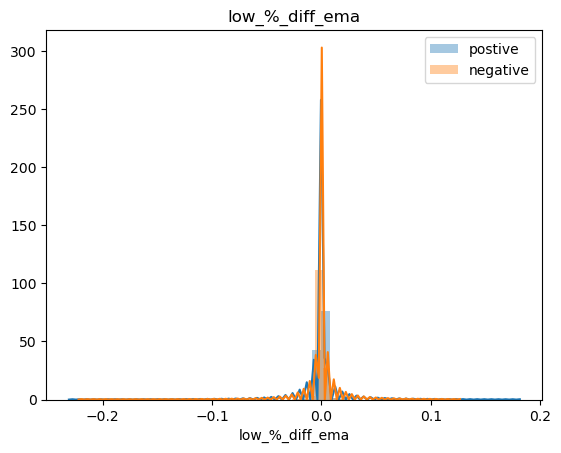

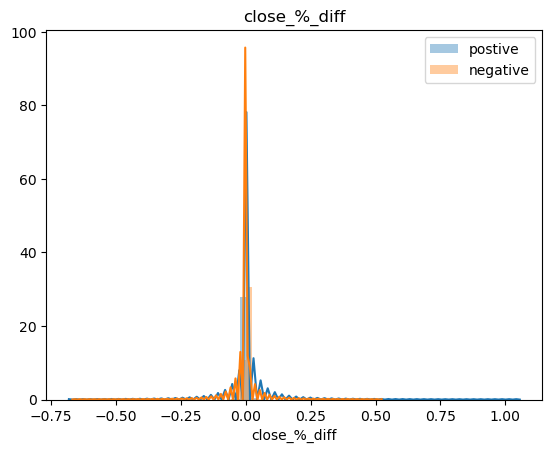

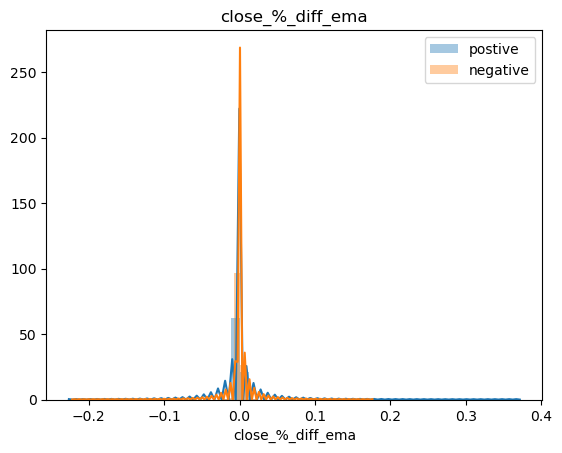

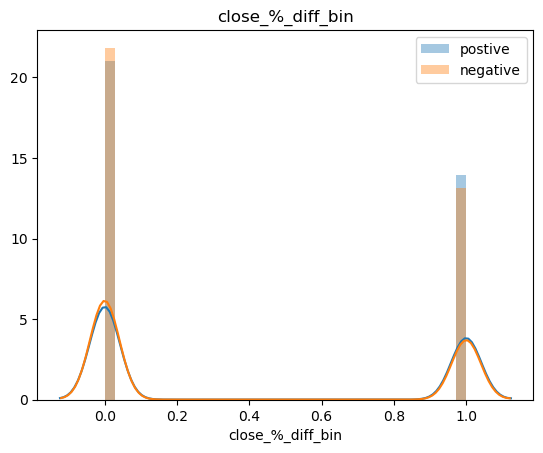

In [21]:
for x in data.columns[:-1]:
    sns.distplot(data[x][data['predict_ahead_close_%_diff_bin'].shift(window)==1],label='postive')
    sns.distplot(data[x][data['predict_ahead_close_%_diff_bin'].shift(window)==0],label='negative')
    plt.legend()
    plt.title(x)
    plt.show()

The correlation is poorly maintained to the subsequent time period though the entire pattern hasn't disappeared

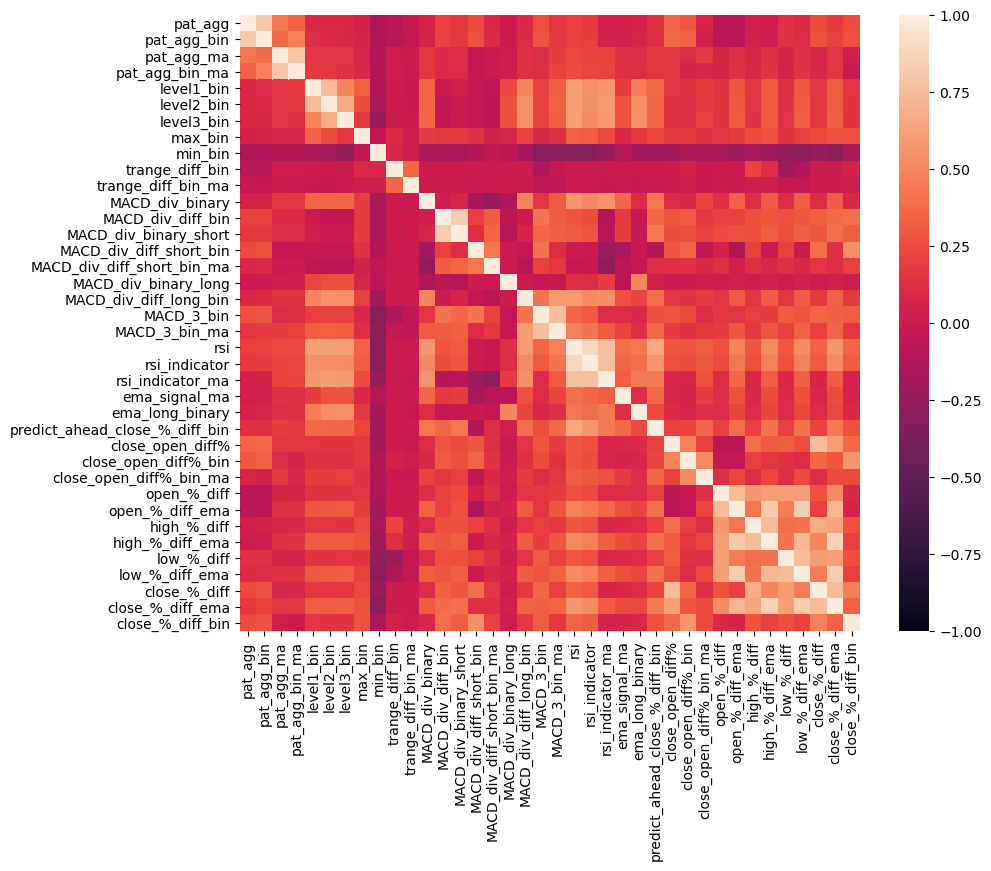

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(data.drop(columns=['tick']).corr(),vmin=-1,vmax=1)
plt.show()

There are general pockets of high correlation such as the %_diff variables and moving average of variables.  These variables are retained because they should help show a pattern.

In [23]:
#The test split date can be pushed back by the history to avoid a time gap between the train and test data.
#With enough data, that gap isn't particularly concerning
#The train test split isn't exactly perfectly, but it is approximate.
ref_tick=data['tick'].value_counts().index[data['tick'].value_counts()==data['tick'].value_counts().max()][0]
ref_len=data[data['tick']==ref_tick].shape[0]
split_loc=round(ref_len*.8)
split_date=data.index[data['tick']==ref_tick][split_loc]
train_df = data[data.index<split_date]
test_df = data[data.index>=split_date]

scaler = MinMaxScaler()
scaler.fit(train_df.drop(columns=['tick']))

MinMaxScaler()

In [24]:
train_df.shape

(518964, 39)

In [25]:
test_df.shape

(134688, 39)

In [26]:
test_df.shape[0]/(test_df.shape[0]+train_df.shape[0])

0.20605459785941144

In [27]:
#requires 2d array:cases,variables
def sequence_x(array,history,window):
    for i in range(array.shape[1]):
        temp = []

        for l in range(history+window,array.shape[0]):
            temp.append(array[l-history-window:l-window,i])
        if i==0:
            new_array=temp
        else:
            new_array = np.dstack((new_array,temp))

    return new_array

In [28]:
#requires only used variables in dataframe for column name reference
#Warning, columns must be in correct order
def sequence_y(array,history,window,key_variables,data):
    temp = []
    dep_vars = data.drop(columns=['tick']).columns.isin(key_variables)
    dep_vars_loc = np.where(dep_vars)
    for var in dep_vars_loc:
        start=history+window
        temp.append(array[start:array.shape[0],var])
    temp = np.asarray(temp)
    temp=temp.reshape((array.shape[0]-start,len(temp)))
    return temp

In [29]:
#higher level function for preparing the data for the lstm model.
#pca is included as an option
def generate_scaled_array(train_df,test_df,key_variables,history,window,pca_bin=False):
    main_x_train = 1
    main_x_test = 1
    main_y_train = 1
    main_y_test =1
    
    if pca_bin==True:
        pca = PCA(n_components=(train_df.drop(columns=['tick']).shape[1])-1)
        scaled_total_train=scaler.transform(train_df.drop(columns=['tick']))
        X_pca_train = pca.fit(scaled_total_train)
        sns.lineplot(x=range(1,len(pca.explained_variance_ratio_)+1),y=pca.explained_variance_ratio_)
        plt.title('explained variance')
        plt.xlabel('# of components')
        plt.ylabel('explained variance ratio')
        plt.show()
        print('Select number of components')
        components = int(input())
    
    
    
    
    
    
    for tick in train_df['tick'].unique():
        scaled_train=scaler.transform(train_df[train_df['tick']==tick].drop(columns=['tick']))
        scaled_test=scaler.transform(test_df[test_df['tick']==tick].drop(columns=['tick']))
        
        if pca_bin==True:
            X_pca_train = pca.fit_transform(scaled_train)
            X_pca_test = pca.transform(scaled_test)
            X_pca_train=X_pca_train[:,:components]
            X_pca_test=X_pca_test[:,:components]
            x_train = sequence_x(X_pca_train,history,window)
            x_test = sequence_x(X_pca_test,history,window)
        else:
            x_train = sequence_x(scaled_train,history,window)
            x_test = sequence_x(scaled_test,history,window)
    
        y_train=sequence_y(scaled_train,history,window,key_variables,train_df)
        y_test=sequence_y(scaled_test,history,window,key_variables,test_df)
        if type(main_x_train)!=np.ndarray:
                main_x_train = x_train
                main_x_test = x_test
                main_y_train = y_train
                main_y_test = y_test
        else:
            main_x_train = np.concatenate((main_x_train,x_train),axis=0)
            main_x_test = np.concatenate((main_x_test,x_test),axis=0)
            main_y_train = np.concatenate((main_y_train,y_train),axis=0)
            main_y_test = np.concatenate((main_y_test,y_test),axis=0)
    return main_x_train,main_x_test,main_y_train,main_y_test

In [30]:
x_train,x_test,y_train,y_test=generate_scaled_array(train_df,test_df,key_variables,history,window,False)

In [31]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(517284, 30, 38) (133008, 30, 38) (517284, 1) (133008, 1)


In [32]:
x_test.max()

1.0

In [33]:
x_test.min()

0.0

In [34]:
max_values=[]
min_values = []
for col in range(x_test.shape[2]):
    max_values.append(x_test[:,:,col].max())
    min_values.append(x_test[:,:,col].min())
    
dict(zip(data.columns[:-1].drop(['predict_ahead_close_%_diff_bin']),zip(max_values,min_values)))

{'pat_agg': (0.9999999999999999, 0.047619047619047616),
 'pat_agg_bin': (1.0, 0.0),
 'pat_agg_ma': (0.9999999999999998, 0.049180327868852514),
 'pat_agg_bin_ma': (1.0, 0.0),
 'level1_bin': (1.0, 0.0),
 'level2_bin': (1.0, 0.0),
 'level3_bin': (1.0, 0.0),
 'max_bin': (1.0, 0.0),
 'min_bin': (1.0, 0.0),
 'trange_diff_bin': (1.0, 0.0),
 'trange_diff_bin_ma': (1.0, 0.0),
 'MACD_div_binary': (1.0, 0.0),
 'MACD_div_diff_bin': (1.0, 0.0),
 'MACD_div_binary_short': (1.0, 0.0),
 'MACD_div_diff_short_bin': (1.0, 0.0),
 'MACD_div_diff_short_bin_ma': (1.0, 0.0),
 'MACD_div_binary_long': (1.0, 0.0),
 'MACD_div_diff_long_bin': (1.0, 0.0),
 'MACD_3_bin': (1.0, 0.0),
 'MACD_3_bin_ma': (1.0, 0.058517541781970696),
 'rsi': (0.9999997399127071, 1.7874207595520127e-09),
 'rsi_indicator': (1.0, 0.0),
 'rsi_indicator_ma': (1.0, 0.0),
 'ema_signal_ma': (1.0, 0.0),
 'ema_long_binary': (1.0, 0.0),
 'close_open_diff%': (1.0, 0.0),
 'close_open_diff%_bin': (0.6260233710493697, 0.158810887829811),
 'close_open_di

Values outside the 0-1 scaling are usually related to outlier price movements.  This can generally be fixed with increasing the data size.

In [35]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=96))
model.add(Dropout(.1))
model.add(Dense(units=200,activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))    

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['binary_accuracy'])
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='auto')
earlyStopping = EarlyStopping(monitor='val_binary_accuracy', patience=15, verbose=1, mode='auto')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 96)            51840     
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 200)               19400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 145,553
Trainable params: 145,553
Non-trainable params: 0
_________________________________________________________________


In [36]:
hist = model.fit(x_train,y_train, epochs=30, batch_size=256, verbose=True, validation_data=(x_test,y_test),callbacks=[earlyStopping])

Train on 517284 samples, validate on 133008 samples
Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
517284/517284 [==============================] - 32s 61us/sample - loss: 0.6870 - binary_accuracy: 0.5234 - val_loss: 0.6918 - val_binary_accuracy: 0.5043
Epoch 2/30
517284/517284 [==============================] - 23s 45us/sample - loss: 0.6856 - binary_accuracy: 0.5285 - val_loss: 0.6970 - val_binary_accuracy: 0.5073
Epoch 3/30
517284/517284 [==============================] - 23s 45us/sample - loss: 0.6849 - binary_accuracy: 0.5308 - val_loss: 0.6915 - val_binary_accuracy: 0.5167
Epoch 4/30
517284/517284 [==============================] - 23s 44us/sample - loss: 0.6843 - binary_accuracy: 0.5336 - val_loss: 0.6930 - val_binary_accuracy: 0.5113
Epoch 5/30
517284/517284 [==============================] - 23s 44us/sample - loss: 0.6836 - binary_accuracy: 0.5356 - val_loss: 0.6913 - val_binary_accuracy: 0.5156
Epoch 6/30
517284/517284

In [37]:
y_pred_raw = model.predict(x_test)

In [38]:
y_pred = y_pred_raw > .50

In [39]:
confusion_matrix(y_test,y_pred)

array([[34942, 32461],
       [33490, 32115]], dtype=int64)

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.52      0.51     67403
         1.0       0.50      0.49      0.49     65605

    accuracy                           0.50    133008
   macro avg       0.50      0.50      0.50    133008
weighted avg       0.50      0.50      0.50    133008



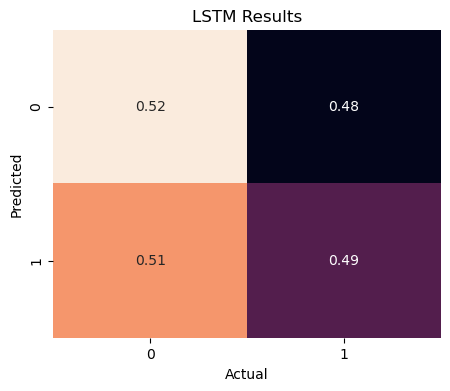

In [41]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LSTM Results')
plt.show()

Convolution LSTM:


In [42]:
con_time=5
row=1
columns=history/con_time
columns=int(columns)
#columns must be whole number

In [43]:
def reshape_convlstm(x_array,con_time,row,columns):
    temp_array = x_array.reshape(x_array.shape[0],con_time,row,columns,x_array.shape[2])
    return temp_array

In [44]:
def reshape_convlstm_y(y_array,con_time,row,columns):
    temp_array = y_array.reshape(y_array.shape[0],con_time,row,columns,y_array.shape[2])
    return temp_array

In [45]:
new_x_train = reshape_convlstm(x_train,con_time,row,columns)
new_x_test = reshape_convlstm(x_test,con_time,row,columns)

In [46]:
new_x_train.shape

(517284, 5, 1, 6, 38)

In [47]:
model = Sequential()
model.add(ConvLSTM2D(filters=96, return_sequences=True,kernel_size=(1,2), activation='relu', input_shape=new_x_train.shape[1:]))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=96, kernel_size=(1,3), activation='relu', input_shape=new_x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Flatten())
model.add(RepeatVector(y_train.shape[1]))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(y_train.shape[1],activation='sigmoid')))

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['binary_accuracy'])
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='auto')
earlyStopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, verbose=1, mode='auto')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 5, 1, 5, 96)       103296    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 1, 5, 96)       384       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 3, 96)          221568    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 3, 96)          384       
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 288)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 200)           

In [48]:
hist = model.fit(new_x_train,y_train, epochs=20, batch_size=256, verbose=True, validation_data=(new_x_test,y_test),callbacks=[earlyStopping])

Train on 517284 samples, validate on 133008 samples
Epoch 1/20
517284/517284 [==============================] - 112s 217us/sample - loss: 0.6867 - binary_accuracy: 0.5259 - val_loss: 0.6921 - val_binary_accuracy: 0.5090
Epoch 2/20
517284/517284 [==============================] - 103s 198us/sample - loss: 0.6849 - binary_accuracy: 0.5334 - val_loss: 0.6981 - val_binary_accuracy: 0.5079
Epoch 3/20
517284/517284 [==============================] - 102s 198us/sample - loss: 0.6837 - binary_accuracy: 0.5394 - val_loss: 0.6957 - val_binary_accuracy: 0.5128
Epoch 4/20
517284/517284 [==============================] - 102s 196us/sample - loss: 0.6817 - binary_accuracy: 0.5460 - val_loss: 0.6956 - val_binary_accuracy: 0.5127
Epoch 5/20
517284/517284 [==============================] - 103s 198us/sample - loss: 0.6781 - binary_accuracy: 0.5567 - val_loss: 0.6967 - val_binary_accuracy: 0.5150
Epoch 6/20
517284/517284 [==============================] - 102s 197us/sample - loss: 0.6717 - binary_accura

In [49]:
y_pred_raw = model.predict(new_x_test)

In [50]:
y_pred = y_pred_raw > .50
y_pred=y_pred.reshape(-1)

In [51]:
confusion_matrix(y_test,y_pred)

array([[35467, 31936],
       [33588, 32017]], dtype=int64)

In [52]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.53      0.52     67403
         1.0       0.50      0.49      0.49     65605

    accuracy                           0.51    133008
   macro avg       0.51      0.51      0.51    133008
weighted avg       0.51      0.51      0.51    133008



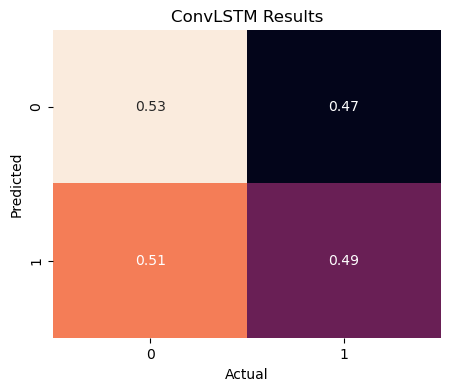

In [53]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ConvLSTM Results')
plt.show()

In [54]:
#classifying with no history:
xg_cls = xgb.XGBRFClassifier(n_estimators=100,max_depth=5,learning_Rate=.01,verbosity=0)
xg_cls.fit(x_train[:,-1],y_train.reshape(-1))
raw_preds = xg_cls.predict_proba(x_test[:,-1])[:,1]

In [55]:
y_pred = raw_preds > 0.5
confusion_matrix(y_test,y_pred)

array([[50503, 16900],
       [47799, 17806]], dtype=int64)

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.75      0.61     67403
         1.0       0.51      0.27      0.36     65605

    accuracy                           0.51    133008
   macro avg       0.51      0.51      0.48    133008
weighted avg       0.51      0.51      0.48    133008



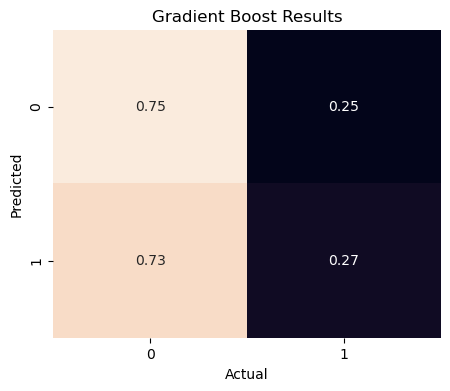

In [57]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boost Results')
plt.show()

In [58]:
sorted(zip(xg_cls.feature_importances_,data.columns[:-1]))

[(0.0040250425, 'MACD_div_binary_long'),
 (0.0053553437, 'level1_bin'),
 (0.005490892, 'close_open_diff%_bin'),
 (0.0055015995, 'MACD_div_diff_short_bin'),
 (0.0056030364, 'predict_ahead_close_%_diff_bin'),
 (0.0056319153, 'level2_bin'),
 (0.005753389, 'min_bin'),
 (0.0065657976, 'MACD_div_binary_short'),
 (0.0068835556, 'trange_diff_bin'),
 (0.007661248, 'open_%_diff'),
 (0.007683305, 'MACD_div_diff_short_bin_ma'),
 (0.008600134, 'ema_long_binary'),
 (0.008659657, 'MACD_div_diff_long_bin'),
 (0.00935266, 'ema_signal_ma'),
 (0.009708498, 'MACD_div_binary'),
 (0.01004968, 'MACD_3_bin'),
 (0.010232103, 'open_%_diff_ema'),
 (0.010322296, 'high_%_diff_ema'),
 (0.01052505, 'rsi_indicator_ma'),
 (0.011183706, 'high_%_diff'),
 (0.01213684, 'low_%_diff'),
 (0.012642537, 'max_bin'),
 (0.013733415, 'rsi_indicator'),
 (0.014832259, 'level3_bin'),
 (0.0148963, 'low_%_diff_ema'),
 (0.017195549, 'close_%_diff_bin'),
 (0.018842397, 'close_open_diff%'),
 (0.01911898, 'pat_agg'),
 (0.019525727, 'pat_ag

In [59]:
#Catboost classifier, no history
cbc = CatBoostClassifier(iterations=500, task_type='GPU')
cbc.fit(x_train[:,-1],y_train.reshape(-1))
y_pred=cbc.predict(x_test[:,-1])

Learning rate set to 0.044488


0:	learn: 0.6925993	total: 37.7ms	remaining: 18.8s
1:	learn: 0.6921046	total: 56.7ms	remaining: 14.1s
2:	learn: 0.6916555	total: 75.4ms	remaining: 12.5s
3:	learn: 0.6912518	total: 93.1ms	remaining: 11.5s
4:	learn: 0.6908781	total: 110ms	remaining: 10.9s
5:	learn: 0.6905278	total: 129ms	remaining: 10.6s
6:	learn: 0.6902137	total: 147ms	remaining: 10.3s
7:	learn: 0.6899233	total: 163ms	remaining: 10s
8:	learn: 0.6896489	total: 183ms	remaining: 10s
9:	learn: 0.6893888	total: 201ms	remaining: 9.84s
10:	learn: 0.6891533	total: 217ms	remaining: 9.66s
11:	learn: 0.6889427	total: 236ms	remaining: 9.59s
12:	learn: 0.6887398	total: 255ms	remaining: 9.55s
13:	learn: 0.6885529	total: 273ms	remaining: 9.48s
14:	learn: 0.6883647	total: 290ms	remaining: 9.38s
15:	learn: 0.6882094	total: 309ms	remaining: 9.34s
16:	learn: 0.6880761	total: 327ms	remaining: 9.29s
17:	learn: 0.6879434	total: 343ms	remaining: 9.17s
18:	learn: 0.6878212	total: 360ms	remaining: 9.12s
19:	learn: 0.6877070	total: 377ms	remaini

162:	learn: 0.6843538	total: 2.69s	remaining: 5.56s
163:	learn: 0.6843417	total: 2.71s	remaining: 5.55s
164:	learn: 0.6843303	total: 2.72s	remaining: 5.53s
165:	learn: 0.6843208	total: 2.74s	remaining: 5.51s
166:	learn: 0.6843108	total: 2.76s	remaining: 5.5s
167:	learn: 0.6842997	total: 2.77s	remaining: 5.48s
168:	learn: 0.6842894	total: 2.79s	remaining: 5.46s
169:	learn: 0.6842775	total: 2.8s	remaining: 5.44s
170:	learn: 0.6842688	total: 2.82s	remaining: 5.42s
171:	learn: 0.6842611	total: 2.83s	remaining: 5.4s
172:	learn: 0.6842515	total: 2.85s	remaining: 5.39s
173:	learn: 0.6842401	total: 2.87s	remaining: 5.37s
174:	learn: 0.6842277	total: 2.88s	remaining: 5.36s
175:	learn: 0.6842172	total: 2.9s	remaining: 5.34s
176:	learn: 0.6842093	total: 2.92s	remaining: 5.32s
177:	learn: 0.6841992	total: 2.93s	remaining: 5.3s
178:	learn: 0.6841909	total: 2.95s	remaining: 5.29s
179:	learn: 0.6841807	total: 2.96s	remaining: 5.27s
180:	learn: 0.6841713	total: 2.98s	remaining: 5.25s
181:	learn: 0.684

324:	learn: 0.6827666	total: 5.36s	remaining: 2.88s
325:	learn: 0.6827570	total: 5.37s	remaining: 2.87s
326:	learn: 0.6827466	total: 5.39s	remaining: 2.85s
327:	learn: 0.6827315	total: 5.41s	remaining: 2.84s
328:	learn: 0.6827235	total: 5.43s	remaining: 2.82s
329:	learn: 0.6827115	total: 5.44s	remaining: 2.8s
330:	learn: 0.6827013	total: 5.46s	remaining: 2.79s
331:	learn: 0.6826918	total: 5.47s	remaining: 2.77s
332:	learn: 0.6826800	total: 5.49s	remaining: 2.75s
333:	learn: 0.6826679	total: 5.5s	remaining: 2.73s
334:	learn: 0.6826574	total: 5.52s	remaining: 2.72s
335:	learn: 0.6826494	total: 5.53s	remaining: 2.7s
336:	learn: 0.6826393	total: 5.55s	remaining: 2.69s
337:	learn: 0.6826283	total: 5.57s	remaining: 2.67s
338:	learn: 0.6826215	total: 5.58s	remaining: 2.65s
339:	learn: 0.6826129	total: 5.6s	remaining: 2.63s
340:	learn: 0.6826001	total: 5.62s	remaining: 2.62s
341:	learn: 0.6825919	total: 5.63s	remaining: 2.6s
342:	learn: 0.6825816	total: 5.65s	remaining: 2.58s
343:	learn: 0.682

486:	learn: 0.6812333	total: 7.96s	remaining: 212ms
487:	learn: 0.6812244	total: 7.97s	remaining: 196ms
488:	learn: 0.6812159	total: 7.99s	remaining: 180ms
489:	learn: 0.6812032	total: 8.01s	remaining: 163ms
490:	learn: 0.6811957	total: 8.03s	remaining: 147ms
491:	learn: 0.6811857	total: 8.05s	remaining: 131ms
492:	learn: 0.6811773	total: 8.07s	remaining: 115ms
493:	learn: 0.6811685	total: 8.09s	remaining: 98.2ms
494:	learn: 0.6811561	total: 8.1s	remaining: 81.8ms
495:	learn: 0.6811515	total: 8.12s	remaining: 65.5ms
496:	learn: 0.6811432	total: 8.13s	remaining: 49.1ms
497:	learn: 0.6811354	total: 8.15s	remaining: 32.7ms
498:	learn: 0.6811285	total: 8.16s	remaining: 16.4ms
499:	learn: 0.6811187	total: 8.18s	remaining: 0us


In [60]:
confusion_matrix(y_test,y_pred)

array([[40149, 27254],
       [37223, 28382]], dtype=int64)

In [61]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.60      0.55     67403
         1.0       0.51      0.43      0.47     65605

    accuracy                           0.52    133008
   macro avg       0.51      0.51      0.51    133008
weighted avg       0.51      0.52      0.51    133008



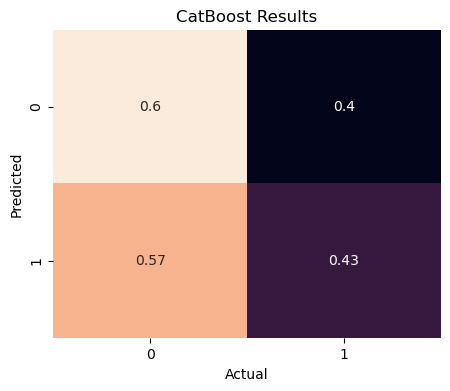

In [62]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('CatBoost Results')
plt.show()

In [63]:
sorted(zip(cbc.get_feature_importance(),data.columns[:-1]))

[(0.09907426001238397, 'pat_agg_bin'),
 (0.11795731063551369, 'trange_diff_bin'),
 (0.1323798606057511, 'MACD_div_diff_short_bin'),
 (0.13697151992839446, 'MACD_3_bin'),
 (0.13724344997103882, 'min_bin'),
 (0.20380231844413332, 'MACD_div_binary_short'),
 (0.2773236821622172, 'close_open_diff%_bin'),
 (0.30850247835022937, 'rsi_indicator'),
 (0.38143074224386087, 'max_bin'),
 (0.4269586092016967, 'predict_ahead_close_%_diff_bin'),
 (0.4440241648653645, 'level1_bin'),
 (0.499469253520436, 'MACD_div_binary'),
 (0.5080712372861416, 'MACD_div_diff_bin'),
 (0.559028471718166, 'level2_bin'),
 (0.7320430090512208, 'close_%_diff_bin'),
 (0.9458084066728853, 'MACD_div_diff_long_bin'),
 (0.9648363209863046, 'level3_bin'),
 (1.1624397318348585, 'ema_long_binary'),
 (1.5257229471961897, 'ema_signal_ma'),
 (1.631200564879693, 'MACD_div_binary_long'),
 (1.7132105901049217, 'MACD_div_diff_short_bin_ma'),
 (2.118776307770174, 'pat_agg'),
 (2.2489892009024763, 'open_%_diff'),
 (2.3346426171577095, 'clos

Among key features, price % change variables are not particularly helpful, but the models are not learning at all so feature importance isn't all that meaningful.

In [64]:
clf = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=50)
clf.fit(x_train[:,-1],y_train.reshape(-1))
y_pred=cbc.predict(x_test[:,-1])

In [65]:
confusion_matrix(y_test,y_pred)

array([[40149, 27254],
       [37223, 28382]], dtype=int64)

In [66]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.60      0.55     67403
         1.0       0.51      0.43      0.47     65605

    accuracy                           0.52    133008
   macro avg       0.51      0.51      0.51    133008
weighted avg       0.51      0.52      0.51    133008



There is no point in grid search optimization when the model doesn't learn.

All of these models failed to learn in any meaningful way.  While it is possible to improve precisions by raising the threshold for labeling from .5 to a higher value, the small number of predictions makes the model useless.  Over several stocks for a long period of time, only so many periods are labeled for trading.  This is an inefficient use of time.

PCA versions:

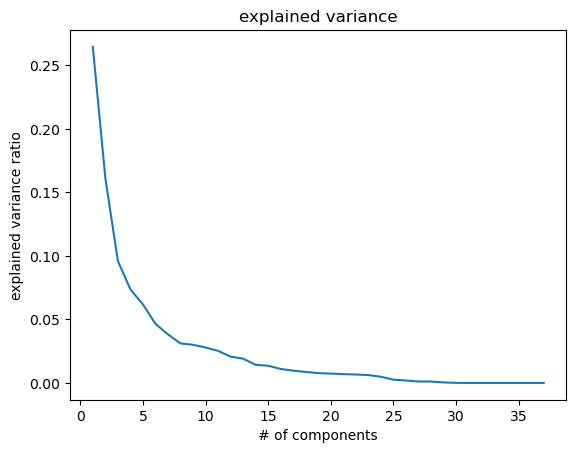

Select number of components
12


In [67]:
x_train,x_test,y_train,y_test=generate_scaled_array(train_df,test_df,key_variables,history,window,True)

In [68]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(517284, 30, 12) (133008, 30, 12) (517284, 1) (133008, 1)


In [69]:
x_test.max()

2.316597250222302

In [70]:
x_test.min()

-2.183245837171884

In [71]:
max_values=[]
min_values = []
for col in range(x_test.shape[2]):
    max_values.append(x_test[:,:,col].max())
    min_values.append(x_test[:,:,col].min())
    
dict(zip(max_values,min_values))

{2.316597250222302: -2.183245837171884,
 1.9296402709480667: -1.8836032752638239,
 1.8489672148850633: -1.7202444226404379,
 1.7992297886375097: -1.666370242112683,
 1.7159957017861236: -1.139780989790629,
 1.9140381157961042: -1.5419685146065718,
 1.5296738985025955: -1.3945652018198196,
 1.514843877245168: -1.3960932262005035,
 1.359769365805401: -1.6062837878132745,
 1.4739981500699104: -1.34646850429864,
 1.3279863068717443: -1.337153664052686,
 1.3256931700084198: -1.3566907629235045}

Regular LSTM

In [72]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=96))
model.add(Dropout(.1))
model.add(Dense(units=200,activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))    

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['binary_accuracy'])
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='auto')
earlyStopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, verbose=1, mode='auto')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 96)            41856     
_________________________________________________________________
lstm_4 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               19400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 135,569
Trainable params: 135,569
Non-trainable params: 0
_________________________________________________________________


In [75]:
hist = model.fit(x_train,y_train, epochs=20, batch_size=256, verbose=True, validation_data=(x_test,y_test),callbacks=[earlyStopping])

Train on 517284 samples, validate on 133008 samples
Epoch 1/20
517284/517284 [==============================] - 24s 47us/sample - loss: 0.6883 - binary_accuracy: 0.5228 - val_loss: 0.6923 - val_binary_accuracy: 0.5088
Epoch 2/20
517284/517284 [==============================] - 22s 42us/sample - loss: 0.6860 - binary_accuracy: 0.5260 - val_loss: 0.6918 - val_binary_accuracy: 0.5065
Epoch 3/20
517284/517284 [==============================] - 21s 41us/sample - loss: 0.6841 - binary_accuracy: 0.5304 - val_loss: 0.6934 - val_binary_accuracy: 0.5112
Epoch 4/20
517284/517284 [==============================] - 21s 41us/sample - loss: 0.6816 - binary_accuracy: 0.5374 - val_loss: 0.6945 - val_binary_accuracy: 0.5087
Epoch 5/20
517284/517284 [==============================] - 21s 41us/sample - loss: 0.6774 - binary_accuracy: 0.5465 - val_loss: 0.6995 - val_binary_accuracy: 0.5068
Epoch 6/20
517284/517284 [==============================] - 21s 41us/sample - loss: 0.6715 - binary_accuracy: 0.5578 -

In [77]:
y_pred_raw = model.predict(x_test)

In [78]:
y_pred = y_pred_raw > .50
y_pred=y_pred.reshape(-1)

In [79]:
confusion_matrix(y_test,y_pred)

array([[35502, 31901],
       [33877, 31728]], dtype=int64)

In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.53      0.52     67403
         1.0       0.50      0.48      0.49     65605

    accuracy                           0.51    133008
   macro avg       0.51      0.51      0.51    133008
weighted avg       0.51      0.51      0.51    133008



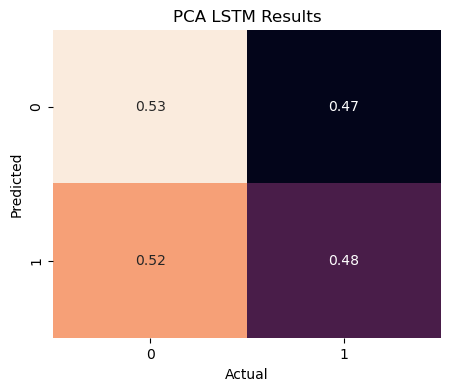

In [81]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PCA LSTM Results')
plt.show()

CONVLSTM:

In [82]:
new_x_train = reshape_convlstm(x_train,con_time,row,columns)
new_x_test = reshape_convlstm(x_test,con_time,row,columns)

In [83]:
model = Sequential()
model.add(ConvLSTM2D(filters=96, return_sequences=True,kernel_size=(1,2), activation='relu', input_shape=new_x_train.shape[1:]))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=96, kernel_size=(1,3), activation='relu', input_shape=new_x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Flatten())
model.add(RepeatVector(y_train.shape[1]))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(y_train.shape[1],activation='sigmoid')))

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['binary_accuracy'])
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='auto')
earlyStopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, verbose=1, mode='auto')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 5, 1, 5, 96)       83328     
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 1, 5, 96)       384       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 3, 96)          221568    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 3, 96)          384       
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 288)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 200)           

In [85]:
hist = model.fit(new_x_train,y_train, epochs=20, batch_size=256, verbose=True, validation_data=(new_x_test,y_test),callbacks=[earlyStopping])

Train on 517284 samples, validate on 133008 samples
Epoch 1/20
517284/517284 [==============================] - 102s 197us/sample - loss: 0.5930 - binary_accuracy: 0.6718 - val_loss: 0.7881 - val_binary_accuracy: 0.5075
Epoch 2/20
517284/517284 [==============================] - 96s 186us/sample - loss: 0.5668 - binary_accuracy: 0.6961 - val_loss: 0.8080 - val_binary_accuracy: 0.5073
Epoch 3/20
517284/517284 [==============================] - 96s 186us/sample - loss: 0.5410 - binary_accuracy: 0.7170 - val_loss: 0.8402 - val_binary_accuracy: 0.5088
Epoch 4/20
517284/517284 [==============================] - 96s 186us/sample - loss: 0.5166 - binary_accuracy: 0.7352 - val_loss: 0.8899 - val_binary_accuracy: 0.5067
Epoch 5/20
517284/517284 [==============================] - 96s 186us/sample - loss: 0.4940 - binary_accuracy: 0.7514 - val_loss: 0.9373 - val_binary_accuracy: 0.5071
Epoch 6/20
517284/517284 [==============================] - 96s 186us/sample - loss: 0.4746 - binary_accuracy: 0

In [86]:
y_pred_raw = model.predict(new_x_test)

In [87]:
y_pred = y_pred_raw > .50
y_pred=y_pred.reshape(-1)

In [88]:
confusion_matrix(y_test,y_pred)

array([[35049, 32354],
       [33087, 32518]], dtype=int64)

In [89]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.52      0.52     67403
         1.0       0.50      0.50      0.50     65605

    accuracy                           0.51    133008
   macro avg       0.51      0.51      0.51    133008
weighted avg       0.51      0.51      0.51    133008



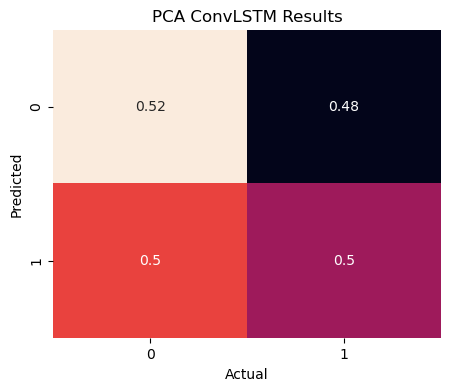

In [90]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PCA ConvLSTM Results')
plt.show()

In [91]:
#classifying with no history:
xg_cls = xgb.XGBRFClassifier(n_estimators=100,max_depth=5,learning_Rate=.01,verbosity=0)
xg_cls.fit(x_train[:,-1],y_train.reshape(-1))
raw_preds = xg_cls.predict_proba(x_test[:,-1])[:,1]
y_pred = raw_preds > 0.5

In [92]:
y_pred = raw_preds > 0.5
confusion_matrix(y_test,y_pred)

array([[66100,  1303],
       [64294,  1311]], dtype=int64)

In [93]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.98      0.67     67403
         1.0       0.50      0.02      0.04     65605

    accuracy                           0.51    133008
   macro avg       0.50      0.50      0.35    133008
weighted avg       0.50      0.51      0.36    133008



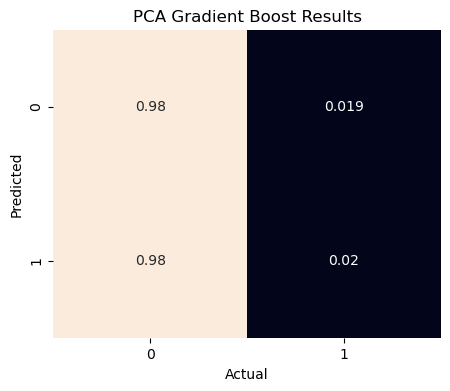

In [94]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PCA Gradient Boost Results')
plt.show()

In [95]:
#Catboost classifier, no history
cbc = CatBoostClassifier(iterations=500, task_type='GPU')
cbc.fit(x_train[:,-1],y_train.reshape(-1))
y_pred=cbc.predict(x_test[:,-1])

Learning rate set to 0.044488
0:	learn: 0.6930141	total: 19.3ms	remaining: 9.65s
1:	learn: 0.6928832	total: 34.3ms	remaining: 8.53s
2:	learn: 0.6927679	total: 49.5ms	remaining: 8.2s
3:	learn: 0.6926692	total: 64.2ms	remaining: 7.97s


4:	learn: 0.6925702	total: 84.1ms	remaining: 8.32s
5:	learn: 0.6924818	total: 103ms	remaining: 8.45s
6:	learn: 0.6923865	total: 120ms	remaining: 8.42s
7:	learn: 0.6923132	total: 139ms	remaining: 8.56s
8:	learn: 0.6922348	total: 154ms	remaining: 8.4s
9:	learn: 0.6921672	total: 168ms	remaining: 8.24s
10:	learn: 0.6920971	total: 182ms	remaining: 8.1s
11:	learn: 0.6920349	total: 196ms	remaining: 7.98s
12:	learn: 0.6919706	total: 211ms	remaining: 7.91s
13:	learn: 0.6919152	total: 224ms	remaining: 7.78s
14:	learn: 0.6918624	total: 238ms	remaining: 7.68s
15:	learn: 0.6918032	total: 251ms	remaining: 7.6s
16:	learn: 0.6917526	total: 265ms	remaining: 7.53s
17:	learn: 0.6917057	total: 288ms	remaining: 7.71s
18:	learn: 0.6916587	total: 306ms	remaining: 7.75s
19:	learn: 0.6916097	total: 321ms	remaining: 7.7s
20:	learn: 0.6915643	total: 335ms	remaining: 7.63s
21:	learn: 0.6915250	total: 348ms	remaining: 7.57s
22:	learn: 0.6914860	total: 364ms	remaining: 7.54s
23:	learn: 0.6914470	total: 379ms	remain

177:	learn: 0.6886778	total: 2.71s	remaining: 4.9s
178:	learn: 0.6886604	total: 2.73s	remaining: 4.89s
179:	learn: 0.6886469	total: 2.74s	remaining: 4.87s
180:	learn: 0.6886345	total: 2.76s	remaining: 4.86s
181:	learn: 0.6886183	total: 2.77s	remaining: 4.85s
182:	learn: 0.6886080	total: 2.79s	remaining: 4.83s
183:	learn: 0.6885960	total: 2.81s	remaining: 4.82s
184:	learn: 0.6885779	total: 2.82s	remaining: 4.8s
185:	learn: 0.6885658	total: 2.84s	remaining: 4.79s
186:	learn: 0.6885539	total: 2.85s	remaining: 4.77s
187:	learn: 0.6885443	total: 2.87s	remaining: 4.76s
188:	learn: 0.6885309	total: 2.88s	remaining: 4.74s
189:	learn: 0.6885165	total: 2.9s	remaining: 4.73s
190:	learn: 0.6885030	total: 2.92s	remaining: 4.72s
191:	learn: 0.6884933	total: 2.93s	remaining: 4.7s
192:	learn: 0.6884781	total: 2.95s	remaining: 4.69s
193:	learn: 0.6884654	total: 2.96s	remaining: 4.68s
194:	learn: 0.6884513	total: 2.98s	remaining: 4.66s
195:	learn: 0.6884395	total: 2.99s	remaining: 4.64s
196:	learn: 0.68

343:	learn: 0.6866858	total: 5.18s	remaining: 2.35s
344:	learn: 0.6866736	total: 5.19s	remaining: 2.33s
345:	learn: 0.6866615	total: 5.21s	remaining: 2.32s
346:	learn: 0.6866500	total: 5.22s	remaining: 2.3s
347:	learn: 0.6866352	total: 5.24s	remaining: 2.29s
348:	learn: 0.6866239	total: 5.25s	remaining: 2.27s
349:	learn: 0.6866118	total: 5.26s	remaining: 2.26s
350:	learn: 0.6866008	total: 5.28s	remaining: 2.24s
351:	learn: 0.6865907	total: 5.29s	remaining: 2.23s
352:	learn: 0.6865781	total: 5.31s	remaining: 2.21s
353:	learn: 0.6865648	total: 5.32s	remaining: 2.19s
354:	learn: 0.6865559	total: 5.34s	remaining: 2.18s
355:	learn: 0.6865472	total: 5.35s	remaining: 2.17s
356:	learn: 0.6865360	total: 5.37s	remaining: 2.15s
357:	learn: 0.6865245	total: 5.38s	remaining: 2.14s
358:	learn: 0.6865123	total: 5.4s	remaining: 2.12s
359:	learn: 0.6865022	total: 5.42s	remaining: 2.1s
360:	learn: 0.6864903	total: 5.43s	remaining: 2.09s
361:	learn: 0.6864776	total: 5.45s	remaining: 2.08s
362:	learn: 0.6

In [96]:
confusion_matrix(y_test,y_pred)

array([[52973, 14430],
       [51168, 14437]], dtype=int64)

In [97]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.79      0.62     67403
         1.0       0.50      0.22      0.31     65605

    accuracy                           0.51    133008
   macro avg       0.50      0.50      0.46    133008
weighted avg       0.50      0.51      0.46    133008



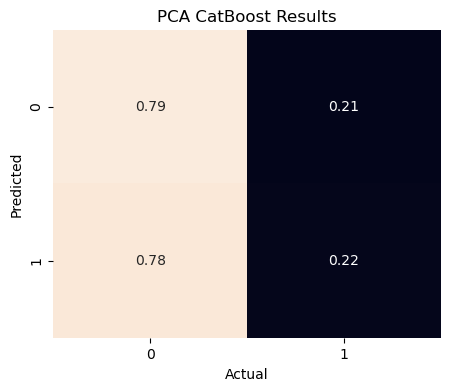

In [98]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PCA CatBoost Results')
plt.show()

In [99]:
clf = RandomForestClassifier(n_estimators=500,max_depth=10,min_samples_split=50)
clf.fit(x_train[:,-1],y_train.reshape(-1))
y_pred=cbc.predict(x_test[:,-1])

In [100]:
confusion_matrix(y_test,y_pred)

array([[52973, 14430],
       [51168, 14437]], dtype=int64)

In [101]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.79      0.62     67403
         1.0       0.50      0.22      0.31     65605

    accuracy                           0.51    133008
   macro avg       0.50      0.50      0.46    133008
weighted avg       0.50      0.51      0.46    133008



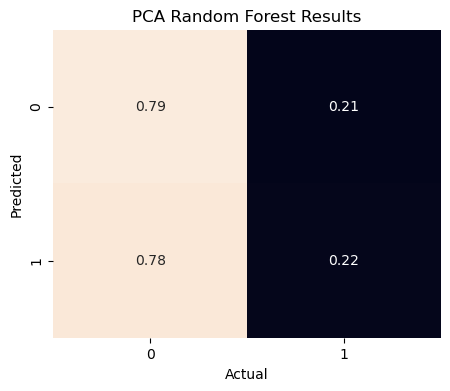

In [102]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PCA Random Forest Results')
plt.show()

Applying PCA does not improve model performance though it does speed up modeling

As an alternative strategy, I see if a model can help weed out bad ema crossing signals:

In [105]:
#how many days to use for predictions
history=15
#how far out to predict
#-1 is used because in this case the dep var is already aligned
window=-1
#how many days of predictions


#predicted variable
key_variables=['profit_bin']

In [106]:
file_list=glob.glob(path+processed_folder+"\\*.csv")

data=multitick_generator(file_list,window,True)

C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\AMKRminute2016-01-01_2020-01-01.csv


C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\AMRCminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\APPNminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\BPTminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CASIminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CCNEminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CIVBminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CMCTminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\CXSEminute2016-01-01_2020-01-01.csv
C:\Users\Adam Parente\Documents\Python Projects\stock capstone\stock_processed\DE

In [107]:
data.columns

Index(['pat_agg', 'pat_agg_bin', 'pat_agg_ma', 'pat_agg_bin_ma', 'level1_bin',
       'level2_bin', 'level3_bin', 'max_bin', 'min_bin', 'trange_diff_bin',
       'trange_diff_bin_ma', 'MACD_div_binary', 'MACD_div_diff_bin',
       'MACD_div_binary_short', 'MACD_div_diff_short_bin',
       'MACD_div_diff_short_bin_ma', 'MACD_div_binary_long',
       'MACD_div_diff_long_bin', 'MACD_3_bin', 'MACD_3_bin_ma', 'rsi',
       'rsi_indicator', 'rsi_indicator_ma', 'ema_signal', 'ema_signal_ma',
       'ema_long_binary', 'close_open_diff%', 'close_open_diff%_bin',
       'close_open_diff%_bin_ma', 'profit_bin', 'open_%_diff',
       'open_%_diff_ema', 'high_%_diff', 'high_%_diff_ema', 'low_%_diff',
       'low_%_diff_ema', 'close_%_diff', 'close_%_diff_ema',
       'close_%_diff_bin', 'tick'],
      dtype='object')

In [108]:
data[data['ema_signal']==1]

pat_agg  pat_agg_bin  pat_agg_ma  pat_agg_bin_ma  \
timestamp                                                                     
2016-01-12 09:30:00-05:00      2.0            1    1.000000        0.500000   
2016-01-13 09:30:00-05:00     -2.0           -1    1.000000        0.500000   
2016-01-13 15:00:00-05:00      0.0            0    0.666667        0.166667   
2016-01-14 10:00:00-05:00      1.0            1    0.666667        0.166667   
2016-01-14 12:30:00-05:00      4.0            1    0.500000        0.333333   
...                            ...          ...         ...             ...   
2019-12-11 13:00:00-05:00      1.0            1    0.833333        0.666667   
2019-12-16 09:30:00-05:00      1.0            1    0.833333        0.500000   
2019-12-19 10:30:00-05:00      0.0            0    1.000000        0.000000   
2019-12-26 16:00:00-05:00      3.0            1    1.333333        0.833333   
2019-12-31 13:00:00-05:00      2.0            1    2.833333        1.000000   

                           level1_bin  level2_bin  level3_bin  max_bin  \
timestamp                                                                
2016-01-12 09:30:00-05:00        True        True        True    False   
2016-01-13 09:30:00-05:00       False        True        True    False   
2016-01-13 15:00:00-05:00       False       False        True    False   
2016-01-14 10:00:00-05:00       False        True        True    False   
2016-01-14 12:30:00-05:00       False       False        True    False   
...                               ...         ...         ...      ...   
2019-12-11 13:00:00-05:00       False       False        True    False   
2019-12-16 09:30:00-05:00        True        True        True    False   
2019-12-19 10:30:00-05:00       False       False        True    False   
2019-12-26 16:00:00-05:00        True        True        True    False   
2019-12-31 13:00:00-05:00        True        True        True    False   

                           min_bin  trange_diff_bin  ...  open_%_diff  \
timestamp                                            ...                
2016-01-12 09:30:00-05:00    False                1  ...     0.012367   
2016-01-13 09:30:00-05:00    False                1  ...     0.007067   
2016-01-13 15:00:00-05:00    False                1  ...     0.001771   
2016-01-14 10:00:00-05:00    False                0  ...    -0.017606   
2016-01-14 12:30:00-05:00    False                0  ...     0.008929   
...                            ...              ...  ...          ...   
2019-12-11 13:00:00-05:00    False                0  ...     0.000000   
2019-12-16 09:30:00-05:00    False                1  ...     0.012980   
2019-12-19 10:30:00-05:00    False                1  ...     0.000000   
2019-12-26 16:00:00-05:00    False                0  ...     0.000000   
2019-12-31 13:00:00-05:00    False                1  ...     0.011573   

                           open_%_diff_ema  high_%_diff  high_%_diff_ema  \
timestamp                                                                  
2016-01-12 09:30:00-05:00         0.004022     0.031802         0.009275   
2016-01-13 09:30:00-05:00         0.004983     0.026502         0.009642   
2016-01-13 15:00:00-05:00         0.001817     0.004405         0.002111   
2016-01-14 10:00:00-05:00        -0.004718    -0.018803         0.000758   
2016-01-14 12:30:00-05:00         0.001131     0.009700         0.002314   
...                                    ...          ...              ...   
2019-12-11 13:00:00-05:00        -0.000060     0.000000        -0.000416   
2019-12-16 09:30:00-05:00         0.004211     0.015721         0.004476   
2019-12-19 10:30:00-05:00         0.001801     0.000000         0.001452   
2019-12-26 16:00:00-05:00         0.001915     0.000000         0.001842   
2019-12-31 13:00:00-05:00         0.004166     0.011001         0.003561   

                           low_%_diff  low_%_diff_ema  close_%_diff  \
timestamp                 

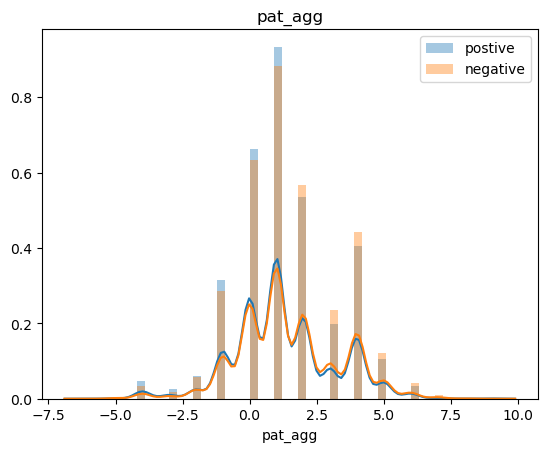

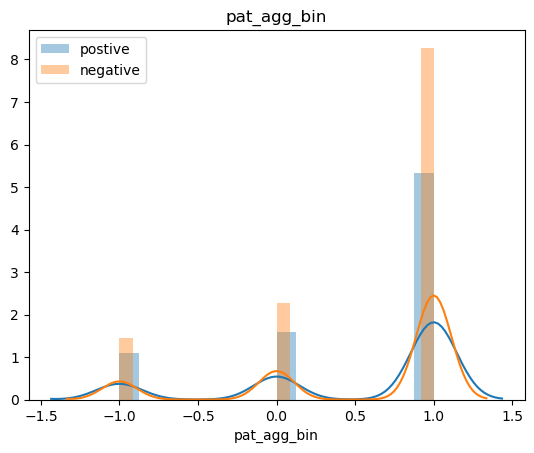

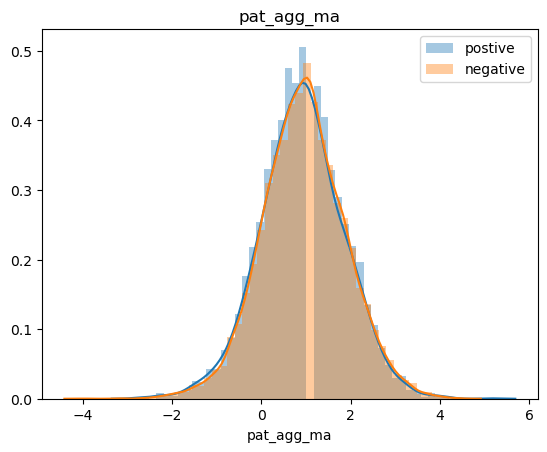

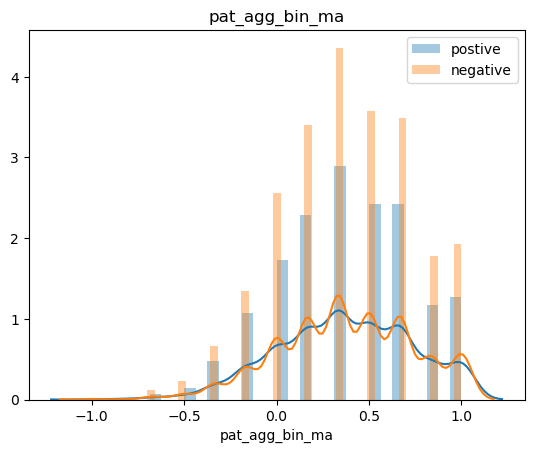

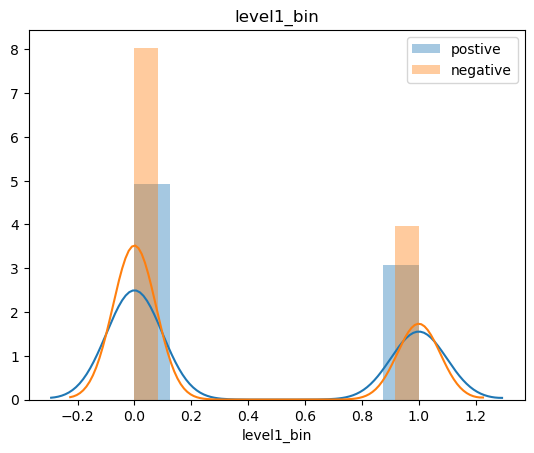

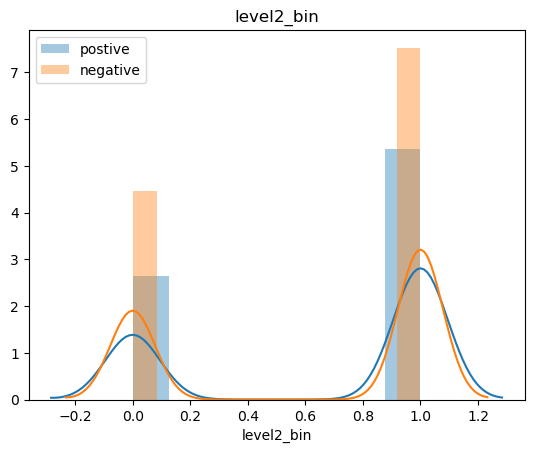

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


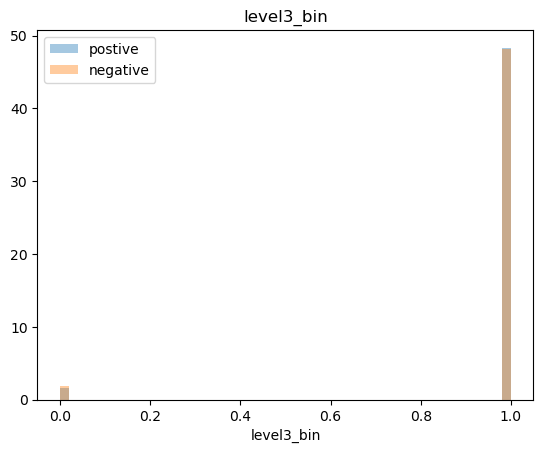

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


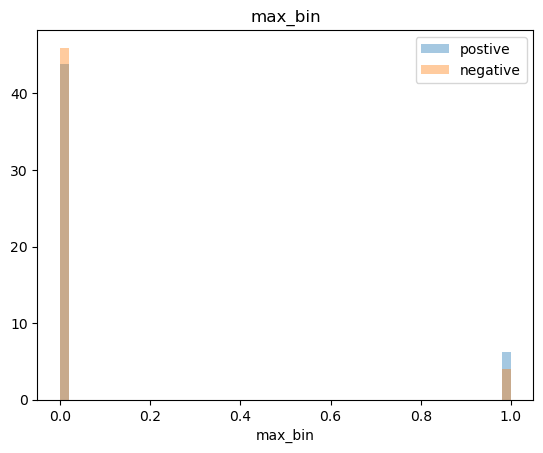

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


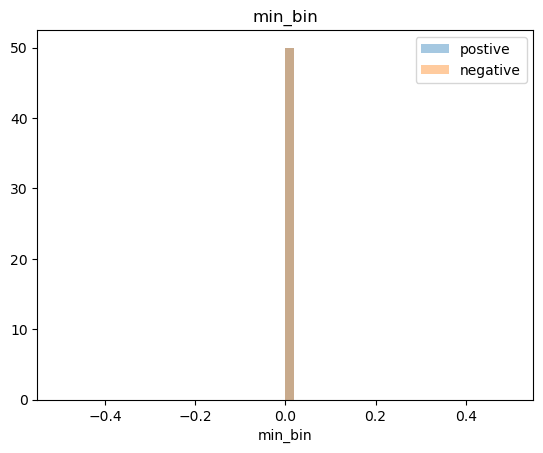

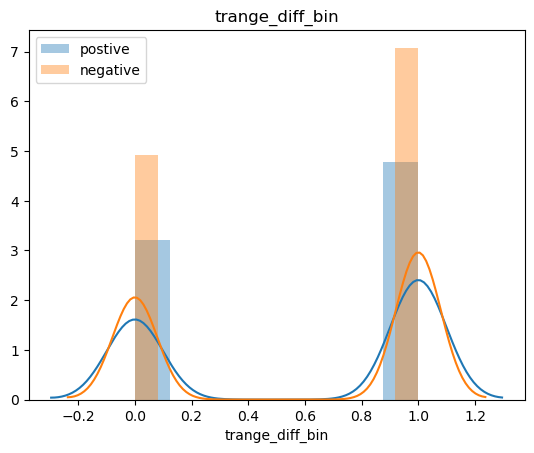

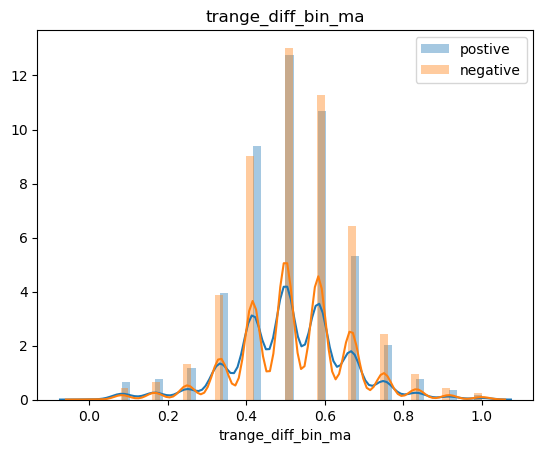

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


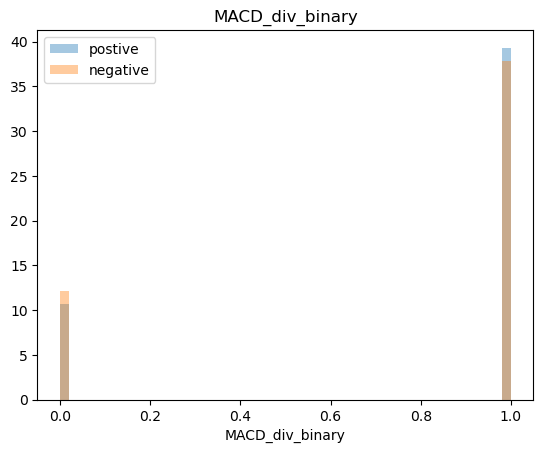

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


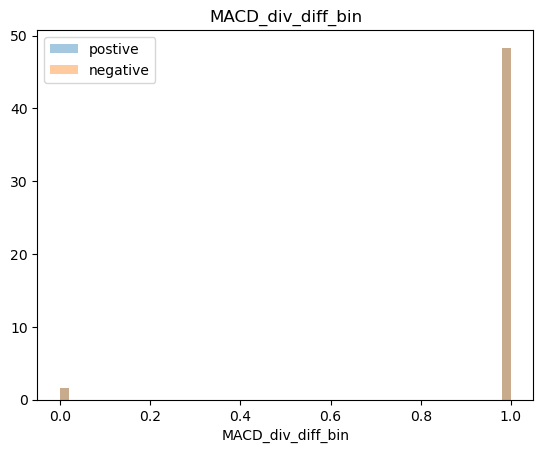

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


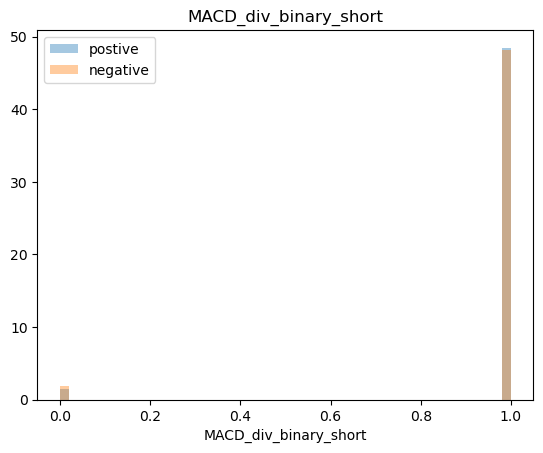

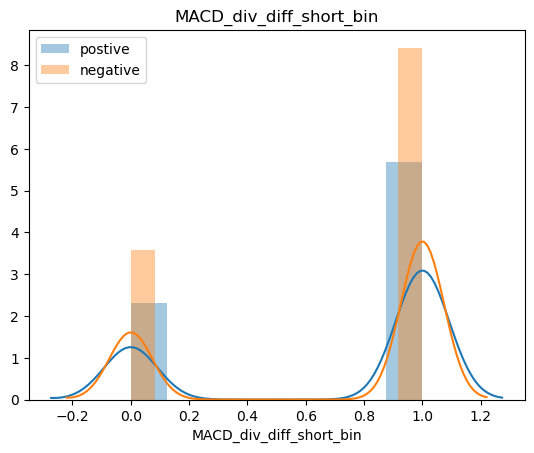

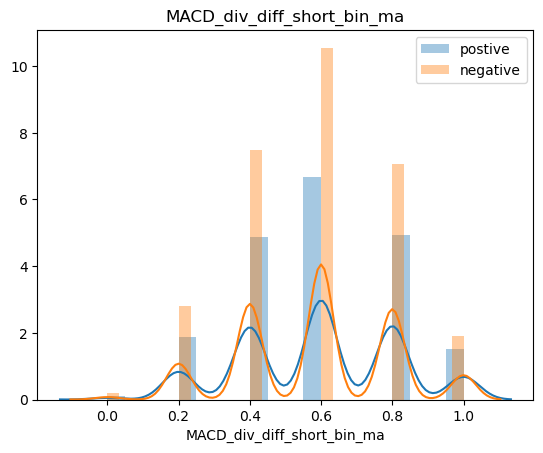

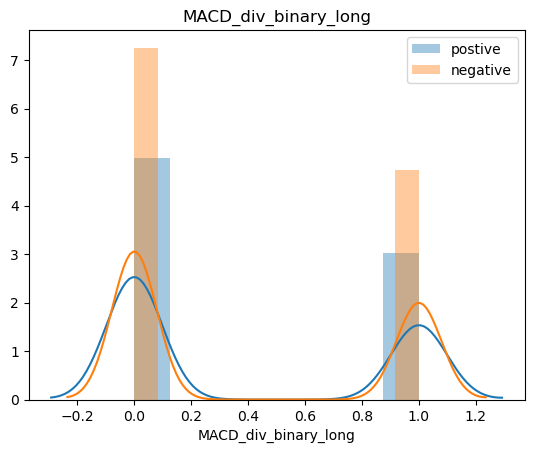

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


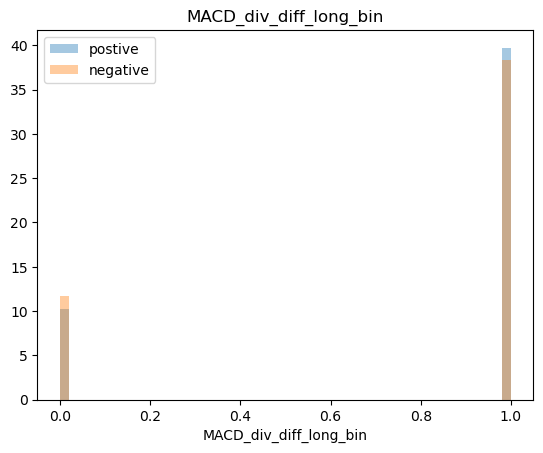

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


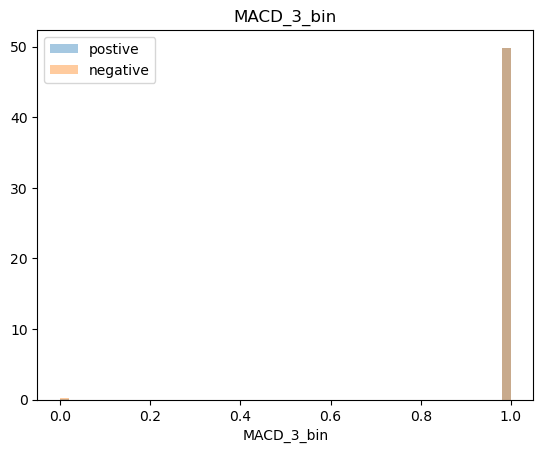

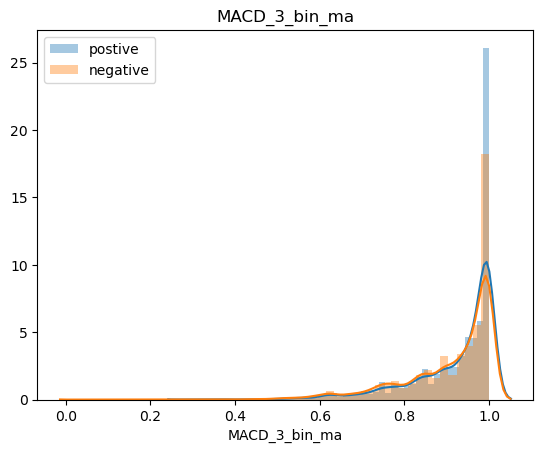

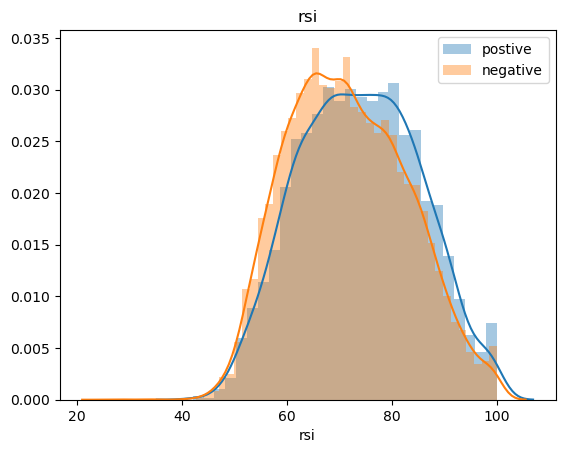

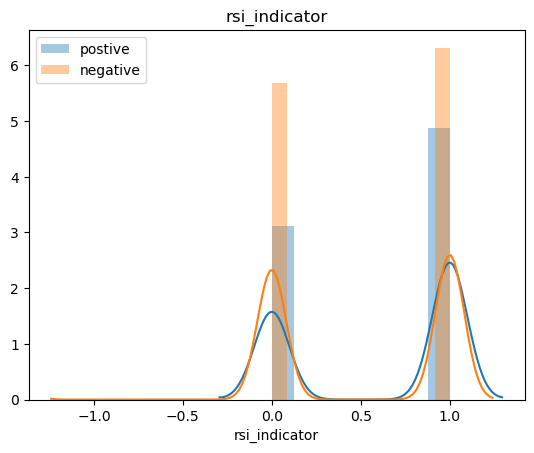

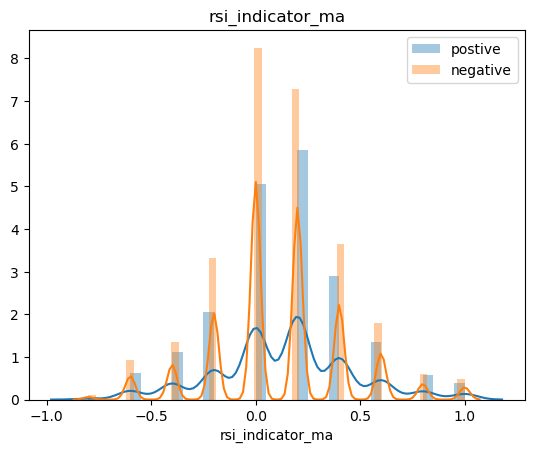

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


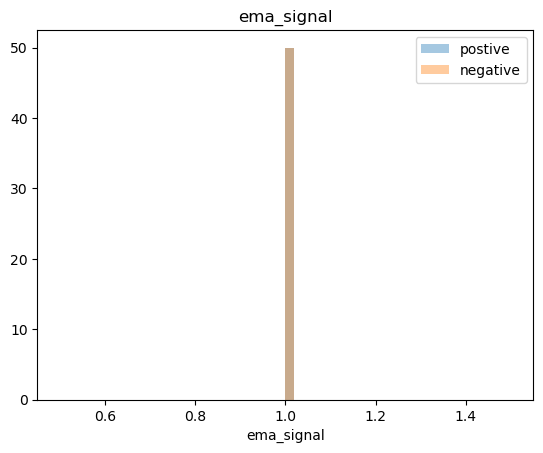

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


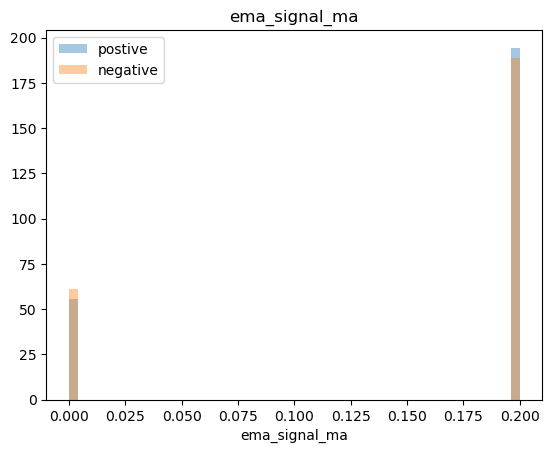

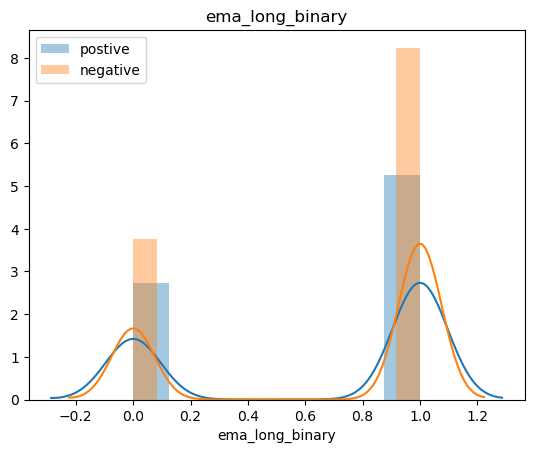

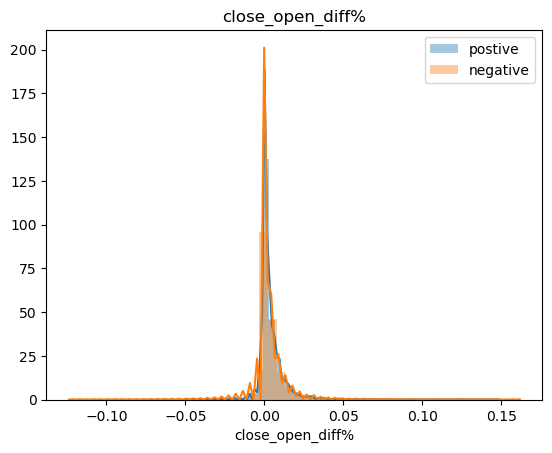

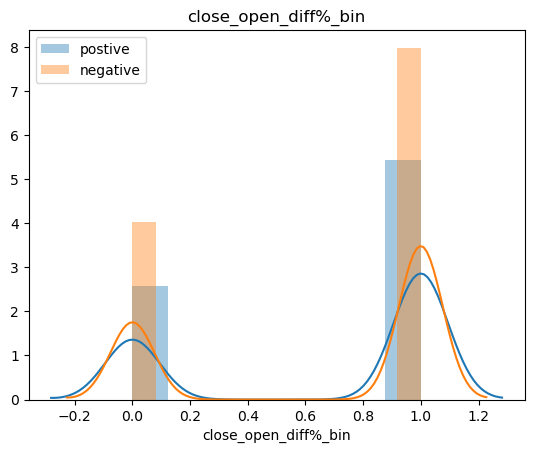

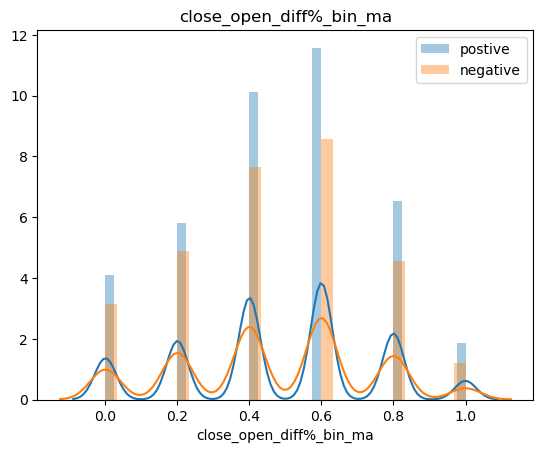

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


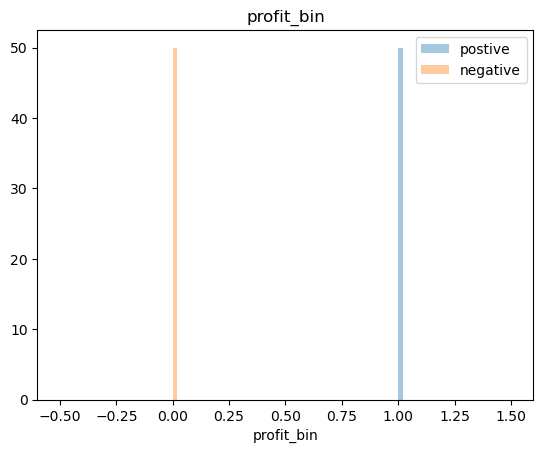

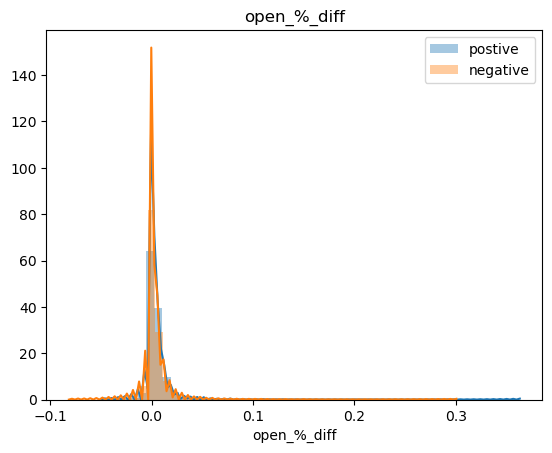

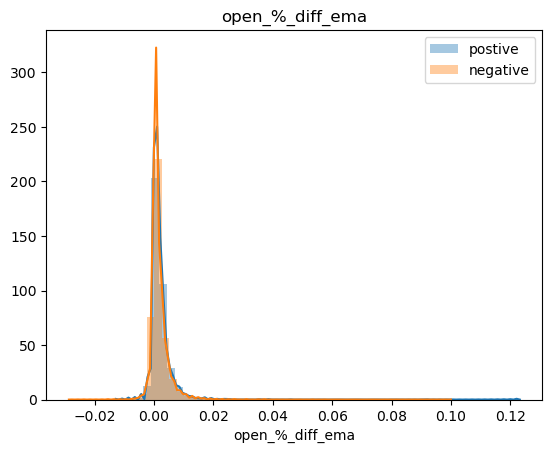

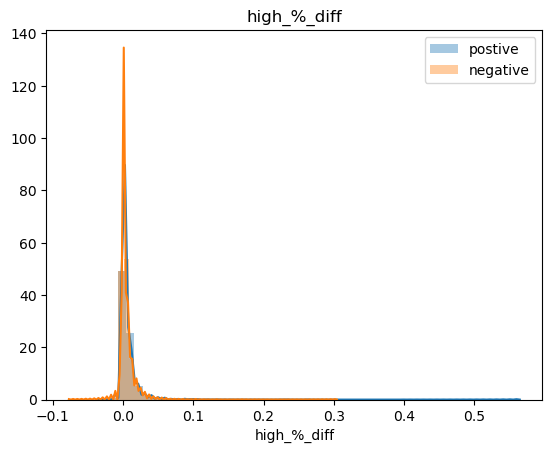

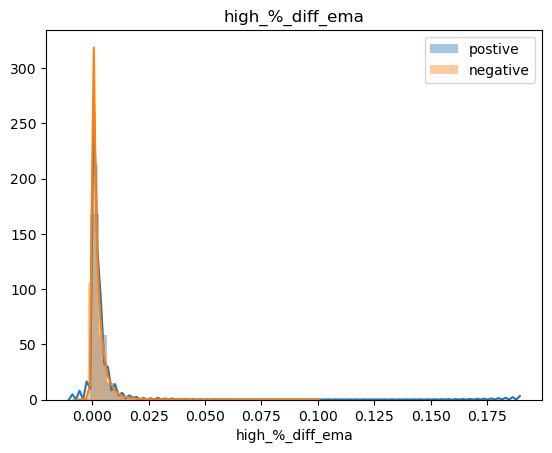

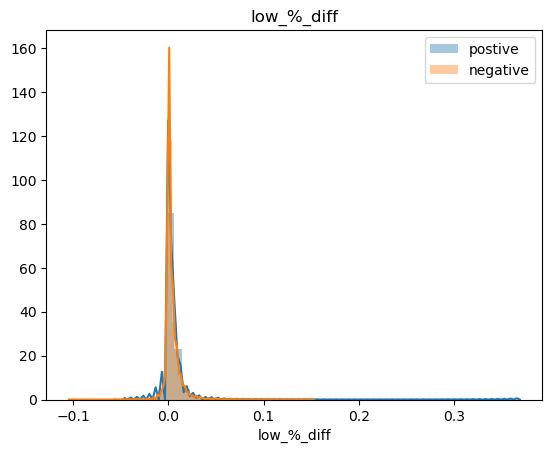

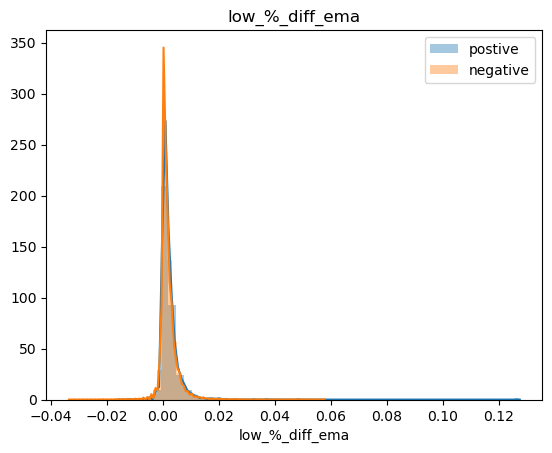

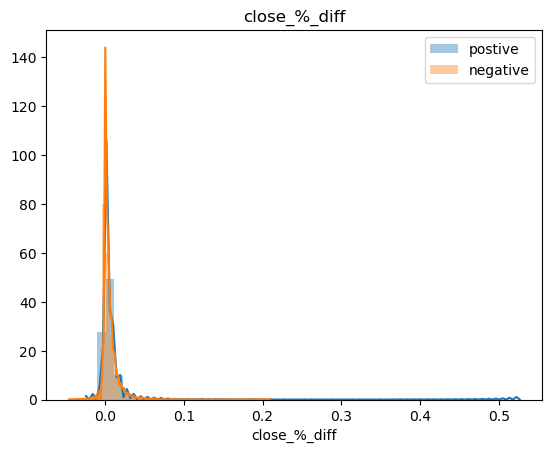

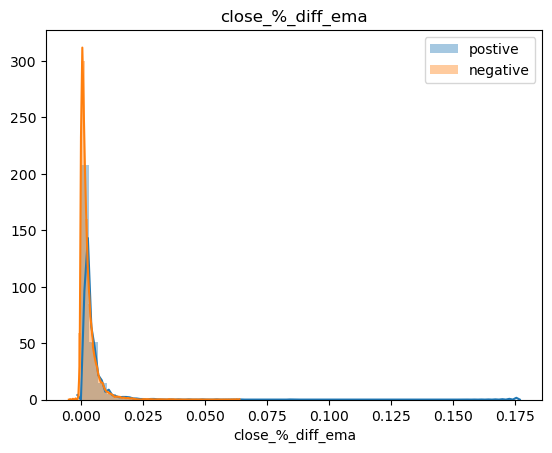

C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


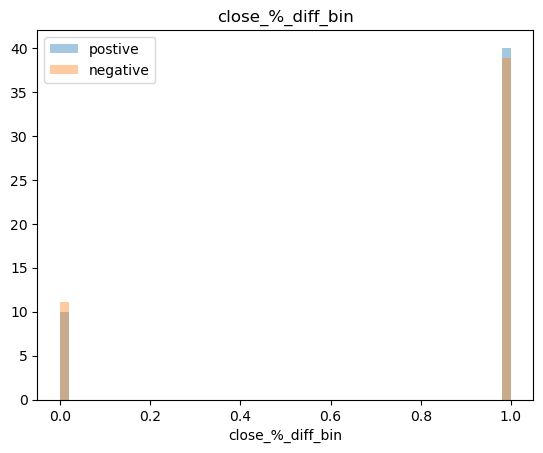

In [109]:
for x in data.columns[:-1]:
    sns.distplot(data[x][(data['profit_bin']==1) & (data['ema_signal']==1)],label='postive')
    sns.distplot(data[x][(data['profit_bin']==0) & (data['ema_signal']==1)],label='negative')
    plt.legend()
    plt.title(x)
    plt.show()

There isn't a whole lot of difference between true and false signals

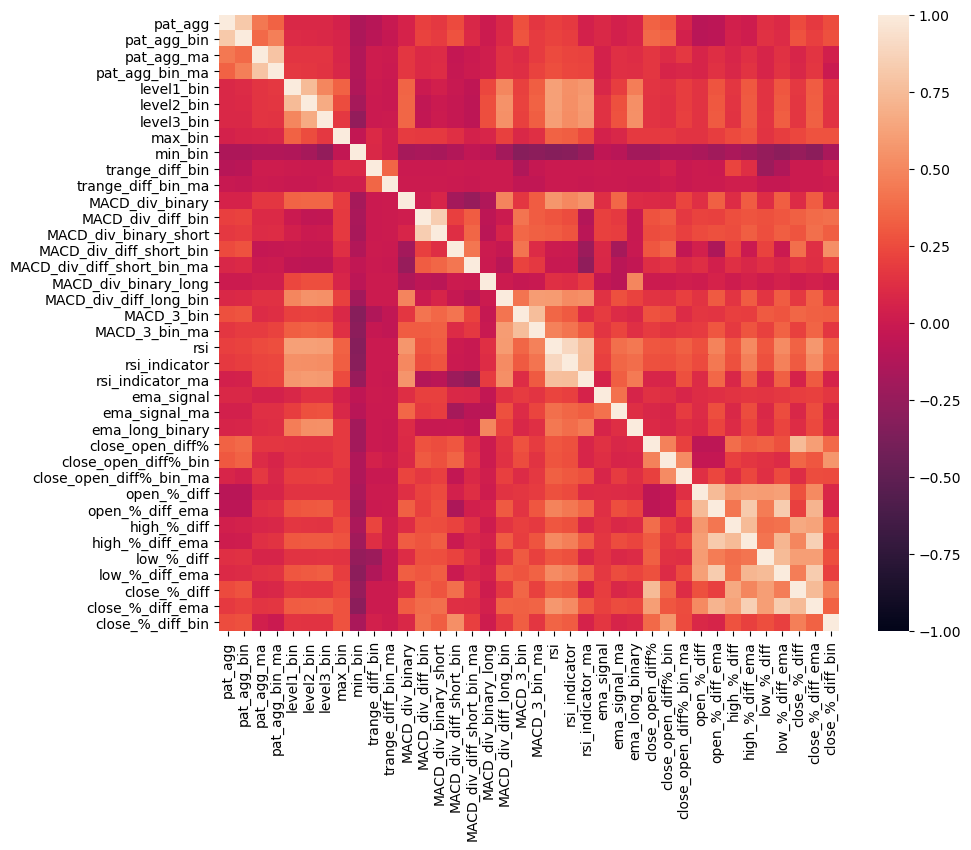

In [110]:
plt.figure(figsize=(10,8))
sns.heatmap(data.drop(columns=['tick']).corr(),vmin=-1,vmax=1)
plt.show()

In [113]:
data['ema_signal'].value_counts()

 0.0    633565
 1.0     16691
-1.0     16671
Name: ema_signal, dtype: int64

In [114]:
ref_tick=data['tick'].value_counts().index[data['tick'].value_counts()==data['tick'].value_counts().max()][0]
ref_len=data[data['tick']==ref_tick].shape[0]*.8
split_loc=round(ref_len*.8)
split_date=data.index[data['tick']==ref_tick][split_loc]
train_df = data[data.index<split_date]
test_df = data[data.index>=split_date]

scaler = MinMaxScaler()
scaler.fit(train_df.drop(columns=['tick']))

MinMaxScaler()

In [115]:
train_df.head()

pat_agg  pat_agg_bin  pat_agg_ma  pat_agg_bin_ma  \
timestamp                                                                     
2016-01-04 15:00:00-05:00     -2.0           -1    0.000000        0.166667   
2016-01-04 15:30:00-05:00      2.0            1    0.166667        0.166667   
2016-01-04 16:00:00-05:00      1.0            1    0.166667        0.166667   
2016-01-05 09:30:00-05:00      0.0            0    0.166667        0.166667   
2016-01-05 10:00:00-05:00     -1.0           -1    0.000000        0.000000   

                           level1_bin  level2_bin  level3_bin  max_bin  \
timestamp                                                                
2016-01-04 15:00:00-05:00       False       False       False    False   
2016-01-04 15:30:00-05:00       False       False       False    False   
2016-01-04 16:00:00-05:00       False       False       False    False   
2016-01-05 09:30:00-05:00       False       False       False    False   
2016-01-05 10:00:00-05:00       False       False       False    False   

                           min_bin  trange_diff_bin  ...  open_%_diff  \
timestamp                                            ...                
2016-01-04 15:00:00-05:00    False                1  ...    -0.001653   
2016-01-04 15:30:00-05:00    False                1  ...    -0.009106   
2016-01-04 16:00:00-05:00    False                1  ...     0.000000   
2016-01-05 09:30:00-05:00    False                1  ...     0.007519   
2016-01-05 10:00:00-05:00    False                0  ...     0.011609   

                           open_%_diff_ema  high_%_diff  high_%_diff_ema  \
timestamp                                                                  
2016-01-04 15:00:00-05:00         0.001240    -0.001653         0.000208   
2016-01-04 15:30:00-05:00        -0.002209     0.001656         0.000691   
2016-01-04 16:00:00-05:00        -0.001472     0.000000         0.000460   
2016-01-05 09:30:00-05:00         0.001525     0.011570         0.004164   
2016-01-05 10:00:00-05:00         0.004886     0.004902         0.004410   

                           low_%_diff  low_%_diff_ema  close_%_diff  \
timestamp                                                             
2016-01-04 15:00:00-05:00   -0.003333       -0.000358     -0.008278   
2016-01-04 15:30:00-05:00    0.000836        0.000040      0.008347   
2016-01-04 16:00:00-05:00    0.000000        0.000027      0.000000   
2016-01-05 09:30:00-05:00    0.002506        0.000853      0.009934   
2016-01-05 10:00:00-05:00    0.010000        0.003902     -0.003279   

                           close_%_diff_ema  close_%_diff_bin  tick  
timestamp                                                            
2016-01-04 15:00:00-05:00         -0.001869             False  AMKR  
2016-01-04 15:30:00-05:00          0.001537              True  AMKR  
2016-01-04 16:00:00-05:00          0.001024             False  AMKR  
2016-01-05 09:30:00-05:00          0.003994              True  AMKR  
2016-01-05 10:00:00-05:00          0.001570             False  AMKR  

[5 rows x 40 columns]

In [116]:
train_df.columns

Index(['pat_agg', 'pat_agg_bin', 'pat_agg_ma', 'pat_agg_bin_ma', 'level1_bin',
       'level2_bin', 'level3_bin', 'max_bin', 'min_bin', 'trange_diff_bin',
       'trange_diff_bin_ma', 'MACD_div_binary', 'MACD_div_diff_bin',
       'MACD_div_binary_short', 'MACD_div_diff_short_bin',
       'MACD_div_diff_short_bin_ma', 'MACD_div_binary_long',
       'MACD_div_diff_long_bin', 'MACD_3_bin', 'MACD_3_bin_ma', 'rsi',
       'rsi_indicator', 'rsi_indicator_ma', 'ema_signal', 'ema_signal_ma',
       'ema_long_binary', 'close_open_diff%', 'close_open_diff%_bin',
       'close_open_diff%_bin_ma', 'profit_bin', 'open_%_diff',
       'open_%_diff_ema', 'high_%_diff', 'high_%_diff_ema', 'low_%_diff',
       'low_%_diff_ema', 'close_%_diff', 'close_%_diff_ema',
       'close_%_diff_bin', 'tick'],
      dtype='object')

In [117]:
#nan values for profit_bin are used to select ema positive crossover subset while retaining historical information
def readjust_arrays(x_array,y_array,key_variables):
    key_var_locations =[]
    #warning: tick must be the last column of data
    for x in key_variables:
        key_var_locations.append(list(data.columns).index(x))
    for var in key_var_locations:
        x_array=np.delete(x_array,var,axis=2)

    temp_list = []
    for x in range(len(y_array)):
        if ~np.isnan(y_array)[x]:
            temp_list.append(x_array[x])
    new_x_array=np.array(temp_list)
    #note that the dropped variable may change
    new_y_array=y_array[~np.isnan(y_array)]
    return new_x_array , new_y_array.reshape(-1,1)

In [118]:
x_train,x_test,y_train,y_test=generate_scaled_array(train_df,test_df,key_variables,history,window,False)
x_train, y_train=readjust_arrays(x_train,y_train,key_variables)
x_test, y_test=readjust_arrays(x_test,y_test,key_variables)

In [120]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(10509, 15, 38) (6169, 15, 38) (10509, 1) (6169, 1)


In [121]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=96))
model.add(Dropout(.1))
model.add(Dense(units=200,activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))    

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['binary_accuracy'])
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='auto')
earlyStopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, verbose=1, mode='auto')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 15, 96)            51840     
_________________________________________________________________
lstm_7 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               19400     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 145,553
Trainable params: 145,553
Non-trainable params: 0
_________________________________________________________________


In [122]:
hist = model.fit(x_train,y_train, epochs=50, batch_size=128, verbose=True, validation_data=(x_test,y_test),callbacks=[earlyStopping])

Train on 10509 samples, validate on 6169 samples
Epoch 1/50
10509/10509 [==============================] - 6s 552us/sample - loss: 0.5542 - binary_accuracy: 0.7606 - val_loss: 0.5644 - val_binary_accuracy: 0.7474
Epoch 2/50
10509/10509 [==============================] - 1s 73us/sample - loss: 0.5514 - binary_accuracy: 0.7607 - val_loss: 0.5640 - val_binary_accuracy: 0.7474
Epoch 3/50
10509/10509 [==============================] - 1s 74us/sample - loss: 0.5492 - binary_accuracy: 0.7607 - val_loss: 0.5645 - val_binary_accuracy: 0.7474
Epoch 4/50
10509/10509 [==============================] - 1s 75us/sample - loss: 0.5487 - binary_accuracy: 0.7607 - val_loss: 0.5658 - val_binary_accuracy: 0.7474
Epoch 5/50
10509/10509 [==============================] - 1s 73us/sample - loss: 0.5483 - binary_accuracy: 0.7607 - val_loss: 0.5689 - val_binary_accuracy: 0.7474
Epoch 6/50
10509/10509 [==============================] - 1s 74us/sample - loss: 0.5448 - binary_accuracy: 0.7607 - val_loss: 0.5646 - 

In [123]:
y_pred_raw = model.predict(x_test)

y_pred = y_pred_raw > .50
y_pred=y_pred.reshape(-1)

confusion_matrix(y_test,y_pred)

array([[4611,    0],
       [1558,    0]], dtype=int64)

In [124]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      4611
         1.0       0.00      0.00      0.00      1558

    accuracy                           0.75      6169
   macro avg       0.37      0.50      0.43      6169
weighted avg       0.56      0.75      0.64      6169



C:\Users\Public\Anaconda\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


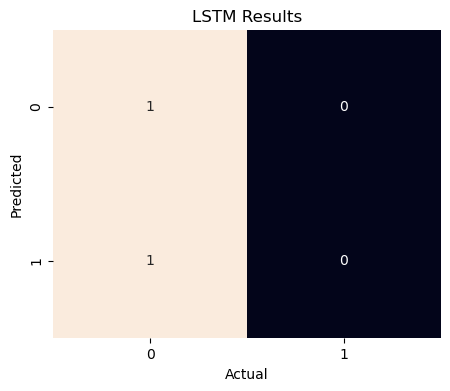

In [125]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LSTM Results')
plt.show()

In [126]:
con_time=5
row=1
columns=history/con_time
columns=int(columns)
#columns must be whole number

In [127]:
new_x_train = reshape_convlstm(x_train,con_time,row,columns)
new_x_test = reshape_convlstm(x_test,con_time,row,columns)

In [128]:
new_x_train.shape

(10509, 5, 1, 3, 38)

In [129]:
model = Sequential()
model.add(ConvLSTM2D(filters=96, return_sequences=True,kernel_size=(1,2), activation='relu', input_shape=new_x_train.shape[1:]))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=96, kernel_size=(1,2), activation='relu', input_shape=new_x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Flatten())
model.add(RepeatVector(y_train.shape[1]))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(y_train.shape[1],activation='sigmoid')))

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['binary_accuracy'])
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='auto')
earlyStopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, verbose=1, mode='auto')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 5, 1, 2, 96)       103296    
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 1, 2, 96)       384       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 1, 1, 96)          147840    
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 1, 96)          384       
_________________________________________________________________
flatten_2 (Flatten)          (None, 96)                0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 96)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 200)           

In [131]:
hist = model.fit(new_x_train,y_train, epochs=50, batch_size=128, verbose=True, validation_data=(new_x_test,y_test),callbacks=[earlyStopping])

Train on 10509 samples, validate on 6169 samples
Epoch 1/50
10509/10509 [==============================] - 10s 985us/sample - loss: 0.5608 - binary_accuracy: 0.7585 - val_loss: 0.5990 - val_binary_accuracy: 0.7474
Epoch 2/50
10509/10509 [==============================] - 4s 360us/sample - loss: 0.5468 - binary_accuracy: 0.7607 - val_loss: 0.5671 - val_binary_accuracy: 0.7474
Epoch 3/50
10509/10509 [==============================] - 4s 354us/sample - loss: 0.5405 - binary_accuracy: 0.7608 - val_loss: 0.5645 - val_binary_accuracy: 0.7474
Epoch 4/50
10509/10509 [==============================] - 4s 349us/sample - loss: 0.5349 - binary_accuracy: 0.7609 - val_loss: 0.5840 - val_binary_accuracy: 0.7474
Epoch 5/50
10509/10509 [==============================] - 4s 349us/sample - loss: 0.5271 - binary_accuracy: 0.7613 - val_loss: 0.5709 - val_binary_accuracy: 0.7474
Epoch 6/50
10509/10509 [==============================] - 4s 355us/sample - loss: 0.5210 - binary_accuracy: 0.7616 - val_loss: 0.5

In [136]:
y_pred_raw = model.predict(new_x_test)

y_pred = y_pred_raw > .50
y_pred=y_pred.reshape(-1)

confusion_matrix(y_test,y_pred)

array([[4287,  324],
       [1415,  143]], dtype=int64)

In [137]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83      4611
         1.0       0.31      0.09      0.14      1558

    accuracy                           0.72      6169
   macro avg       0.53      0.51      0.49      6169
weighted avg       0.64      0.72      0.66      6169



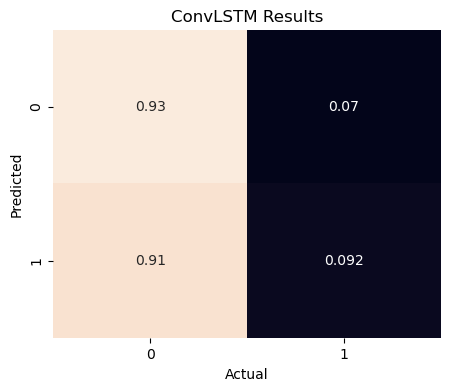

In [138]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true'),annot=True,cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ConvLSTM Results')
plt.show()

These models similarly don't perform well.  Even when looking at improving a subset of potential trades, the features simply are not expressive enough to determine a pattern in trading

Unlike the cheating stock lstm predictions you'd find on Medium, a proper model that doesn't use future information does terribly at predicting price movements.  While this project focused specifically on predicting the price movement for the next 5 days as a way to make the dependent variable less chaotic, alternative depedent variables such as close price movements and open-close price movements similarly failed.


This is not an invalidation of trading strategies.  A quick glance at the rudimentary ema crossover data shows that the signal performs reasonably well.  Trading, at least with the available data, seems better served by a clearly defined strategy based on rules and logic rather than machine learning predictions.  Machine learning may do well in predicting a potential indicator for a trading strategy, but all the signals and indicators likely could not make a machine learning model be useful for stock predictions without substantially more data than what most individuals have access to.

There are a few things that can be improved to hopefully encourage the models to learn.  While the features here are baseline metrics, there are likely more advanced metrics that could be applied to generate more variety between up and down movements.  It is possible that an exogenous factor is necessary to make reasonable predictions such as sentiment and company financial metrics, but getting reliable historical data is very difficult.  However, the short time period used here (30 minute intervals) shouldn't be swayed by long term trends like that.  Using longer intervals may be more productive as it helps mitigate the noise, but ultimately the limitations of open, high , low, close prices and the features generated from them are limiting.  The biggest improvement naturally comes with the nature of the data.  One of the biggest advantages of major financial entities is that they can access very specific data which may provide a greater distinction than data available to retail traders.  Depth chart data and/or options pricing data would likely improve model performance, but that is beyond the means of a retail trader.